# NAVER 뉴스 데이터를 이용하여서 데이터 추출하기

## 이 주제를 정한 이유

NAVER에서 언론사들이 다 뉴스로 게시하는 우리 사회를 통해서 기자들이 다 제목과 내용이 서로 유사한 내용을 소재로 연관되어서 기사를 쓰지만, 다 제목과 내용의 연관성과 신뢰성이 타당할까를 의문점을 게시하게 되었습니다. 그래서 Naver라는 데이터를 직접 데이터를 추출하여 데이터를 분석하고 이를 결과로 어떠한 것을 알게 되었는지의 과정을 해야 겠다고 결심하게 되었습니다.

## 이 주제를 쓰기 위해서 어떠한 과정과 자료들을 매개로 데이터을 사용하게 되었을까?

데이터라는 작업을 이용하는 과정이기 때문에 지금 이 Python이라는 코딩언어를 이용하여 네이버 뉴스 웹을 크롤링으로 데이터를 추출해야 겠음을 알게 되었습니다. 그리고 그 데이터를 이용하여서 데이터프레임을 생성시킨 후 이를 내용과 제목에 있는 한글 구성요소들을 단어 전처리를이용하여서 이 구성요소 단어가 제목에는 몇개의 구성요소가 있고 내용에는 몇개의 구성요소가 있는지를 수학에서 나온 행렬들을 사용하여서 표현하고, 이를 TF-IDF라는 것을 이용해서 데이터들을 수학 행렬로 만들게 되었습니다. 그리고, 이 만들어진 제목과 내용의 행렬들을 서로 유사도가 있는지 확인하기위해서 COSINE-SIMILARITY를 이용하여서 거의 벡터의 연산으로 얼마나 유사한지에 대한 비율을 만들고, 이를 시각화하면서 뉴스 데이터들의 관계를 분석해 보았습니다.

## 데이터 소스 코드 만들기

### 네이버 뉴스 크롤링하기

#### step1. 특정표본 이용하여 추출해보기

In [115]:
# 전체 코드를 실행시킬 모듈 불러오기
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import numpy as np
import time
from tokenization import *  # 내용, 제목들을 토큰화하는 모듈
from remove_stopwords import *  # 내용, 제목에 필요없는 단어들을 제거하는 모듈
from regular_expression import *    # 내용, 제목을 정규화시키는 모듈
from text_preprocessing_tools_for_korean_text import *  # 내용, 제목에 있는 한글들을 전처리 시켜주는 모듈
from integer_encoding import *  # 내용과 제목을 인코딩하는 모듈
from kiwipiepy import Kiwi  # 키위 클래스 모듈로 단어 토큰화 모듈
from tf_idf import TfidfVectorizer, tfidf    # tf , tfidf로 행렬를 만드는 모듈
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import bartlett, levene, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

In [2]:
# 현재 년, 월, 일을 6자리의 번호로 지정하기
now = time
now_ymd = int(now.strftime("%Y%m%d"))
print(now_ymd)

20221105


특정 뉴스의 제목 하나 추출하기

In [3]:
url_homepage_html = requests.get('https://n.news.naver.com/mnews/article/023/0003701167', headers={'User-Agent': 'Mozilla 5.0'})
url_homepage_soup = BeautifulSoup(url_homepage_html.text, 'html.parser')
url_title1 = url_homepage_soup.find('h2', {"class" : "media_end_head_headline"})
url_title2 = url_homepage_soup.find('h2', {"class" : "end_tit"})
if url_title1 == None and url_title2 == None:
    print('None')
elif url_title1 != None and url_title2 == None:
    print(url_title1.text)
elif url_title1 == None and url_title2 != None:
    print(url_title2.text)

판다는 언제부터 대나무만 먹었을까? 600만년 전 화석 봤더니…


#### 함수 만들어서 네이버 뉴스 추출하기

뉴스 출처 홈페이지 추출하기

In [4]:
def naver_news_url(list3:list, oid:str):
    list3 = []
    for date in tqdm(range(now_ymd, now_ymd+1)):
        url = f'https://news.naver.com/main/list.naver?mode=LPOD&mid=sec&listType=summary&oid={oid}&date={date}&page=1000'
        response = requests.get(url, headers={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36"})
        soup = BeautifulSoup(response.text, 'html.parser')
        last_page_data = soup.select('div.paging>strong')[0]
        last_page = int(last_page_data.text)
        for page in range(1, last_page+1):
            url = f'https://news.naver.com/main/list.naver?mode=LPOD&mid=sec&listType=summary&oid={oid}&date={date}&page={page}'
            response = requests.get(url, headers={"User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36"})
            soup=BeautifulSoup(response.text, 'html.parser')
            naver_news_image_data =soup.select('ul.type06_headline>li>dl>dt>a') + soup.select('ul.type06>li>dl>dt>a')
            for i in naver_news_image_data:
                if i.select('img')==[]:
                    list3.append(i['href'])
                else:
                    continue
    return list3
# 실험해보기
list3 = []
print(len(naver_news_url(list3=list3, oid='023')))

100%|██████████| 1/1 [00:06<00:00,  6.33s/it]

145


뉴스 제목 추출하기

In [5]:
def naver_news_title(list1_title:str, oid:str):
    list1_title=[]
    list1_url = []
    for url_homepage in naver_news_url(list1_url, oid):
        headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36"}
        url_homepage_html = requests.get(url_homepage, headers=headers)
        if url_homepage_html == None:
            list1_title.append(np.NaN)
        else:
            url_homepage_soup = BeautifulSoup(url_homepage_html.text, 'html.parser')
            url_title1 = url_homepage_soup.find('h2', {"class" : "media_end_head_headline"})
            url_title2 = url_homepage_soup.find('h2', {"class" : "end_tit"})
            if url_title1 == None and url_title2 == None:
                list1_title.append(np.NaN)
            elif url_title1 != None and url_title2 == None:
                list1_title.append(url_title1.text.strip())
            elif url_title1 == None and url_title2 != None:
                list1_title.append(url_title2.text.strip())
    return list1_title
# 테스트 해보기
list1_title=[]
print(len(naver_news_title(list1_title,'023')))


100%|██████████| 1/1 [00:05<00:00,  5.17s/it]


145


뉴스별 내용 추출하기

In [7]:
def naver_news_content(list2:list, oid:str):
    list2 = []
    for date in tqdm(range(now_ymd, now_ymd+1)):
        url = f'https://news.naver.com/main/list.naver?mode=LPOD&mid=sec&listType=summary&oid={oid}&date={date}&page=1000'
        response = requests.get(url, headers={"User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36"})
        soup = BeautifulSoup(response.text, 'html.parser')
        last_page_data = soup.select('div.paging>strong')[0]
        last_page = int(last_page_data.text)
        for page in range(1, last_page+1):
            url = f'https://news.naver.com/main/list.naver?mode=LPOD&mid=sec&listType=summary&oid={oid}&date={date}&page={page}'
            response = requests.get(url, headers={"User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36"})
            soup = BeautifulSoup(response.text, 'html.parser')
            naver_news_contents_data = soup.select('ul.type06_headline>li>dl>dd>span.lede') + soup.select('ul.type06>li>dl>dd>span.lede')
            for s in naver_news_contents_data:
                list2.append(s.text.strip())
    return list2
# 테스트해보기
list2 = []
oid = '023'
print(len(naver_news_content(list2,'023')))

100%|██████████| 1/1 [00:04<00:00,  4.87s/it]

145


### 신문 회사에 대한 데이터 프레임 생성하기

In [8]:
chosun_title_list = []
chosun_content_list = []
chosun_url_list = []
chosun_eilbo_news_data = pd.DataFrame()
chosun_eilbo_news_data["title"] = naver_news_title(chosun_title_list, oid='023')
chosun_eilbo_news_data["content"] = pd.Series(naver_news_content(chosun_content_list, oid='023'))
chosun_eilbo_news_data["url"] = pd.Series(naver_news_url(chosun_url_list, oid='023'))

100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


In [9]:
korean_title_list = []
korean_content_list = []
korean_url_list = []
korean_economy_news_data = pd.DataFrame()
korean_economy_news_data["title"] = pd.Series(naver_news_title(korean_title_list, oid='015'))
korean_economy_news_data["content"] = pd.Series(naver_news_content(korean_content_list, oid='015'))
korean_economy_news_data["url"] = pd.Series(naver_news_url(korean_url_list, oid='015'))

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


In [10]:
mail_title_list = []
mail_content_list = []
mail_url_list = []
mail_economy_news_data = pd.DataFrame()
mail_economy_news_data["title"] = pd.Series(naver_news_title(mail_title_list, oid='009'))
mail_economy_news_data["content"] = pd.Series(naver_news_content(mail_content_list, oid='009'))
mail_economy_news_data["url"] = pd.Series(naver_news_url(mail_url_list, oid='009'))

100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


In [11]:
middle_title_list = []
middle_content_list = []
middle_url_list = []
middle_eilbo_news_data = pd.DataFrame()
middle_eilbo_news_data["title"] = pd.Series(naver_news_title(middle_title_list, oid='025'))
middle_eilbo_news_data["content"] = pd.Series(naver_news_content(middle_content_list, oid='025'))
middle_eilbo_news_data["url"] = pd.Series(naver_news_url(middle_url_list, oid='025'))

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


In [12]:
money_title_list = []
money_content_list = []
money_url_list = []
money_today_news_data = pd.DataFrame()
money_today_news_data["title"] = pd.Series(naver_news_title(money_title_list, oid='008'))
money_today_news_data["content"] = pd.Series(naver_news_content(money_content_list, oid='008'))
money_today_news_data["url"] = pd.Series(naver_news_url(money_url_list, oid='008'))

100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


### 웹 크롤링한 네이버 뉴스 데이터프레임 읽기

네이버에서 뉴스 추출한 자료를 이용하여서 뉴스별 데이터프레임 부르기

In [2]:
# chosun_eilbo_database = pd.read_csv(r'C:\bigdata_git\bigdata_thunder\bigdata1\chosun_eilbo.csv', encoding='utf-8', index_col=False)
# korean_economy_database = pd.read_csv(r'C:\bigdata_git\bigdata_thunder\bigdata1\korean_economy.csv', encoding='utf-8', index_col=False)
# mail_economy_database = pd.read_csv(r'C:\bigdata_git\bigdata_thunder\bigdata1\mail_economy.csv', encoding='utf-8', index_col=False)
# midlle_eilbo_database = pd.read_csv(r'C:\bigdata_git\bigdata_thunder\bigdata1\middle_eilbo.csv', encoding='utf-8', index_col=False)
# money_today_database = pd.read_csv(r'C:\bigdata_git\bigdata_thunder\bigdata1\money_today.csv', encoding='utf-8', index_col=False)
# chosun_eilbo_database = pd.read_csv(r'C:\Users\user\Documents\github\bigdata_thunder\bigdata1\chosun_eilbo.csv', encoding='utf-8', index_col=False)
# korean_economy_database = pd.read_csv(r'C:\Users\user\Documents\github\bigdata_thunder\bigdata1\korean_economy.csv', encoding='utf-8', index_col=False)
# mail_economy_database = pd.read_csv(r'C:\Users\user\Documents\github\bigdata_thunder\bigdata1\mail_economy.csv', encoding='utf-8', index_col=False)
# midlle_eilbo_database = pd.read_csv(r'C:\Users\user\Documents\github\bigdata_thunder\bigdata1\middle_eilbo.csv', encoding='utf-8', index_col=False)
# money_today_database = pd.read_csv(r'C:\Users\user\Documents\github\bigdata_thunder\bigdata1\money_today.csv', encoding='utf-8', index_col=False)

데이터프레임에 있는 오류가 있는 값을 제거하기

In [13]:
chosun_eilbo_database = chosun_eilbo_news_data.dropna()
chosun_eilbo_database

title  \
0            “면목 없고 죄송”…이태원서 목터져라 인파 통제한 경찰, BBC서 오열   
2                           푸틴 “폴란드, 우크라이나 점령 야욕” 궤변   
3          “뭐든 해보자며 희망 붙들었다”...암흑 속에서도 탈출 노력한 봉화 광부들   
5    ‘죽음의 백조’ 미 전략폭격기 B-1B 랜서 오늘 한반도 전개…北 잇단 도발에 경고장   
6                        유승민, 헌법10조 언급하며 “무거운 책임 통감”   
..                                               ...   
140               [WEEKLY BIZ LETTER] 최고의 CEO가 일하는 법   
141                이재명 “광산 실종자, 긴 시간 이겨내주셔서 참으로 고마워”   
142            尹대통령, 봉화 광부 생환에 “기적같은 일, 감사하고 또 감사하다”   
143           [아무튼, 주말] 파도와 돌과 모래의 맛이 켜켜이 쌓인 ‘바다의 술’   
144                     [백영옥의 말과 글] [276] 앉은 자리가 꽃자리   

                                               content  \
0    이태원 핼러윈 참사 당시 목이 터져라 소리치며 인파를 통제한 경찰관이 BBC와의 인...   
2    우크라이나 침공을 지시한 블라디미르 푸틴 러시아 대통령이 공식 석상에서 폴란드가 우...   
3    경북 봉화 아연 광산 갱도 붕괴 사고에서 생환한 작업자 2명이 고립 당시 손수 암석...   
5    미국의 3대 전략폭격기 B-1B 랜서, 한미 연합공중훈련 합류 총 61t의 폭탄·미...   
6    국민의힘 유승민 전 의원은 이태원 핼러윈 참사 발생 일주일째를 맞은 5일 “무거운 ...   
..                                                 ...   
140  돈이 보이는 경제 뉴스 WEEKLY BIZ LETTER #207 조선일보 lette...   
141  더불어민주당 이재명 대표는 4일 경북 봉화군 한 광산에서 고립됐던 작업자 2명이 사...   
142  윤석열 대통령은 경북 봉화군 광산 사고로 매몰됐던 광부 조장 박모(62)씨와 보조 ...   
143  라가불린 블라인드 테스트를 그다지 믿지 않는다. 특히나 그런 걸 하는 사람이 나라면...   
144  3주간 기차로 이동하는 여행을 떠난 적이 있다. 자주 역방향으로 달려가는 좌석에 앉...   

                                                   url  
0    https://n.news.naver.com/mnews/article/023/000...  
2    https://n.news.naver.com/mnews/article/023/000...  
3    https://n.news.naver.com/mnews/article/023/000...  
5    https://n.news.naver.com/mnews/article/023/000...  
6    https://n.news.naver.com/mnews/article/023/000...  
..                                                 ...  
140  https://n.news.naver.com/mnews/article/023/000...  
141  https://n.news.naver.com/mnews/article/023/000...  
142  https://n.news.naver.com/mnews/article/023/000...  
143  https://n.news.naver.com/mnews/article/023/000...  
144  https://n.news.naver.com/mnews/article/023/000...  

[131 rows x 3 columns]

In [14]:
korean_economy_database = korean_economy_news_data.dropna()
korean_economy_database

title  \
0            서울광장 분향소 '이태원 사고 사망자'→'참사 희생자' 변경   
1           [속보] 대우건설, 한남2구역 재개발 수주…'한남써밋' 짓는다   
2   빈필이 빚어낸 관(管)과 현(絃)의 '환상 하모니' 2 [송태형의 현장노트]   
3          돌아온 광부들, 먹고 싶은 건 "미역국과 콜라"·"소주 한 잔"   
4          尹 "꽃다운 청년들 지키지 못한 미안함 영원할 것"…이틀째 사과   
..                                         ...   
59                             [시론] 산업정책이 민생이다   
60               [이소연의 시적인 순간] 사람에게도 '떨켜'가 있다면   
61                    [기고] 국가경쟁력, 포괄적 전략이 필요하다   
62            "모닥불로 버텼다"…광산 매몰 근로자 2명 '기적의 생환'   
63                      [한경에세이] '아우스빌둥'이 낳은 기적   

                                              content  \
0   서울시청 광장에 마련된 이태원 참사 합동분향소에 걸린 문구가 국가애도기간 마지막 날...   
1   서울시 용산구 한남2구역 재개발 사업 시공사로 대우건설이 선정됐다. 한남2구역 재개...   
2   브람스의 교향곡 3번 3악장을 두 달 전쯤 ‘음악이 흐르는 아침’이란 코너에 가을에...   
3   경북 봉화 아연 광산에서 매몰된 광부 2명이 221시간 만에 극적으로 생환했다. 현...   
4   윤석열 대통령이 이태원 참사와 관련해 "꽃다운 청년들을 지키지 못한 미안한 마음이 ...   
..                                                ...   
59  미국 경제성장론 교과서에서 한국의 산업정책은 가장 성공적인 사례로 소개된다. 6·2...   
60  잎이 떨어진다. 바람이 눈에 보인다는 감각에 홀리기 좋은 가을이다. 이문재 시인은 ...   
61  작년 7월 2일 유엔무역개발회의(UNCTAD)는 한국을 개도국 지위에서 선진국 지위...   
62  경북 봉화에서 광산 매몰 사고로 고립된 근로자들이 10일 만에 돌아왔다. 4일 소방...   
63  한국 고교생이 4년제 대학이나 전문대에 진학하지 않고 탄탄한 직장 생활을 시작하려면...   

                                                  url  
0   https://n.news.naver.com/mnews/article/015/000...  
1   https://n.news.naver.com/mnews/article/015/000...  
2   https://n.news.naver.com/mnews/article/015/000...  
3   https://n.news.naver.com/mnews/article/015/000...  
4   https://n.news.naver.com/mnews/article/015/000...  
..                                                ...  
59  https://n.news.naver.com/mnews/article/015/000...  
60  https://n.news.naver.com/mnews/article/015/000...  
61  https://n.news.naver.com/mnews/article/015/000...  
62  https://n.news.naver.com/mnews/article/015/000...  
63  https://n.news.naver.com/mnews/article/015/000...  

[63 rows x 3 columns]

In [15]:
mail_economy_database = mail_economy_news_data.dropna()
mail_economy_database

title  \
0              홍석천, 독일 대통령 내외 만났다 “다름에 대한 깊은 대화”   
2        “501명 희생 ‘삼풍참사’ 때 뭘 배웠나”…이태원 참사 꼬집은 美언론   
3                 B.A.P 출신 힘찬, 12월 추가 강제추행 혐의 공판   
4            [속보] ‘7900억’ 재개발 최대어 한남2구역 대우건설 품으로   
5                 尹 대통령 “꽃다운 청년들 지켜주지 못해 미안한 마음”   
..                                           ...   
85  해외 부동산 ‘차이나 머니’ 공습...시진핑 3기 더 거세지나[한중일 톺아보기]   
86                  해외여행 ‘1순위’ 일본, 가을·겨울 추천여행지 4   
88         “커피믹스를 밥처럼”…봉화 광산 매몰 2명, ‘희망 끈’ 놓지 않아   
89                  봉화 광산 고립자 2명 생환에 尹 “기적 같은 일”   
90           북한 외무성 “자주권 침해에 초강력 대응…미국은 경거망동 말라”   

                                              content  \
0   방송인 홍석천이 독일 대통령 내외를 만났다. 홍석천은 5일 자신의 SNS에 “어젯밤...   
2   삼풍 때와 이태원 참사 비슷 한 상황 한국 매력 있지만 이에 걸 맞는 책임감 부족 ...   
3   그룹 B.A.P 출신 힘찬의 구설은 언제쯤 끝날까. 힘찬의 추가 강제추행 혐의 재판...   
4   대우건설이 올 하반기 재개발 최대어로 손꼽히는 한남2구역 시공권을 손에 넣었다. 한...   
5   한국교회 이태원 참사 위로예배 참석 윤석열 대통령은 5일 이태원 참사와 관련해 “마...   
..                                                ...   
85  #베이징 출신으로 일본에 거주하고 있는 중국인 왕씨. 그는 건물을 매입해 호텔 등 ...   
86  코로나 엔데믹, 그러니까 주기적 유행으로 접어들면서 해외여행에 대한 관심과 수요가 ...   
88  경북 봉화군 아연 광산 매물사고로 고립됐다 9일만에 구조된 노동자 2명은 가지고 있...   
89  사고 발생 221시간만에 갱도 탈출 윤석열 대통령이 경북 봉화군 광산 매몰사고로 고...   
90  북한이 4일 한미 연합공중훈련 ‘비질런트 스톰’(Vigilant Storm)이 연장...   

                                                  url  
0   https://n.news.naver.com/mnews/article/009/000...  
2   https://n.news.naver.com/mnews/article/009/000...  
3   https://n.news.naver.com/mnews/article/009/000...  
4   https://n.news.naver.com/mnews/article/009/000...  
5   https://n.news.naver.com/mnews/article/009/000...  
..                                                ...  
85  https://n.news.naver.com/mnews/article/009/000...  
86  https://n.news.naver.com/mnews/article/009/000...  
88  https://n.news.naver.com/mnews/article/009/000...  
89  https://n.news.naver.com/mnews/article/009/000...  
90  https://n.news.naver.com/mnews/article/009/000...  

[89 rows x 3 columns]

In [80]:
middle_eilbo_database = middle_eilbo_news_data.dropna()
middle_eilbo_database

title  \
0                빈 필, 예정 없던 이태원 참사 추모곡 "음악으로 위안과 희망을"   
1                        서울 북한산 산불 주불 진화 완료 “인명피해 없어”   
3          尹대통령, 이태원 참사 위로 예배 “청년들 지키지 못해…영원히 미안한 마음”   
4                 서울 북한산 산불 진화 작업 중…“등산객 화재 지역 접근 자제”   
5               용산서장, 차로 이태원 현장 가려다 50분 걸려...당일 동선 공개   
6                매몰된 광부들 곁엔 '이 것' 꼭 있었다...'기적의 생환' 법칙   
8                   "일상을 살다 참사를 당한 겁니다" 상담치료 공유하는 생존자   
9                    '게이들의 디즈니랜드' 만든 재미교포 앤드류 안 감독의 꿈   
11                네 발로 엉금엉금...깜깜한 새벽, 운전자 경악케한 노인의 행동   
12                  221시간 믹스커피로 버틴 광부 "가장 먹고 싶은건 미역국"   
13                    이재현 CJ그룹 회장 모친 손복남 고문 별세…향년 89세   
14               민주 "외장하드는 정진상 아들 것, 비번 안 숨겼다…검찰의 꼼수"   
15                 밤10시15분 첫 119신고라더니…이태원 신고 이전에도 있었다   
16                   美 전략폭격기 B-1B 한미 공중훈련 합류…北 도발에 경고   
17                  '이태원 참사 희생자'로 문구 바꾼 서울시…尹, 엿새째 조문   
19                  "평소 챙겨 다니던 소화기로"…길거리 화재 진압한 가수 정체   
20                    지옥철 막는다…수도권 전철 15군데 혼잡역 긴급 현장점검   
21                   구조 순간, 동료들 부둥켜 안고 오열…무사생환 결정적 이유   
22                      [속보] 경북경찰청 "봉화 광산매몰 사고 수사 착수"   
23                     한총리 “이태원 사고 원인 규명해 국민께 소상히 설명”   
24                  "면목 없고 죄송"…참사 그날 목 터져라 외친 경찰관의 눈물   
25                 또 인천대교...갓길에 차량 세우고 바다로 투신한 30대 사망   
26                "손흥민 안와골절 수술 성공적"...24일 월드컵 첫 경기 뛰나   
27                 "CPR하다 갈비뼈 부러뜨리면…" 의인 멈칫하게한 잠자는 국회   
28              이번엔 노동부 감독 서류 빼돌리다 적발...SPC삼립 "깊이 사과"   
29                 "모친이 이재용 회장과 식사하는 꿈"…복권1등 두번 당첨 사연   
30                   커피믹스와 갱도물로 221시간 버텼다…봉화 구조자들 상태는   
31                  "붙박이 상인에 보행 통제권한을" 이태원에 놀란 지자체 대책   
32                [퍼즐] 한옥은 좁고 수납공간 없다는 편견 깨는 곳…계동 선유당   
33                "한국계 추정 34세 전직 美장교, 우크라 전쟁서 전투중 숨져"   
34                   '음주운전' 김새론 충격 근황…"생활고로 카페 아르바이트"   
35               '15.55g' 은화 절반에도 폭발…영남 알프스 9봉 완등 줄섰다   
36               [포토버스]만추(晩秋), 가을의 끝자락을 거닐며 갖는 치유의 시간   
38               한국 맞아? 드론까지 띄웠다…7300대 1 뚫은 제주 풍경, 어디   
39                 이태원 참사에 '페스티벌' 지웠다…이커머스도 '조용한 11월'   
40                  김용 침묵해도 신경 안쓴다? 정진상 조준하는 檢 자신감, 왜   
41  은하철도999?…'KTX 007, SRT 333' 고속열차 '번호'의 비밀 [강갑생...   
42          "Lee가 이재명입니까" "네"…대장동 재판서 또 거명된 이재명 [法ON]   
43       제 몸보다 큰 소·말도 사냥…제주 중간산 들개 2000마리 공포 [e즐펀한토크]   
44                  "尹 때리는 유승민이 부럽다"…'소신발언'에 속내 복잡한 野   
45        '이스라엘 왕'의 부활…'부패' 네타냐후, 극우 업고 돌아온 이유 [후후월드]   
46               희망퇴직이 복지제도?...사측 "강제성 없어" 직원 "신청 압박"   
47            "주최측 없는 매뉴얼은 없다"…존재이유 망각한 경찰의 항변 [현장에서]   
48                 "집 가는 그 골목 못지나가 매일 외박"…일상이 버거운 이태원   
49               월소득 200만원 직장인, 국민연금 30년 부으면 매달 얼마 받나   
50                 "커피믹스 밥처럼 먹으며 버텨…발파 소리에 희망 놓지 않았다"   
51                "아빠 조금만 더" 하늘에 닿은 염원…아내는 감격의 눈물 흘렸다   
52          이재명, 봉화광산 구조에 "염원이 만든 기적"…野 "가족 품 돌아와 감사"   
53                 고환 없애니 재범률 10분의 1…성범죄 본능 어디까지 조절될까   
54                   尹대통령, 봉화광산 2명 구조에 "감사하고 또 감사합니다"   
55      나는 암환자 보는 한의사…"남은 삶 존엄한 여정을 함께한다" [김은혜의 살아내다]   

                                              content  \
0   빈 필하모닉(이하 빈 필)은 클래식 음악계에서 ‘전통’이 뭔지를 잘 말해주는 오케스...   
1   5일 오후 2시 38분 서울 은평구 북한산에서 발생한 산불 주불이 1시간 40분 만...   
3   윤석열 대통령은 5일 이태원 참사와 관련해 “마음이 무겁다. 참으로 가슴이 아프다”...   
4   5일 서울 은평구 북한산에서 산불이 발생해 소방당국이 진화작업을 벌이고 있다. 산림...   
5   이태원 참사 당일 사고 발생 50분 뒤에야 현장에 도착한 용산경찰서장의 구체적인 동...   
6   '갱도 물' '계획성 있는 섭취' '생존 의지' 경북 봉화군 아연 광산 매몰사고 발...   
8   “선생님 아무래도 가지 말았어야 했어요.” “아니에요. 가지 말았어야하는 것이 아니...   
9   영국 작가 제인 오스틴(1775~1817)의 고전 소설 『오만과 편견』을 현대판 게...   
11  어두운 새벽 편도 3차로 도로에서 네발로 기어서 무단횡단하는 노인의 영상이 공개됐다...   
12  “가장 먹고 싶은 것은 미역국과 콜라, 가장 가고 싶은 곳은 바다입니다.” 무너진 ...   
13  이재현 CJ그룹 회장의 모친 손복남 고문이 5일 오전 숙환으로 별세했다. 향년 89...   
14  더불어민주당은 5일 검찰 수사를 받는 이재명 대표의 최측근 정진상 대표실 정무조정실...   
15  소방청이 이태원 참사 당일 밤 10시 15분 첫 119 신고가 있었다고 밝혀왔는데 ...   
16  미국 전략자산으로 꼽히는 B-1B 전략폭격기가 한반도로 전개해 도발 수위를 높여가는...   
17  윤석열 대통령은 이태원 참사 희생자들을 위한 국가애도기간 마지막 날인 5일에도 합동...   
19  밴드 9001의 보컬 조곤(25·본명 조장관)이 휴대하고 있던 소화기로 도로에서 발...   
20  한국철도공사(코레일)는 오는 7일부터 수도권 전철 구로역, 신도림역, 금정역 등 1...   
21  “수고했다! 고생했다!” 지난 4일 오후 11시3분 경북 봉화군 소천면 아연광산 갱...   


In [17]:
money_today_database = money_today_news_data.dropna()
money_today_database

title  \
0        북한산 족두리봉 '원인미상' 산불…"등산객 대피·접근 자제"   
1    검찰 "정진상 외장하드 암호 해제 중…'아들 노트북'은 압수 안해"   
2      서서 대변 보는 아이…놀란 오은영 "'이것' 떨어져" 충격 진단   
3            택배기사로 위장…어머니 흉기 협박해 금고 털어간 아들   
4      식당 불났는데 "설렁탕 먹자"…'긍정' 형제에 오은영 반전 분석   
..                                     ...   
82     "꿈에서 모친이 이재용 회장과 식사" 복권 1등 2번째 당첨 男   
83   [더영상]"CPR 가능한 분" 절박한 외침…손 '덜덜' 용산소방서장   
85  [오늘 날씨] 아침 최처 '-5도' 초겨울 추위…바람 강해 체감온도↓   
86        연준 '초강력 긴축'에도...美노동시장 "예상보다 강했다"   
87    모닥불로 10일 버텼다…봉화 광산 매몰 광부 2명 '기적의 생환'   

                                              content  \
0   서울 은평구 북한산 족두리봉에서 원인을 알 수 없는 산불이 발생했다. 5일 뉴스1에...   
1   검찰이 '성남FC 후원금 의혹'과 관련해 정진상 더불어민주당 대표실 정무조정실장의 ...   
2   대변을 서서 보는 등 이상행동을 보이는 금쪽이의 사연이 전파를 탄다. 11일 방송되...   
3   어머니를 흉기로 위협해 금고에 있던 현금 1500만원 등을 훔쳐 달아난 20대 남성...   
4   중화요리의 대가 여경래, 여경옥 형제가 '금쪽상담소'를 찾는다. 오는 11일 방송되...   
..                                                ...   
82  스피또1000 복권 1등에 당첨되는 행운을 거머쥔 당첨자가 과거 전자복권 1등에도 ...   
83  이번주 [더영상] 첫번째는 이태원 참사 현장에서 CPR(심폐소생술)을 도와달라고 외...   
85  토요일인 오늘(5일)은 아침 최저기온이 영하 5도까지 떨어지면서 영하권 추위가 이어...   
86  미 연방준비제도(연준·Fed)의 공격적 금리 인상에도 불구하고 미국 노동시장은 예상...   
87  경북 봉화군 아연 광산 매몰사고로 갱도에 고립됐던 작업자가 10일만에 무사히 생환했...   

                                                  url  
0   https://n.news.naver.com/mnews/article/008/000...  
1   https://n.news.naver.com/mnews/article/008/000...  
2   https://n.news.naver.com/mnews/article/008/000...  
3   https://n.news.naver.com/mnews/article/008/000...  
4   https://n.news.naver.com/mnews/article/008/000...  
..                                                ...  
82  https://n.news.naver.com/mnews/article/008/000...  
83  https://n.news.naver.com/mnews/article/008/000...  
85  https://n.news.naver.com/mnews/article/008/000...  
86  https://n.news.naver.com/mnews/article/008/000...  
87  https://n.news.naver.com/mnews/article/008/000...  

[86 rows x 3 columns]

In [18]:
# 제목-내용에서 명사만 추출하는 함수
kiwi = Kiwi()
def extract_noun_from_kiwi_analyzed(comment):
    temp_sentence = kiwi.analyze(comment)
    noun_list = [token.form for token in temp_sentence[0][0] if re.match('N', token.tag)]
    return noun_list

## 전체 표본 이용하여서 tf-idf 데이터 유사도 추출하기

### 조선일보의 데이터 유사성 구하기

제목 추출하기

In [19]:
whole_chosun_title_noun = []
for chosun_title in chosun_eilbo_database["title"]:
    kospacing_title_list = []
    list1 = str(chosun_title).split('.')
    for i in list1:
        i_1= ''
        i_1+=i
        for i_2 in i_1.split(','):
            title = ''
            title+= i_2
        kospacing_title_list.append(title)
    for title in kospacing_title_list:
        for noun in extract_noun_from_kiwi_analyzed(title):
            if len(noun) < 3:
                continue
            else:
                whole_chosun_title_noun.append(noun)

추출한 url에서 BeautifulSoup을 이용하여서 뉴스에 있는 내용들 추출하기

In [20]:
whole_chosun_content_sentence_list = []
count = 1
for chosun_url in tqdm(chosun_eilbo_database["url"]):
    headers = {"User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36"}
    try:
        response_0 = requests.get(chosun_url, headers=headers)
    except OSError:
        print("OS 연결에서 응답이 되지 않습니다.")
        whole_chosun_content_sentence_list.append("None")     
    else:
        soup_0 = BeautifulSoup(response_0.text, 'html.parser')
        content_0_data = soup_0.find('div', {"id" : "dic_area"})
        try:
            content_0_data = content_0_data.get_text().strip()
        except AttributeError:
            whole_chosun_content_sentence_list.append("None")
        else:
            content_0_data = content_0_data.replace('\n','').replace('\t','')
            new_content_0_data = content_0_data.replace(" ", '')
            kospacing_new_content_0_data = spacing(new_content_0_data) 
            words_data = twitter.morphs(kospacing_new_content_0_data)
            with open("korean_stopwords.txt", "r", encoding="UTF-8") as stopwords:
                stopwords_list = stopwords.read().split('\n')
            new_content_1 ='' 
            for i in korean_change_no_stop_words(words_data, stopwords_list):
                new_content_1 += i
            tokenizer3_content_1 = RegexpTokenizer('[A-Za-z0-9ㄱ-ㅎ/()]+', gaps=True)
            # tokenizer3_content_2 = RegexpTokenizer('')
            # print(tokenizer3_content_1.tokenize(new_content_1))
            regular_expression_sentence = ''
            for expression in tokenizer3_content_1.tokenize(new_content_1):
                regular_expression_sentence += expression
            whole_chosun_content_sentence_list.append(regular_expression_sentence)

  0%|          | 0/131 [00:00<?, ?it/s]

1/1 [==============================] - 0s 127ms/step


  1%|          | 1/131 [00:14<31:39, 14.61s/it]

1/1 [==============================] - 0s 69ms/step


  2%|▏         | 2/131 [00:15<13:58,  6.50s/it]

1/1 [==============================] - 0s 66ms/step


  2%|▏         | 3/131 [00:17<09:11,  4.31s/it]

1/1 [==============================] - 0s 65ms/step


  3%|▎         | 4/131 [00:18<06:38,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


  4%|▍         | 5/131 [00:19<05:01,  2.39s/it]

1/1 [==============================] - 0s 53ms/step


  5%|▍         | 6/131 [00:20<04:12,  2.02s/it]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 7/131 [00:22<04:14,  2.05s/it]

1/1 [==============================] - 0s 119ms/step


  6%|▌         | 8/131 [00:24<03:45,  1.83s/it]

1/1 [==============================] - 0s 61ms/step


  7%|▋         | 9/131 [00:26<03:54,  1.92s/it]

1/1 [==============================] - 0s 51ms/step


  8%|▊         | 10/131 [00:27<03:16,  1.62s/it]

1/1 [==============================] - 0s 82ms/step


  8%|▊         | 11/131 [00:28<02:54,  1.46s/it]

1/1 [==============================] - 0s 57ms/step


  9%|▉         | 12/131 [00:30<03:13,  1.63s/it]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 13/131 [00:30<02:25,  1.23s/it]

1/1 [==============================] - 0s 44ms/step


 11%|█         | 14/131 [00:31<02:03,  1.06s/it]

1/1 [==============================] - 0s 64ms/step


 11%|█▏        | 15/131 [00:32<02:03,  1.07s/it]

1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 16/131 [00:33<01:51,  1.03it/s]

1/1 [==============================] - 0s 61ms/step


 13%|█▎        | 17/131 [00:34<01:49,  1.04it/s]

1/1 [==============================] - 0s 52ms/step


 14%|█▎        | 18/131 [00:35<01:44,  1.08it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▍        | 19/131 [00:35<01:41,  1.10it/s]

1/1 [==============================] - 0s 59ms/step


 15%|█▌        | 20/131 [00:36<01:27,  1.26it/s]

1/1 [==============================] - 0s 64ms/step


 16%|█▌        | 21/131 [00:37<01:45,  1.04it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█▋        | 22/131 [00:38<01:38,  1.10it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 23/131 [00:39<01:28,  1.23it/s]

1/1 [==============================] - 0s 62ms/step


 18%|█▊        | 24/131 [00:39<01:23,  1.28it/s]

1/1 [==============================] - 0s 75ms/step


 19%|█▉        | 25/131 [00:44<03:08,  1.78s/it]

1/1 [==============================] - 0s 68ms/step


 20%|█▉        | 26/131 [00:45<02:48,  1.60s/it]

1/1 [==============================] - 0s 62ms/step


 21%|██        | 27/131 [00:46<02:24,  1.39s/it]

1/1 [==============================] - 0s 76ms/step


 21%|██▏       | 28/131 [00:47<02:20,  1.36s/it]

1/1 [==============================] - 0s 62ms/step


 22%|██▏       | 29/131 [00:48<02:02,  1.20s/it]

1/1 [==============================] - 0s 79ms/step


 23%|██▎       | 30/131 [00:49<02:01,  1.20s/it]

1/1 [==============================] - 0s 69ms/step


 24%|██▎       | 31/131 [00:50<01:56,  1.16s/it]

1/1 [==============================] - 0s 76ms/step


 24%|██▍       | 32/131 [00:51<01:41,  1.03s/it]

1/1 [==============================] - 0s 62ms/step


 25%|██▌       | 33/131 [00:55<03:07,  1.91s/it]

1/1 [==============================] - 0s 55ms/step


 26%|██▌       | 34/131 [00:57<03:21,  2.07s/it]

1/1 [==============================] - 0s 64ms/step


 27%|██▋       | 35/131 [00:59<02:59,  1.87s/it]

1/1 [==============================] - 0s 59ms/step


 27%|██▋       | 36/131 [01:00<02:53,  1.82s/it]

1/1 [==============================] - 0s 65ms/step


 28%|██▊       | 37/131 [01:01<02:33,  1.63s/it]

1/1 [==============================] - 0s 71ms/step


 29%|██▉       | 38/131 [01:03<02:20,  1.51s/it]

1/1 [==============================] - 0s 137ms/step


 30%|██▉       | 39/131 [01:04<02:03,  1.34s/it]

1/1 [==============================] - 0s 58ms/step


 31%|███       | 40/131 [01:04<01:43,  1.14s/it]

1/1 [==============================] - 0s 51ms/step


 31%|███▏      | 41/131 [01:05<01:42,  1.14s/it]

1/1 [==============================] - 0s 76ms/step


 32%|███▏      | 42/131 [01:09<02:37,  1.77s/it]

1/1 [==============================] - 0s 63ms/step


 33%|███▎      | 43/131 [01:56<22:35, 15.40s/it]

1/1 [==============================] - 0s 67ms/step


 34%|███▎      | 44/131 [01:57<16:08, 11.13s/it]

1/1 [==============================] - 0s 57ms/step


 34%|███▍      | 45/131 [01:58<11:34,  8.08s/it]

1/1 [==============================] - 0s 63ms/step


 35%|███▌      | 46/131 [02:00<08:42,  6.15s/it]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 47/131 [02:00<06:21,  4.54s/it]

1/1 [==============================] - 0s 62ms/step


 37%|███▋      | 48/131 [02:01<04:47,  3.47s/it]

1/1 [==============================] - 0s 63ms/step


 37%|███▋      | 49/131 [02:04<04:25,  3.24s/it]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 50/131 [02:05<03:30,  2.60s/it]

1/1 [==============================] - 0s 72ms/step


 39%|███▉      | 51/131 [02:06<02:50,  2.13s/it]

1/1 [==============================] - 0s 78ms/step


 40%|███▉      | 52/131 [02:07<02:26,  1.85s/it]

1/1 [==============================] - 0s 77ms/step


 40%|████      | 53/131 [02:09<02:22,  1.83s/it]

1/1 [==============================] - 0s 72ms/step


 41%|████      | 54/131 [02:10<01:57,  1.52s/it]

1/1 [==============================] - 0s 73ms/step


 42%|████▏     | 55/131 [02:11<01:53,  1.49s/it]

1/1 [==============================] - 0s 56ms/step


 43%|████▎     | 56/131 [02:12<01:39,  1.33s/it]

1/1 [==============================] - 0s 51ms/step


 44%|████▎     | 57/131 [02:13<01:26,  1.16s/it]

1/1 [==============================] - 0s 87ms/step


 44%|████▍     | 58/131 [02:14<01:23,  1.14s/it]

1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 59/131 [02:16<01:25,  1.19s/it]

1/1 [==============================] - 0s 88ms/step


 46%|████▌     | 60/131 [02:17<01:25,  1.21s/it]

1/1 [==============================] - 0s 76ms/step


 47%|████▋     | 61/131 [02:17<01:10,  1.01s/it]

1/1 [==============================] - 0s 79ms/step


 47%|████▋     | 62/131 [02:19<01:18,  1.14s/it]

1/1 [==============================] - 0s 80ms/step


 48%|████▊     | 63/131 [02:20<01:21,  1.20s/it]

1/1 [==============================] - 0s 68ms/step


 49%|████▉     | 64/131 [02:22<01:35,  1.43s/it]

1/1 [==============================] - 0s 96ms/step


 50%|████▉     | 65/131 [02:23<01:20,  1.22s/it]

1/1 [==============================] - 0s 87ms/step


 50%|█████     | 66/131 [02:25<01:31,  1.41s/it]

1/1 [==============================] - 0s 70ms/step


 51%|█████     | 67/131 [02:27<01:39,  1.55s/it]

1/1 [==============================] - 0s 76ms/step


 52%|█████▏    | 68/131 [02:28<01:42,  1.62s/it]

1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 69/131 [02:37<03:57,  3.83s/it]

1/1 [==============================] - 0s 81ms/step


 53%|█████▎    | 70/131 [02:39<03:08,  3.08s/it]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 71/131 [02:40<02:28,  2.48s/it]

1/1 [==============================] - 0s 73ms/step


 55%|█████▍    | 72/131 [02:41<01:59,  2.03s/it]

1/1 [==============================] - 0s 89ms/step


 56%|█████▌    | 73/131 [02:42<01:42,  1.77s/it]

1/1 [==============================] - 0s 78ms/step


 56%|█████▋    | 74/131 [02:49<03:06,  3.28s/it]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 75/131 [03:13<08:57,  9.59s/it]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 76/131 [03:14<06:23,  6.96s/it]

1/1 [==============================] - 0s 63ms/step


 59%|█████▉    | 77/131 [03:15<04:47,  5.32s/it]

1/1 [==============================] - 0s 66ms/step


 60%|█████▉    | 78/131 [03:16<03:27,  3.92s/it]

1/1 [==============================] - 0s 68ms/step


 60%|██████    | 79/131 [03:16<02:28,  2.85s/it]

1/1 [==============================] - 0s 62ms/step


 61%|██████    | 80/131 [03:17<01:52,  2.20s/it]

1/1 [==============================] - 0s 67ms/step


 62%|██████▏   | 81/131 [03:18<01:29,  1.79s/it]

1/1 [==============================] - 0s 68ms/step


 63%|██████▎   | 82/131 [03:19<01:14,  1.52s/it]

1/1 [==============================] - 0s 68ms/step


 63%|██████▎   | 83/131 [03:20<01:14,  1.55s/it]

1/1 [==============================] - 0s 62ms/step


 64%|██████▍   | 84/131 [03:23<01:27,  1.86s/it]

1/1 [==============================] - 0s 57ms/step


 65%|██████▍   | 85/131 [03:23<01:04,  1.41s/it]

1/1 [==============================] - 0s 57ms/step


 66%|██████▌   | 86/131 [03:24<00:53,  1.18s/it]

1/1 [==============================] - 0s 72ms/step


 66%|██████▋   | 87/131 [03:25<00:51,  1.16s/it]

1/1 [==============================] - 0s 61ms/step


 67%|██████▋   | 88/131 [03:26<00:45,  1.06s/it]

1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 89/131 [03:26<00:37,  1.11it/s]

1/1 [==============================] - 0s 63ms/step


 69%|██████▊   | 90/131 [03:27<00:30,  1.33it/s]

1/1 [==============================] - 0s 65ms/step


 69%|██████▉   | 91/131 [03:28<00:30,  1.33it/s]

1/1 [==============================] - 0s 74ms/step


 70%|███████   | 92/131 [03:39<02:34,  3.97s/it]

1/1 [==============================] - 0s 69ms/step


 71%|███████   | 93/131 [03:45<02:54,  4.60s/it]

1/1 [==============================] - 0s 65ms/step


 72%|███████▏  | 94/131 [03:51<03:02,  4.93s/it]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 95/131 [03:51<02:10,  3.64s/it]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 96/131 [03:52<01:36,  2.77s/it]

1/1 [==============================] - 0s 67ms/step


 74%|███████▍  | 97/131 [03:53<01:14,  2.18s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 98/131 [03:55<01:07,  2.05s/it]

1/1 [==============================] - 0s 65ms/step


 76%|███████▌  | 99/131 [03:56<00:56,  1.78s/it]

1/1 [==============================] - 0s 59ms/step


 76%|███████▋  | 100/131 [03:56<00:42,  1.37s/it]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 101/131 [03:57<00:34,  1.15s/it]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 102/131 [03:57<00:26,  1.10it/s]

1/1 [==============================] - 0s 63ms/step


 79%|███████▊  | 103/131 [03:58<00:27,  1.02it/s]

1/1 [==============================] - 0s 63ms/step


 79%|███████▉  | 104/131 [04:01<00:39,  1.45s/it]

1/1 [==============================] - 0s 67ms/step


 80%|████████  | 105/131 [04:02<00:35,  1.35s/it]

1/1 [==============================] - 0s 67ms/step


 81%|████████  | 106/131 [04:03<00:30,  1.21s/it]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 107/131 [04:04<00:30,  1.26s/it]

1/1 [==============================] - 0s 61ms/step


 82%|████████▏ | 108/131 [04:07<00:37,  1.64s/it]

1/1 [==============================] - 0s 86ms/step


 83%|████████▎ | 109/131 [04:08<00:34,  1.55s/it]

1/1 [==============================] - 0s 72ms/step


 84%|████████▍ | 110/131 [04:10<00:36,  1.76s/it]

1/1 [==============================] - 0s 57ms/step


 85%|████████▍ | 111/131 [04:11<00:30,  1.53s/it]

1/1 [==============================] - 0s 63ms/step


 85%|████████▌ | 112/131 [04:14<00:31,  1.68s/it]

1/1 [==============================] - 0s 77ms/step


 86%|████████▋ | 113/131 [04:17<00:38,  2.13s/it]

1/1 [==============================] - 0s 77ms/step


 87%|████████▋ | 114/131 [04:18<00:32,  1.89s/it]

1/1 [==============================] - 0s 112ms/step


 88%|████████▊ | 115/131 [04:23<00:42,  2.68s/it]

1/1 [==============================] - 0s 64ms/step


 89%|████████▊ | 116/131 [04:28<00:53,  3.59s/it]

1/1 [==============================] - 0s 89ms/step


 89%|████████▉ | 117/131 [04:29<00:38,  2.75s/it]

1/1 [==============================] - 0s 72ms/step


 90%|█████████ | 118/131 [04:41<01:11,  5.46s/it]

1/1 [==============================] - 0s 64ms/step


 91%|█████████ | 119/131 [04:51<01:21,  6.82s/it]

1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 120/131 [04:52<00:57,  5.24s/it]

1/1 [==============================] - 0s 101ms/step


 92%|█████████▏| 121/131 [04:53<00:38,  3.85s/it]

1/1 [==============================] - 0s 69ms/step


 93%|█████████▎| 122/131 [04:54<00:26,  2.90s/it]

1/1 [==============================] - 0s 65ms/step


 94%|█████████▍| 123/131 [04:56<00:21,  2.69s/it]

1/1 [==============================] - 0s 85ms/step


 95%|█████████▍| 124/131 [04:59<00:19,  2.75s/it]

1/1 [==============================] - 0s 63ms/step


 95%|█████████▌| 125/131 [05:00<00:13,  2.19s/it]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▌| 126/131 [05:01<00:09,  1.88s/it]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 127/131 [05:12<00:19,  4.77s/it]

1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 128/131 [05:13<00:10,  3.53s/it]

1/1 [==============================] - 0s 70ms/step


 98%|█████████▊| 129/131 [05:13<00:05,  2.63s/it]

1/1 [==============================] - 0s 77ms/step


 99%|█████████▉| 130/131 [05:30<00:06,  6.72s/it]

1/1 [==============================] - 0s 62ms/step


100%|██████████| 131/131 [05:31<00:00,  2.53s/it]


In [22]:
whole_chosun_content_noun = []
count = 1
for content in tqdm(whole_chosun_content_sentence_list):
    if type(content) == float:
        continue
    else:
        noun_list = extract_noun_from_kiwi_analyzed(spacing(content))
        for noun in noun_list:
            if len(noun) < 3:
                continue
            else:
                whole_chosun_content_noun.append(noun)

  0%|          | 0/131 [00:00<?, ?it/s]

1/1 [==============================] - 0s 54ms/step


  1%|          | 1/131 [00:01<02:16,  1.05s/it]

1/1 [==============================] - 0s 112ms/step


  2%|▏         | 2/131 [00:01<01:31,  1.41it/s]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 3/131 [00:02<01:33,  1.37it/s]

1/1 [==============================] - 0s 51ms/step


  3%|▎         | 4/131 [00:08<05:57,  2.82s/it]

1/1 [==============================] - 0s 88ms/step


  4%|▍         | 5/131 [00:08<04:09,  1.98s/it]

1/1 [==============================] - 0s 60ms/step


  5%|▍         | 6/131 [00:13<06:21,  3.05s/it]

1/1 [==============================] - 0s 64ms/step


  5%|▌         | 7/131 [00:15<04:58,  2.41s/it]

1/1 [==============================] - 0s 69ms/step


  6%|▌         | 8/131 [00:20<06:40,  3.26s/it]

1/1 [==============================] - 0s 72ms/step


  7%|▋         | 9/131 [00:21<05:10,  2.54s/it]

1/1 [==============================] - 0s 71ms/step


  8%|▊         | 10/131 [00:26<07:06,  3.52s/it]

1/1 [==============================] - 0s 89ms/step


  8%|▊         | 11/131 [00:35<10:07,  5.06s/it]

1/1 [==============================] - 0s 75ms/step


  9%|▉         | 12/131 [00:36<07:56,  4.00s/it]

1/1 [==============================] - 0s 75ms/step


 10%|▉         | 13/131 [00:37<05:36,  2.85s/it]

1/1 [==============================] - 0s 88ms/step


 11%|█         | 14/131 [00:37<04:07,  2.12s/it]

1/1 [==============================] - 0s 78ms/step


 11%|█▏        | 15/131 [00:38<03:18,  1.71s/it]

1/1 [==============================] - 0s 69ms/step


 12%|█▏        | 16/131 [00:38<02:31,  1.32s/it]

1/1 [==============================] - 0s 80ms/step


 13%|█▎        | 17/131 [00:39<02:04,  1.10s/it]

1/1 [==============================] - 0s 78ms/step


 14%|█▎        | 18/131 [00:39<01:39,  1.13it/s]

1/1 [==============================] - 0s 74ms/step


 15%|█▍        | 19/131 [00:40<01:30,  1.24it/s]

1/1 [==============================] - 0s 72ms/step


 15%|█▌        | 20/131 [00:45<04:01,  2.18s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█▌        | 21/131 [00:46<03:20,  1.82s/it]

1/1 [==============================] - 0s 119ms/step


 17%|█▋        | 22/131 [00:54<06:22,  3.51s/it]

1/1 [==============================] - 0s 79ms/step


 18%|█▊        | 23/131 [00:54<04:40,  2.60s/it]

1/1 [==============================] - 0s 88ms/step


 18%|█▊        | 24/131 [00:55<03:28,  1.95s/it]

1/1 [==============================] - 0s 87ms/step


 19%|█▉        | 25/131 [01:01<05:36,  3.18s/it]

1/1 [==============================] - 0s 111ms/step


 20%|█▉        | 26/131 [01:10<08:39,  4.94s/it]

1/1 [==============================] - 0s 70ms/step


 21%|██        | 27/131 [01:10<06:18,  3.64s/it]

1/1 [==============================] - 0s 78ms/step


 21%|██▏       | 28/131 [01:11<05:01,  2.92s/it]

1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 29/131 [01:22<08:51,  5.21s/it]

1/1 [==============================] - 0s 66ms/step


 23%|██▎       | 30/131 [01:27<08:53,  5.28s/it]

1/1 [==============================] - 0s 74ms/step


 24%|██▎       | 31/131 [01:28<06:26,  3.86s/it]

1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 32/131 [01:28<04:38,  2.82s/it]

1/1 [==============================] - 0s 79ms/step


 25%|██▌       | 33/131 [01:31<04:19,  2.64s/it]

1/1 [==============================] - 0s 88ms/step


 26%|██▌       | 34/131 [01:32<03:52,  2.40s/it]

1/1 [==============================] - 0s 63ms/step


 27%|██▋       | 35/131 [01:33<02:45,  1.72s/it]

1/1 [==============================] - 0s 82ms/step


 27%|██▋       | 36/131 [01:33<01:59,  1.26s/it]

1/1 [==============================] - 0s 72ms/step


 28%|██▊       | 37/131 [01:34<01:45,  1.12s/it]

1/1 [==============================] - 0s 77ms/step


 29%|██▉       | 38/131 [01:34<01:36,  1.04s/it]

1/1 [==============================] - 0s 68ms/step


 30%|██▉       | 39/131 [01:35<01:20,  1.14it/s]

1/1 [==============================] - 0s 67ms/step


 31%|███       | 40/131 [01:47<06:15,  4.12s/it]

1/1 [==============================] - 0s 82ms/step


 31%|███▏      | 41/131 [02:02<11:06,  7.41s/it]

1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 42/131 [02:05<09:00,  6.07s/it]

1/1 [==============================] - 0s 88ms/step


 33%|███▎      | 43/131 [02:05<06:28,  4.42s/it]

1/1 [==============================] - 0s 70ms/step


 34%|███▎      | 44/131 [02:06<04:58,  3.44s/it]

1/1 [==============================] - 0s 54ms/step


 34%|███▍      | 45/131 [02:07<03:37,  2.53s/it]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 46/131 [02:08<02:55,  2.06s/it]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 47/131 [02:08<02:12,  1.57s/it]

1/1 [==============================] - 0s 87ms/step


 37%|███▋      | 48/131 [02:09<01:49,  1.32s/it]

1/1 [==============================] - 0s 62ms/step


 37%|███▋      | 49/131 [02:10<01:51,  1.37s/it]

1/1 [==============================] - 0s 66ms/step


 38%|███▊      | 50/131 [02:11<01:33,  1.16s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███▉      | 51/131 [02:11<01:15,  1.06it/s]

1/1 [==============================] - 0s 72ms/step


 40%|███▉      | 52/131 [02:12<01:14,  1.07it/s]

1/1 [==============================] - 0s 100ms/step


 40%|████      | 53/131 [02:14<01:32,  1.19s/it]

1/1 [==============================] - 0s 103ms/step


 41%|████      | 54/131 [02:15<01:26,  1.13s/it]

1/1 [==============================] - 0s 105ms/step


 42%|████▏     | 55/131 [02:17<01:37,  1.28s/it]

1/1 [==============================] - 0s 230ms/step


 43%|████▎     | 56/131 [02:18<01:34,  1.26s/it]

1/1 [==============================] - 0s 115ms/step


 44%|████▎     | 57/131 [02:19<01:34,  1.28s/it]

1/1 [==============================] - 0s 71ms/step


 44%|████▍     | 58/131 [02:21<01:34,  1.30s/it]

1/1 [==============================] - 0s 109ms/step


 45%|████▌     | 59/131 [02:22<01:27,  1.21s/it]

1/1 [==============================] - 0s 64ms/step


 46%|████▌     | 60/131 [02:22<01:16,  1.07s/it]

1/1 [==============================] - 0s 64ms/step


 47%|████▋     | 61/131 [02:23<00:55,  1.26it/s]

1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 62/131 [02:23<00:49,  1.39it/s]

1/1 [==============================] - 0s 91ms/step


 48%|████▊     | 63/131 [02:24<00:49,  1.36it/s]

1/1 [==============================] - 0s 86ms/step


 49%|████▉     | 64/131 [02:25<01:06,  1.01it/s]

1/1 [==============================] - 0s 101ms/step


 50%|████▉     | 65/131 [02:26<00:51,  1.27it/s]

1/1 [==============================] - 0s 75ms/step


 50%|█████     | 66/131 [02:27<01:06,  1.03s/it]

1/1 [==============================] - 0s 71ms/step


 51%|█████     | 67/131 [02:29<01:23,  1.30s/it]

1/1 [==============================] - 0s 102ms/step


 52%|█████▏    | 68/131 [02:31<01:29,  1.43s/it]

1/1 [==============================] - 0s 82ms/step


 53%|█████▎    | 69/131 [02:32<01:28,  1.43s/it]

1/1 [==============================] - 0s 75ms/step


 53%|█████▎    | 70/131 [02:33<01:15,  1.23s/it]

1/1 [==============================] - 0s 79ms/step


 54%|█████▍    | 71/131 [02:34<01:13,  1.22s/it]

1/1 [==============================] - 0s 87ms/step


 55%|█████▍    | 72/131 [02:35<01:03,  1.08s/it]

1/1 [==============================] - 0s 71ms/step


 56%|█████▌    | 73/131 [02:36<00:57,  1.01it/s]

1/1 [==============================] - 0s 73ms/step


 56%|█████▋    | 74/131 [02:36<00:48,  1.17it/s]

1/1 [==============================] - 0s 60ms/step


 57%|█████▋    | 75/131 [02:37<00:50,  1.12it/s]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 76/131 [02:38<00:41,  1.32it/s]

1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 77/131 [02:39<00:48,  1.12it/s]

1/1 [==============================] - 0s 62ms/step


 60%|█████▉    | 78/131 [02:40<00:41,  1.29it/s]

1/1 [==============================] - 0s 67ms/step


 60%|██████    | 79/131 [02:40<00:30,  1.70it/s]

1/1 [==============================] - 0s 67ms/step


 61%|██████    | 80/131 [02:40<00:29,  1.75it/s]

1/1 [==============================] - 0s 73ms/step


 62%|██████▏   | 81/131 [02:41<00:27,  1.79it/s]

1/1 [==============================] - 0s 77ms/step


 63%|██████▎   | 82/131 [02:41<00:27,  1.81it/s]

1/1 [==============================] - 0s 65ms/step


 63%|██████▎   | 83/131 [02:42<00:33,  1.42it/s]

1/1 [==============================] - 0s 70ms/step


 64%|██████▍   | 84/131 [02:45<00:56,  1.20s/it]

1/1 [==============================] - 0s 54ms/step


 65%|██████▍   | 85/131 [02:45<00:40,  1.13it/s]

1/1 [==============================] - 0s 62ms/step


 66%|██████▌   | 86/131 [02:45<00:33,  1.36it/s]

1/1 [==============================] - 0s 88ms/step


 66%|██████▋   | 87/131 [02:46<00:33,  1.32it/s]

1/1 [==============================] - 0s 70ms/step


 67%|██████▋   | 88/131 [02:47<00:29,  1.46it/s]

1/1 [==============================] - 0s 65ms/step


 68%|██████▊   | 89/131 [02:47<00:22,  1.87it/s]

1/1 [==============================] - 0s 72ms/step


 69%|██████▊   | 90/131 [02:47<00:17,  2.35it/s]

1/1 [==============================] - 0s 64ms/step


 69%|██████▉   | 91/131 [02:47<00:16,  2.41it/s]

1/1 [==============================] - 0s 70ms/step


 70%|███████   | 92/131 [02:49<00:32,  1.21it/s]

1/1 [==============================] - 0s 59ms/step


 71%|███████   | 93/131 [02:50<00:34,  1.11it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 94/131 [02:55<01:17,  2.09s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████▎  | 95/131 [02:55<00:56,  1.56s/it]

1/1 [==============================] - 0s 69ms/step


 73%|███████▎  | 96/131 [02:56<00:45,  1.31s/it]

1/1 [==============================] - 0s 68ms/step


 74%|███████▍  | 97/131 [02:57<00:38,  1.14s/it]

1/1 [==============================] - 0s 57ms/step


 75%|███████▍  | 98/131 [02:58<00:40,  1.23s/it]

1/1 [==============================] - 0s 78ms/step


 76%|███████▌  | 99/131 [02:59<00:36,  1.13s/it]

1/1 [==============================] - 0s 70ms/step


 76%|███████▋  | 100/131 [02:59<00:26,  1.19it/s]

1/1 [==============================] - 0s 84ms/step


 77%|███████▋  | 101/131 [03:00<00:22,  1.31it/s]

1/1 [==============================] - 0s 66ms/step


 78%|███████▊  | 102/131 [03:00<00:17,  1.70it/s]

1/1 [==============================] - 0s 87ms/step


 79%|███████▊  | 103/131 [03:01<00:19,  1.42it/s]

1/1 [==============================] - 0s 98ms/step


 79%|███████▉  | 104/131 [03:04<00:32,  1.19s/it]

1/1 [==============================] - 0s 78ms/step


 80%|████████  | 105/131 [03:04<00:27,  1.07s/it]

1/1 [==============================] - 0s 90ms/step


 81%|████████  | 106/131 [03:05<00:23,  1.08it/s]

1/1 [==============================] - 0s 77ms/step


 82%|████████▏ | 107/131 [03:06<00:25,  1.07s/it]

1/1 [==============================] - 0s 70ms/step


 82%|████████▏ | 108/131 [03:09<00:33,  1.45s/it]

1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 109/131 [03:09<00:27,  1.26s/it]

1/1 [==============================] - 0s 72ms/step


 84%|████████▍ | 110/131 [03:11<00:27,  1.33s/it]

1/1 [==============================] - 0s 65ms/step


 85%|████████▍ | 111/131 [03:12<00:23,  1.16s/it]

1/1 [==============================] - 0s 66ms/step


 85%|████████▌ | 112/131 [03:13<00:24,  1.28s/it]

1/1 [==============================] - 0s 69ms/step


 86%|████████▋ | 113/131 [03:16<00:30,  1.67s/it]

1/1 [==============================] - 0s 74ms/step


 87%|████████▋ | 114/131 [03:17<00:24,  1.45s/it]

1/1 [==============================] - 0s 106ms/step


 88%|████████▊ | 115/131 [03:20<00:32,  2.02s/it]

1/1 [==============================] - 0s 76ms/step


 89%|████████▊ | 116/131 [03:21<00:23,  1.57s/it]

1/1 [==============================] - 0s 71ms/step


 89%|████████▉ | 117/131 [03:21<00:17,  1.23s/it]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 118/131 [03:23<00:17,  1.35s/it]

1/1 [==============================] - 0s 61ms/step


 91%|█████████ | 119/131 [03:27<00:26,  2.24s/it]

1/1 [==============================] - 0s 86ms/step


 92%|█████████▏| 120/131 [03:29<00:22,  2.03s/it]

1/1 [==============================] - 0s 70ms/step


 92%|█████████▏| 121/131 [03:29<00:14,  1.47s/it]

1/1 [==============================] - 0s 87ms/step


 93%|█████████▎| 122/131 [03:29<00:10,  1.16s/it]

1/1 [==============================] - 0s 83ms/step


 94%|█████████▍| 123/131 [03:31<00:11,  1.38s/it]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 124/131 [03:33<00:09,  1.41s/it]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 125/131 [03:33<00:06,  1.10s/it]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 126/131 [03:33<00:04,  1.06it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 127/131 [03:35<00:03,  1.03it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 128/131 [03:35<00:02,  1.32it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 129/131 [03:35<00:01,  1.64it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 130/131 [03:37<00:00,  1.10it/s]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 131/131 [03:37<00:00,  1.66s/it]


In [23]:
chosun_title_content_vocab = list(set(whole_chosun_title_noun + whole_chosun_content_noun))
chosun_title_content_vocab.sort()

In [24]:
chosun_title_tfidf_result = []

# 각 문서에 대해서 아래 연산을 반복
for i in range(len(chosun_eilbo_database["title"])):
  chosun_title_tfidf_result.append([])
  try:
    d = chosun_eilbo_database["title"][i]
  except KeyError:
    for j in range(len(chosun_title_content_vocab)):
      chosun_title_tfidf_result[-1].append(0)
  else:
    for j in range(len(chosun_title_content_vocab)):
      t = chosun_title_content_vocab[j]
      chosun_title_tfidf_result[-1].append(tfidf(t, d))

# len(result)
chosun_title_tfidf_ = pd.DataFrame(chosun_title_tfidf_result, columns=chosun_title_content_vocab, index=chosun_eilbo_database["title"])
chosun_title_tfidf_

-우주청  .겐셔  .곤경처  .기후  .더난  \
title                                                                        
“면목 없고 죄송”…이태원서 목터져라 인파 통제한 경찰, BBC서 오열           0.0  0.0   0.0  0.0  0.0   
푸틴 “폴란드, 우크라이나 점령 야욕” 궤변                          0.0  0.0   0.0  0.0  0.0   
“뭐든 해보자며 희망 붙들었다”...암흑 속에서도 탈출 노력한 봉화 광부들         0.0  0.0   0.0  0.0  0.0   
‘죽음의 백조’ 미 전략폭격기 B-1B 랜서 오늘 한반도 전개…北 잇단 도발에 경고장   0.0  0.0   0.0  0.0  0.0   
유승민, 헌법10조 언급하며 “무거운 책임 통감”                       0.0  0.0   0.0  0.0  0.0   
...                                               ...  ...   ...  ...  ...   
[WEEKLY BIZ LETTER] 최고의 CEO가 일하는 법                0.0  0.0   0.0  0.0  0.0   
이재명 “광산 실종자, 긴 시간 이겨내주셔서 참으로 고마워”                 0.0  0.0   0.0  0.0  0.0   
尹대통령, 봉화 광부 생환에 “기적같은 일, 감사하고 또 감사하다”             0.0  0.0   0.0  0.0  0.0   
[아무튼, 주말] 파도와 돌과 모래의 맛이 켜켜이 쌓인 ‘바다의 술’            0.0  0.0   0.0  0.0  0.0   
[백영옥의 말과 글] [276] 앉은 자리가 꽃자리                      0.0  0.0   0.0  0.0  0.0   

                                                 .라캉  .래서  .로이터  .스타  .애도  \
title                                                                       
“면목 없고 죄송”…이태원서 목터져라 인파 통제한 경찰, BBC서 오열          0.0  0.0   0.0  0.0  0.0   
푸틴 “폴란드, 우크라이나 점령 야욕” 궤변                         0.0  0.0   0.0  0.0  0.0   
“뭐든 해보자며 희망 붙들었다”...암흑 속에서도 탈출 노력한 봉화 광부들        0.0  0.0   0.0  0.0  0.0   
‘죽음의 백조’ 미 전략폭격기 B-1B 랜서 오늘 한반도 전개…北 잇단 도발에 경고장  0.0  0.0   0.0  0.0  0.0   
유승민, 헌법10조 언급하며 “무거운 책임 통감”                      0.0  0.0   0.0  0.0  0.0   
...                                              ...  ...   ...  ...  ...   
[WEEKLY BIZ LETTER] 최고의 CEO가 일하는 법               0.0  0.0   0.0  0.0  0.0   
이재명 “광산 실종자, 긴 시간 이겨내주셔서 참으로 고마워”                0.0  0.0   0.0  0.0  0.0   
尹대통령, 봉화 광부 생환에 “기적같은 일, 감사하고 또 감사하다”            0.0  0.0   0.0  0.0  0.0   
[아무튼, 주말] 파도와 돌과 모래의 맛이 켜켜이 쌓인 ‘바다의 술’           0.0  0.0   0.0  0.0  0.0   
[백영옥의 말과 글] [276] 앉은 자리가 꽃자리                     0.0  0.0   0.0  0.0  0.0   

                                                 ...  흑석구  흑석동  흥국생명  희생양  \
title                                            ...                        
“면목 없고 죄송”…이태원서 목터져라 인파 통제한 경찰, BBC서 오열          ...  0.0  0.0   0.0  0.0   
푸틴 “폴란드, 우크라이나 점령 야욕” 궤변                         ...  0.0  0.0   0.0  0.0   
“뭐든 해보자며 희망 붙들었다”...암흑 속에서도 탈출 노력한 봉화 광부들        ...  0.0  0.0   0.0  0.0   
‘죽음의 백조’ 미 전략폭격기 B-1B 랜서 오늘 한반도 전개…北 잇단 도발에 경고장  ...  0.0  0.0   0.0  0.0   
유승민, 헌법10조 언급하며 “무거운 책임 통감”                      ...  0.0  0.0   0.0  0.0   
...                                              ...  ...  ...   ...  ...   
[WEEKLY BIZ LETTER] 최고의 CEO가 일하는 법               ...  0.0  0.0   0.0  0.0   
이재명 “광산 실종자, 긴 시간 이겨내주셔서 참으로 고마워”                ...  0.0  0.0   0.0  0.0   
尹대통령, 봉화 광부 생환에 “기적같은 일, 감사하고 또 감사하다”            ...  0.0  0.0   0.0  0.0   
[아무튼, 주말] 파도와 돌과 모래의 맛이 켜켜이 쌓인 ‘바다의 술’           ...  0.0  0.0   0.0  0.0   
[백영옥의 말과 글] [276] 앉은 자리가 꽃자리                     ...  0.0  0.0   0.0  0.0   

                                                 희생자  히로시마  히비키  히스레저  히스테리  \
title                                                                         
“면목 없고 죄송”…이태원서 목터져라 인파 통제한 경찰, BBC서 오열          0.0   0.0  0.0   0.0   0.0   
푸틴 “폴란드, 우크라이나 점령 야욕” 궤변                         0.0   0.0  0.0   0.0   0.0   
“뭐든 해보자며 희망 붙들었다”...암흑 속에서도 탈출 노력한 봉화 광부들        0.0   0.0  0.0   0.0   0.0   
‘죽음의 백조’ 미 전략폭격기 B-1B 랜서 오늘 한반도 전개…北 잇단 도발에 경고장  0.0   0.0  0.0   0.0   0.0   
유승민, 헌법10조 언급하며 “무거운 책임 통감”                      0.0   0.0  0.0   0.0   0.0   
...                                              ...   ...  ...   ...   ...   
[WEEKLY BIZ LETTER] 최고의 CEO가 일하는 법               0.0   0.0  0.0   0.0   0.0   
이재명 “광산 실종자, 긴 시간 이겨내주셔서 참으로 고마워”                0.0   0.0  0.0   0.0   0.0   
尹대통령, 봉화 광부 생환에 “기적같은 일, 감사하고 또 감사하다”            0.0   0.0  0.0   0.0   0.0   
[아무튼, 주말] 파도와 돌과 모래의 맛이 켜켜이 쌓인 ‘바다의 술’           0.0   0.0  0.0   0.0   0.0   
[백영옥의 말과 글] [276] 앉은 자리가 꽃자리                     0.0   0.0  0.0   0.0   0.0   

  

In [25]:
chosun_content_tfidf_result = []

# 각 문서에 대해서 아래 연산을 반복
for i in range(len(whole_chosun_content_sentence_list)):
  chosun_content_tfidf_result.append([])
  try:
    d = whole_chosun_content_sentence_list[i]
  except KeyError:
    for j in range(len(chosun_title_content_vocab)):
        chosun_content_tfidf_result[-1].append(0)
  else:
    for j in range(len(chosun_title_content_vocab)):
      t = chosun_title_content_vocab[j]
      chosun_content_tfidf_result[-1].append(tfidf(t, d))

# len(result)
chosun_content_tfidf_ = pd.DataFrame(chosun_content_tfidf_result, columns=chosun_title_content_vocab, index=chosun_eilbo_database["content"])
chosun_content_tfidf_

-우주청  .겐셔  .곤경처  .기후  .더난  \
content                                                                         
이태원 핼러윈 참사 당시 목이 터져라 소리치며 인파를 통제한 경찰관이 BBC와의 인터...   0.0  0.0   0.0  0.0  0.0   
우크라이나 침공을 지시한 블라디미르 푸틴 러시아 대통령이 공식 석상에서 폴란드가 우크...   0.0  0.0   0.0  0.0  0.0   
경북 봉화 아연 광산 갱도 붕괴 사고에서 생환한 작업자 2명이 고립 당시 손수 암석을...   0.0  0.0   0.0  0.0  0.0   
미국의 3대 전략폭격기 B-1B 랜서, 한미 연합공중훈련 합류 총 61t의 폭탄·미사...   0.0  0.0   0.0  0.0  0.0   
국민의힘 유승민 전 의원은 이태원 핼러윈 참사 발생 일주일째를 맞은 5일 “무거운 책...   0.0  0.0   0.0  0.0  0.0   
...                                                  ...  ...   ...  ...  ...   
돈이 보이는 경제 뉴스 WEEKLY BIZ LETTER #207 조선일보 letter...   0.0  0.0   0.0  0.0  0.0   
더불어민주당 이재명 대표는 4일 경북 봉화군 한 광산에서 고립됐던 작업자 2명이 사고...   0.0  0.0   0.0  0.0  0.0   
윤석열 대통령은 경북 봉화군 광산 사고로 매몰됐던 광부 조장 박모(62)씨와 보조 작...   0.0  0.0   0.0  0.0  0.0   
라가불린 블라인드 테스트를 그다지 믿지 않는다. 특히나 그런 걸 하는 사람이 나라면....   0.0  0.0   0.0  0.0  0.0   
3주간 기차로 이동하는 여행을 떠난 적이 있다. 자주 역방향으로 달려가는 좌석에 앉게...   0.0  0.0   0.0  0.0  0.0   

                                                    .라캉       .래서      .로이터  \
content                                                                       
이태원 핼러윈 참사 당시 목이 터져라 소리치며 인파를 통제한 경찰관이 BBC와의 인터...  0.0  0.000000  0.000000   
우크라이나 침공을 지시한 블라디미르 푸틴 러시아 대통령이 공식 석상에서 폴란드가 우크...  0.0  0.000000  1.386294   
경북 봉화 아연 광산 갱도 붕괴 사고에서 생환한 작업자 2명이 고립 당시 손수 암석을...  0.0  0.000000  0.000000   
미국의 3대 전략폭격기 B-1B 랜서, 한미 연합공중훈련 합류 총 61t의 폭탄·미사...  0.0  0.000000  0.000000   
국민의힘 유승민 전 의원은 이태원 핼러윈 참사 발생 일주일째를 맞은 5일 “무거운 책...  0.0  0.000000  0.000000   
...                                                 ...       ...       ...   
돈이 보이는 경제 뉴스 WEEKLY BIZ LETTER #207 조선일보 letter...  0.0  0.000000  0.000000   
더불어민주당 이재명 대표는 4일 경북 봉화군 한 광산에서 고립됐던 작업자 2명이 사고...  0.0  0.000000  0.000000   
윤석열 대통령은 경북 봉화군 광산 사고로 매몰됐던 광부 조장 박모(62)씨와 보조 작...  0.0  0.000000  0.000000   
라가불린 블라인드 테스트를 그다지 믿지 않는다. 특히나 그런 걸 하는 사람이 나라면....  0.0  1.386294  0.000000   
3주간 기차로 이동하는 여행을 떠난 적이 있다. 자주 역방향으로 달려가는 좌석에 앉게...  0.0  0.000000  0.000000   

                                                    .스타  .애도  ...  흑석구  흑석동  \
content                                                       ...             
이태원 핼러윈 참사 당시 목이 터져라 소리치며 인파를 통제한 경찰관이 BBC와의 인터...  0.0  0.0  ...  0.0  0.0   
우크라이나 침공을 지시한 블라디미르 푸틴 러시아 대통령이 공식 석상에서 폴란드가 우크...  0.0  0.0  ...  0.0  0.0   
경북 봉화 아연 광산 갱도 붕괴 사고에서 생환한 작업자 2명이 고립 당시 손수 암석을...  0.0  0.0  ...  0.0  0.0   
미국의 3대 전략폭격기 B-1B 랜서, 한미 연합공중훈련 합류 총 61t의 폭탄·미사...  0.0  0.0  ...  0.0  0.0   
국민의힘 유승민 전 의원은 이태원 핼러윈 참사 발생 일주일째를 맞은 5일 “무거운 책...  0.0  0.0  ...  0.0  0.0   
...                                                 ...  ...  ...  ...  ...   
돈이 보이는 경제 뉴스 WEEKLY BIZ LETTER #207 조선일보 letter...  0.0  0.0  ...  0.0  0.0   
더불어민주당 이재명 대표는 4일 경북 봉화군 한 광산에서 고립됐던 작업자 2명이 사고...  0.0  0.0  ...  0.0  0.0   
윤석열 대통령은 경북 봉화군 광산 사고로 매몰됐던 광부 조장 박모(62)씨와 보조 작...  0.0  0.0  ...  0.0  0.0   
라가불린 블라인드 테스트를 그다지 믿지 않는다. 특히나 그런 걸 하는 사람이 나라면....  0.0  0.0  ...  0.0  0.0   
3주간 기차로 이동하는 여행을 떠난 적이 있다. 자주 역방향으로 달려가는 좌석에 앉게...  0.0  0.0  ...  0.0  0.0   

                                                    흥국생명  희생양       희생자  히로시마  \
content                                                                         
이태원 핼러윈 참사 당시 목이 터져라 소리치며 인파를 통제한 경찰관이 BBC와의 인터...   0.0  0.0  1.386294   0.0   
우크라이나 침공을 지시한 블라디미르 푸틴 러시아 대통령이 공식 석상에서 폴란드가 우크...   0.0  0.0  0.000000   0.0   
경북 봉화 아연 광산 갱도 붕괴 사고에서 생환한 작업자 2명이 고립 당시 손수 암석을...   0.0  0.0  0.000000   0.0   
미국의 3대 전략폭격기 B-1B 랜서, 한미 연합공중훈련 합류 총 61t의 폭탄·미사...   0.0  0.0  0.000000   0.0   
국민의힘 유승민 전 의원은 이태원 핼러윈 참사 발생 일주일째를 맞은 5일 “무거운 책...   0.0  0.0  0.000000   0.0   
...                                                  ...  ...       ...   ...   
돈이 보이는 경제 뉴스 WEEKLY BIZ LETTER #207 조선일보 letter...   0.0  0.0  0.000000   0.0   
더불어민주당 이재명 대표는 4일 경북 봉화군 한 광산에서 고립됐던 작업자 2명이 사고...   0.0  0.0  0.000000   0.0   
윤석열 대통령은 경북 봉화군 광산 사고로 매몰됐던 광부 조장 박모(62)씨와 보조 작...   0.0  0.0  0.000000   0.0   
라가불린 블라인드 테스트를 그다지 믿지 않는다. 특히나 그런 걸 하는 사람이 나라면.... 

조선일보 cos_sim 유사성 구하기

In [28]:
def cosine_similar(title:np.ndarray, content:np.ndarray):
    cosine_similar_array = (content @ title.T).sum(1)/(np.linalg.norm(title) * np.linalg.norm(content))
    return cosine_similar_array

In [29]:
chosun_cos_sim_tfidf_ =pd.DataFrame(cosine_similar(chosun_title_tfidf_.values, chosun_title_tfidf_.values), index = chosun_eilbo_database["title"])
chosun_cos_sim_tfidf_

0
title                                                    
“면목 없고 죄송”…이태원서 목터져라 인파 통제한 경찰, BBC서 오열          0.047120
푸틴 “폴란드, 우크라이나 점령 야욕” 궤변                         0.000000
“뭐든 해보자며 희망 붙들었다”...암흑 속에서도 탈출 노력한 봉화 광부들        0.026178
‘죽음의 백조’ 미 전략폭격기 B-1B 랜서 오늘 한반도 전개…北 잇단 도발에 경고장  0.000000
유승민, 헌법10조 언급하며 “무거운 책임 통감”                      0.000000
...                                                   ...
[WEEKLY BIZ LETTER] 최고의 CEO가 일하는 법               0.010471
이재명 “광산 실종자, 긴 시간 이겨내주셔서 참으로 고마워”                0.015707
尹대통령, 봉화 광부 생환에 “기적같은 일, 감사하고 또 감사하다”            0.010471
[아무튼, 주말] 파도와 돌과 모래의 맛이 켜켜이 쌓인 ‘바다의 술’           0.047120
[백영옥의 말과 글] [276] 앉은 자리가 꽃자리                     0.015707

[131 rows x 1 columns]

조선일보 제목 토큰화한 것을 딕셔너리 형태로 바꾸고 시각화하기

In [30]:
chosun_whole_title_sentence = []
for chosun_title in chosun_eilbo_database["title"]:
    kospacing_title_list = []
    list1 = str(chosun_title).split('.')
    title = ''
    for i in list1:
        title+=i
    chosun_whole_title_sentence.append(title)

In [34]:
# 조선일보 제목 단어 토큰화한 것 수 리스트로 구하기
chosun_preprocessed_titles = []
for sentence in chosun_whole_title_sentence:
    # 단어 토큰화
    tokenized_word = extract_noun_from_kiwi_analyzed(sentence)
    for word in tokenized_word: 
        if len(word) >= 2: 
            chosun_preprocessed_titles.append(word)
chosun_title_counter = Counter(chosun_preprocessed_titles)

(-0.5, 399.5, 199.5, -0.5)

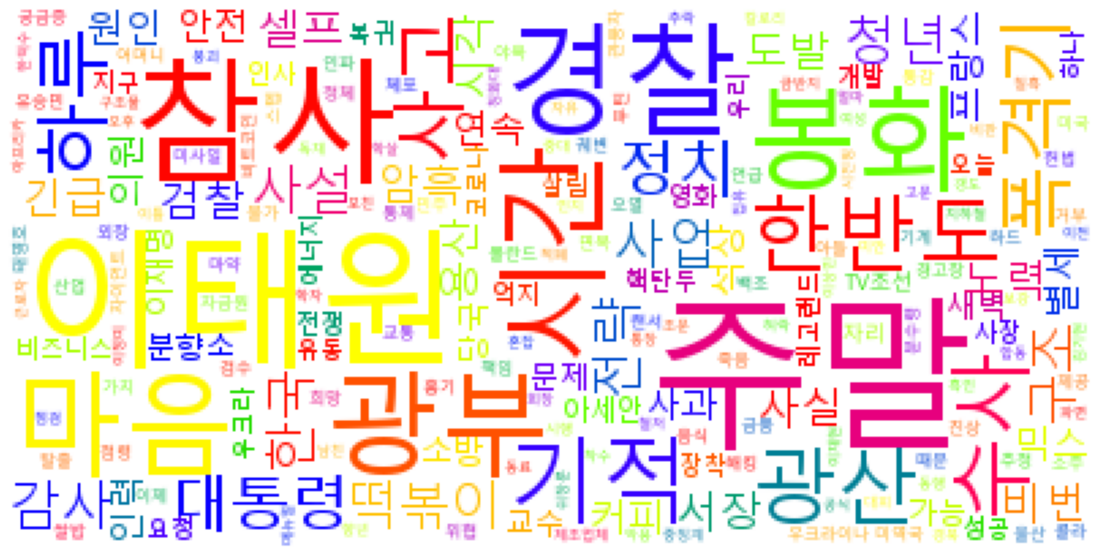

In [35]:
chosun_title_word_cloud = WordCloud(
    font_path='malgun',
    background_color='white',
    max_font_size=60,
    colormap='prism'
).generate_from_frequencies(chosun_title_counter)
plt.figure(figsize=(20, 10))
plt.imshow(chosun_title_word_cloud)
plt.axis('off')

조선일보 내용 토큰화수 딕셔너리 형태로 구하기

In [39]:
chosun_preprocessed_contents = []
for sentence in whole_chosun_content_sentence_list:
    tokenized_word = extract_noun_from_kiwi_analyzed(sentence)
    for word in tokenized_word:
        if len(word) >= 2: 
            chosun_preprocessed_contents.append(word) 
chosun_content_counter = Counter(chosun_preprocessed_contents)

(-0.5, 399.5, 199.5, -0.5)

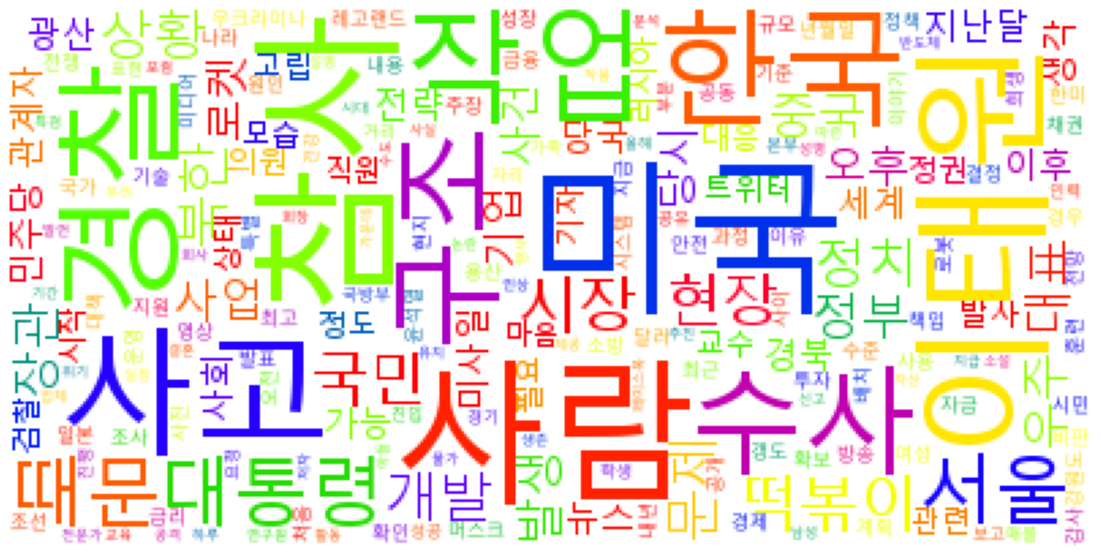

In [40]:
chosun_content_cloud = WordCloud(
    font_path='malgun',
    background_color='white',
    max_font_size=60,
    colormap='prism'
).generate_from_frequencies(chosun_content_counter)
plt.figure(figsize=(20, 10))
plt.imshow(chosun_content_cloud)
plt.axis('off')

### 한국경제의 데이터 유사성 구하기

한국경제 신문 제목 추출하기

In [41]:
whole_korean_title_noun = []
for korean_title in korean_economy_database["title"]:
    kospacing_title_list = []
    list1 = str(korean_title).split('.')
    for i in list1:
        i_1= ''
        i_1+=i
        for i_2 in i_1.split(','):
            title = ''
            title+= i_2
        kospacing_title_list.append(title)
    for title in kospacing_title_list:
        for noun in extract_noun_from_kiwi_analyzed(title):
            if len(noun) < 2:
                continue
            else:
                whole_korean_title_noun.append(noun)

url 데이터를 이용하여서 내용 추출하기

In [42]:
whole_korean_content_sentence_list = []
for korean_url in tqdm(korean_economy_database["url"]):
    headers = {"User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36"}
    try:
        response_0 = requests.get(korean_url, headers=headers)
    except OSError:
        print("OS 연결에서 응답이 되지 않습니다.")
        whole_korean_content_sentence_list.append("None")     
    else:
        soup_0 = BeautifulSoup(response_0.text, 'html.parser')
        content_0_data = soup_0.find('div', {"id" : "dic_area"})
        try:
            content_0_data = content_0_data.get_text().strip()
        except AttributeError:
            whole_korean_content_sentence_list.append("None")
        else:
            content_0_data = content_0_data.replace('\n','').replace('\t','')
            new_content_0_data = content_0_data.replace(" ", '')
            kospacing_new_content_0_data = spacing(new_content_0_data) 
            words_data = twitter.morphs(kospacing_new_content_0_data)
            with open("korean_stopwords.txt", "r", encoding="UTF-8") as stopwords:
                stopwords_list = stopwords.read().split('\n')
            new_content_1 ='' 
            for i in korean_change_no_stop_words(words_data, stopwords_list):
                new_content_1 += i
            tokenizer3_content_1 = RegexpTokenizer('[A-Za-z0-9ㄱ-ㅎ/()]+', gaps=True)
            # tokenizer3_content_2 = RegexpTokenizer('')
            # print(tokenizer3_content_1.tokenize(new_content_1))
            regular_expression_sentence = ''
            for expression in tokenizer3_content_1.tokenize(new_content_1):
                regular_expression_sentence += expression
            whole_korean_content_sentence_list.append(regular_expression_sentence)

  0%|          | 0/63 [00:00<?, ?it/s]

1/1 [==============================] - 0s 81ms/step


  2%|▏         | 1/63 [00:01<01:29,  1.44s/it]

1/1 [==============================] - 0s 79ms/step


  3%|▎         | 2/63 [00:02<01:13,  1.21s/it]

1/1 [==============================] - 0s 74ms/step


  5%|▍         | 3/63 [00:06<02:34,  2.58s/it]

1/1 [==============================] - 0s 69ms/step


  6%|▋         | 4/63 [00:08<02:06,  2.15s/it]

1/1 [==============================] - 0s 99ms/step


  8%|▊         | 5/63 [00:09<01:41,  1.76s/it]

1/1 [==============================] - 0s 72ms/step


 10%|▉         | 6/63 [00:09<01:18,  1.38s/it]

1/1 [==============================] - 0s 99ms/step


 11%|█         | 7/63 [00:11<01:14,  1.33s/it]

1/1 [==============================] - 0s 65ms/step


 13%|█▎        | 8/63 [00:11<01:04,  1.18s/it]

1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 9/63 [00:12<01:00,  1.12s/it]

1/1 [==============================] - 0s 49ms/step


 16%|█▌        | 10/63 [00:13<00:55,  1.04s/it]

1/1 [==============================] - 0s 63ms/step


 17%|█▋        | 11/63 [00:14<00:48,  1.08it/s]

1/1 [==============================] - 0s 67ms/step


 19%|█▉        | 12/63 [00:15<00:47,  1.07it/s]

1/1 [==============================] - 0s 53ms/step


 21%|██        | 13/63 [00:16<00:49,  1.01it/s]

1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 14/63 [00:17<00:43,  1.14it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 15/63 [00:17<00:41,  1.17it/s]

1/1 [==============================] - 0s 55ms/step


 25%|██▌       | 16/63 [00:18<00:36,  1.28it/s]

1/1 [==============================] - 0s 49ms/step


 27%|██▋       | 17/63 [00:18<00:30,  1.53it/s]

1/1 [==============================] - 0s 53ms/step


 29%|██▊       | 18/63 [00:20<00:35,  1.26it/s]

1/1 [==============================] - 0s 53ms/step


 30%|███       | 19/63 [00:21<00:40,  1.09it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 20/63 [00:22<00:48,  1.12s/it]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 21/63 [00:24<00:50,  1.20s/it]

1/1 [==============================] - 0s 63ms/step


 35%|███▍      | 22/63 [00:24<00:42,  1.04s/it]

1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 23/63 [00:25<00:37,  1.06it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 24/63 [00:26<00:39,  1.02s/it]

1/1 [==============================] - 0s 61ms/step


 40%|███▉      | 25/63 [00:27<00:36,  1.05it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████▏     | 26/63 [00:28<00:35,  1.03it/s]

1/1 [==============================] - 0s 56ms/step


 43%|████▎     | 27/63 [00:29<00:34,  1.04it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 28/63 [00:31<00:42,  1.23s/it]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 29/63 [00:33<00:52,  1.53s/it]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 30/63 [00:35<00:51,  1.57s/it]

1/1 [==============================] - 0s 64ms/step


 49%|████▉     | 31/63 [00:36<00:45,  1.41s/it]

1/1 [==============================] - 0s 60ms/step


 51%|█████     | 32/63 [00:36<00:36,  1.18s/it]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 33/63 [00:39<00:43,  1.46s/it]

1/1 [==============================] - 0s 64ms/step


 54%|█████▍    | 34/63 [00:42<00:55,  1.91s/it]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 35/63 [00:42<00:43,  1.55s/it]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 36/63 [00:44<00:39,  1.47s/it]

1/1 [==============================] - 0s 56ms/step


 59%|█████▊    | 37/63 [00:49<01:06,  2.58s/it]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 38/63 [00:49<00:50,  2.01s/it]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 39/63 [00:50<00:41,  1.71s/it]

1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 40/63 [00:52<00:39,  1.70s/it]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 41/63 [01:06<02:01,  5.51s/it]

1/1 [==============================] - 0s 163ms/step


 67%|██████▋   | 42/63 [01:21<02:51,  8.19s/it]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 43/63 [01:24<02:15,  6.75s/it]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 44/63 [01:28<01:50,  5.80s/it]

1/1 [==============================] - 0s 54ms/step


 71%|███████▏  | 45/63 [01:31<01:28,  4.91s/it]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 46/63 [01:39<01:40,  5.91s/it]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 47/63 [01:44<01:31,  5.74s/it]

1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 48/63 [01:50<01:25,  5.70s/it]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 49/63 [01:58<01:30,  6.50s/it]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 50/63 [02:04<01:21,  6.28s/it]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 51/63 [02:25<02:08, 10.71s/it]

1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 52/63 [02:26<01:26,  7.84s/it]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 53/63 [02:27<00:57,  5.73s/it]

1/1 [==============================] - 0s 67ms/step


 86%|████████▌ | 54/63 [02:28<00:39,  4.38s/it]

1/1 [==============================] - 0s 70ms/step


 87%|████████▋ | 55/63 [02:30<00:28,  3.52s/it]

1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 56/63 [02:31<00:19,  2.75s/it]

1/1 [==============================] - 0s 76ms/step


 90%|█████████ | 57/63 [02:32<00:14,  2.37s/it]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 58/63 [02:33<00:09,  1.92s/it]

1/1 [==============================] - 0s 82ms/step


 94%|█████████▎| 59/63 [02:35<00:07,  1.85s/it]

1/1 [==============================] - 0s 64ms/step


 95%|█████████▌| 60/63 [02:37<00:05,  1.88s/it]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 61/63 [02:38<00:03,  1.61s/it]

1/1 [==============================] - 0s 73ms/step


 98%|█████████▊| 62/63 [02:38<00:01,  1.31s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 63/63 [02:39<00:00,  2.54s/it]


한국경제 내용 추출하기

In [43]:
whole_korean_content_noun = []
for content in tqdm(whole_korean_content_sentence_list):
    if type(content) == float:
        continue
    else:
        noun_list = extract_noun_from_kiwi_analyzed(spacing(content))
        for noun in noun_list:
            if len(noun) < 2:
                continue
            else:
                whole_korean_content_noun.append(noun)

  0%|          | 0/63 [00:00<?, ?it/s]

1/1 [==============================] - 0s 219ms/step


  2%|▏         | 1/63 [00:03<03:12,  3.11s/it]

1/1 [==============================] - 0s 93ms/step


  3%|▎         | 2/63 [00:06<03:09,  3.10s/it]

1/1 [==============================] - 0s 67ms/step


  5%|▍         | 3/63 [00:13<04:58,  4.98s/it]

1/1 [==============================] - 0s 46ms/step


  6%|▋         | 4/63 [00:18<05:00,  5.10s/it]

1/1 [==============================] - 0s 53ms/step


  8%|▊         | 5/63 [00:19<03:19,  3.44s/it]

1/1 [==============================] - 0s 67ms/step


 10%|▉         | 6/63 [00:19<02:16,  2.40s/it]

1/1 [==============================] - 0s 64ms/step


 11%|█         | 7/63 [00:21<01:59,  2.14s/it]

1/1 [==============================] - 0s 62ms/step


 13%|█▎        | 8/63 [00:22<01:39,  1.81s/it]

1/1 [==============================] - 0s 59ms/step


 14%|█▍        | 9/63 [00:22<01:18,  1.45s/it]

1/1 [==============================] - 0s 58ms/step


 16%|█▌        | 10/63 [00:23<01:03,  1.19s/it]

1/1 [==============================] - 0s 61ms/step


 17%|█▋        | 11/63 [00:24<00:52,  1.02s/it]

1/1 [==============================] - 0s 61ms/step


 19%|█▉        | 12/63 [00:24<00:47,  1.07it/s]

1/1 [==============================] - 0s 64ms/step


 21%|██        | 13/63 [00:26<00:59,  1.20s/it]

1/1 [==============================] - 0s 58ms/step


 22%|██▏       | 14/63 [00:28<01:06,  1.36s/it]

1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 15/63 [00:30<01:08,  1.43s/it]

1/1 [==============================] - 0s 46ms/step


 25%|██▌       | 16/63 [00:30<00:52,  1.11s/it]

1/1 [==============================] - 0s 63ms/step


 27%|██▋       | 17/63 [00:30<00:38,  1.19it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▊       | 18/63 [00:33<01:03,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 19/63 [00:39<01:58,  2.70s/it]

1/1 [==============================] - 0s 74ms/step


 32%|███▏      | 20/63 [00:45<02:37,  3.67s/it]

1/1 [==============================] - 0s 79ms/step


 33%|███▎      | 21/63 [00:46<02:03,  2.94s/it]

1/1 [==============================] - 0s 79ms/step


 35%|███▍      | 22/63 [00:46<01:31,  2.24s/it]

1/1 [==============================] - 0s 101ms/step


 37%|███▋      | 23/63 [00:47<01:11,  1.78s/it]

1/1 [==============================] - 0s 60ms/step


 38%|███▊      | 24/63 [00:48<01:04,  1.66s/it]

1/1 [==============================] - 0s 57ms/step


 40%|███▉      | 25/63 [00:49<00:52,  1.39s/it]

1/1 [==============================] - 0s 67ms/step


 41%|████▏     | 26/63 [01:04<03:16,  5.32s/it]

1/1 [==============================] - 0s 71ms/step


 43%|████▎     | 27/63 [01:05<02:27,  4.10s/it]

1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 28/63 [01:07<01:59,  3.40s/it]

1/1 [==============================] - 0s 65ms/step


 46%|████▌     | 29/63 [01:14<02:32,  4.48s/it]

1/1 [==============================] - 0s 66ms/step


 48%|████▊     | 30/63 [01:25<03:37,  6.58s/it]

1/1 [==============================] - 0s 48ms/step


 49%|████▉     | 31/63 [01:31<03:18,  6.20s/it]

1/1 [==============================] - 0s 59ms/step


 51%|█████     | 32/63 [01:31<02:22,  4.60s/it]

1/1 [==============================] - 0s 69ms/step


 52%|█████▏    | 33/63 [01:34<01:57,  3.92s/it]

1/1 [==============================] - 0s 67ms/step


 54%|█████▍    | 34/63 [01:36<01:37,  3.35s/it]

1/1 [==============================] - 0s 75ms/step


 56%|█████▌    | 35/63 [01:36<01:10,  2.52s/it]

1/1 [==============================] - 0s 80ms/step


 57%|█████▋    | 36/63 [01:37<00:57,  2.12s/it]

1/1 [==============================] - 0s 76ms/step


 59%|█████▊    | 37/63 [01:40<01:00,  2.34s/it]

1/1 [==============================] - 0s 72ms/step


 60%|██████    | 38/63 [01:41<00:46,  1.88s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 39/63 [01:42<00:40,  1.67s/it]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 40/63 [01:53<01:42,  4.44s/it]

1/1 [==============================] - 0s 76ms/step


 65%|██████▌   | 41/63 [01:59<01:43,  4.70s/it]

1/1 [==============================] - 0s 75ms/step


 67%|██████▋   | 42/63 [01:59<01:11,  3.40s/it]

1/1 [==============================] - 0s 89ms/step


 68%|██████▊   | 43/63 [02:02<01:03,  3.18s/it]

1/1 [==============================] - 0s 71ms/step


 70%|██████▉   | 44/63 [02:04<00:54,  2.89s/it]

1/1 [==============================] - 0s 107ms/step


 71%|███████▏  | 45/63 [02:07<00:53,  3.00s/it]

1/1 [==============================] - 0s 140ms/step


 73%|███████▎  | 46/63 [02:09<00:48,  2.83s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▍  | 47/63 [02:22<01:29,  5.59s/it]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 48/63 [02:22<01:02,  4.17s/it]

1/1 [==============================] - 0s 102ms/step


 78%|███████▊  | 49/63 [02:26<00:54,  3.91s/it]

1/1 [==============================] - 0s 84ms/step


 79%|███████▉  | 50/63 [02:27<00:39,  3.07s/it]

1/1 [==============================] - 0s 91ms/step


 81%|████████  | 51/63 [02:28<00:29,  2.47s/it]

1/1 [==============================] - 0s 70ms/step


 83%|████████▎ | 52/63 [02:28<00:20,  1.89s/it]

1/1 [==============================] - 0s 66ms/step


 84%|████████▍ | 53/63 [02:29<00:14,  1.47s/it]

1/1 [==============================] - 0s 96ms/step


 86%|████████▌ | 54/63 [02:30<00:11,  1.32s/it]

1/1 [==============================] - 0s 66ms/step


 87%|████████▋ | 55/63 [02:31<00:10,  1.28s/it]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 56/63 [02:32<00:08,  1.22s/it]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 57/63 [02:33<00:06,  1.16s/it]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 58/63 [02:34<00:05,  1.07s/it]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▎| 59/63 [02:36<00:04,  1.25s/it]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 60/63 [02:38<00:04,  1.51s/it]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 61/63 [02:39<00:02,  1.30s/it]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 62/63 [02:39<00:00,  1.02it/s]

1/1 [==============================] - 0s 59ms/step


100%|██████████| 63/63 [02:40<00:00,  2.54s/it]


In [44]:
korean_title_content_vocab = list(set(whole_korean_title_noun + whole_korean_content_noun))
korean_title_content_vocab.sort()

In [46]:
# tfidf를 이용하여 제목에 대한 행렬 벡터화하기
korean_title_tfidf_result = []

# 각 문서에 대해서 아래 연산을 반복
for i in range(len(korean_economy_database["title"])):
  korean_title_tfidf_result.append([])
  try:
    d = korean_economy_database["title"][i]
  except KeyError:
    for j in range(len(korean_title_content_vocab)):
      korean_title_tfidf_result[-1].append(0)
  else:
    for j in range(len(korean_title_content_vocab)):
      t = korean_title_content_vocab[j]
      korean_title_tfidf_result[-1].append(tfidf(t, d))

# len(result)
korean_title_tfidf_ = pd.DataFrame(korean_title_tfidf_result, columns=korean_title_content_vocab, index=korean_economy_database["title"])
korean_title_tfidf_

"여개달   "월   "폐  '뼈때리  '자라투스   -대  \
title                                                                          
서울광장 분향소 '이태원 사고 사망자'→'참사 희생자' 변경            0.0  0.0  0.0   0.0    0.0  0.0   
[속보] 대우건설, 한남2구역 재개발 수주…'한남써밋' 짓는다           0.0  0.0  0.0   0.0    0.0  0.0   
빈필이 빚어낸 관(管)과 현(絃)의 '환상 하모니' 2 [송태형의 현장노트]   0.0  0.0  0.0   0.0    0.0  0.0   
돌아온 광부들, 먹고 싶은 건 "미역국과 콜라"·"소주 한 잔"          0.0  0.0  0.0   0.0    0.0  0.0   
尹 "꽃다운 청년들 지키지 못한 미안함 영원할 것"…이틀째 사과          0.0  0.0  0.0   0.0    0.0  0.0   
...                                          ...  ...  ...   ...    ...  ...   
[시론] 산업정책이 민생이다                              0.0  0.0  0.0   0.0    0.0  0.0   
[이소연의 시적인 순간] 사람에게도 '떨켜'가 있다면                0.0  0.0  0.0   0.0    0.0  0.0   
[기고] 국가경쟁력, 포괄적 전략이 필요하다                     0.0  0.0  0.0   0.0    0.0  0.0   
"모닥불로 버텼다"…광산 매몰 근로자 2명 '기적의 생환'             0.0  0.0  0.0   0.0    0.0  0.0   
[한경에세이] '아우스빌둥'이 낳은 기적                       0.0  0.0  0.0   0.0    0.0  0.0   

                                            -뫼스트  -세바스  -최고  .게티  ...   흥분  \
title                                                             ...        
서울광장 분향소 '이태원 사고 사망자'→'참사 희생자' 변경            0.0   0.0  0.0  0.0  ...  0.0   
[속보] 대우건설, 한남2구역 재개발 수주…'한남써밋' 짓는다           0.0   0.0  0.0  0.0  ...  0.0   
빈필이 빚어낸 관(管)과 현(絃)의 '환상 하모니' 2 [송태형의 현장노트]   0.0   0.0  0.0  0.0  ...  0.0   
돌아온 광부들, 먹고 싶은 건 "미역국과 콜라"·"소주 한 잔"          0.0   0.0  0.0  0.0  ...  0.0   
尹 "꽃다운 청년들 지키지 못한 미안함 영원할 것"…이틀째 사과          0.0   0.0  0.0  0.0  ...  0.0   
...                                          ...   ...  ...  ...  ...  ...   
[시론] 산업정책이 민생이다                              0.0   0.0  0.0  0.0  ...  0.0   
[이소연의 시적인 순간] 사람에게도 '떨켜'가 있다면                0.0   0.0  0.0  0.0  ...  0.0   
[기고] 국가경쟁력, 포괄적 전략이 필요하다                     0.0   0.0  0.0  0.0  ...  0.0   
"모닥불로 버텼다"…광산 매몰 근로자 2명 '기적의 생환'             0.0   0.0  0.0  0.0  ...  0.0   
[한경에세이] '아우스빌둥'이 낳은 기적                       0.0   0.0  0.0  0.0  ...  0.0   

                                             희망        희생       희생자   희토  히빠르  \
title                                                                           
서울광장 분향소 '이태원 사고 사망자'→'참사 희생자' 변경           0.0  1.386294  1.386294  0.0  0.0   
[속보] 대우건설, 한남2구역 재개발 수주…'한남써밋' 짓는다          0.0  0.000000  0.000000  0.0  0.0   
빈필이 빚어낸 관(管)과 현(絃)의 '환상 하모니' 2 [송태형의 현장노트]  0.0  0.000000  0.000000  0.0  0.0   
돌아온 광부들, 먹고 싶은 건 "미역국과 콜라"·"소주 한 잔"         0.0  0.000000  0.000000  0.0  0.0   
尹 "꽃다운 청년들 지키지 못한 미안함 영원할 것"…이틀째 사과         0.0  0.000000  0.000000  0.0  0.0   
...                                         ...       ...       ...  ...  ...   
[시론] 산업정책이 민생이다                             0.0  0.000000  0.000000  0.0  0.0   
[이소연의 시적인 순간] 사람에게도 '떨켜'가 있다면               0.0  0.000000  0.000000  0.0  0.0   
[기고] 국가경쟁력, 포괄적 전략이 필요하다                    0.0  0.000000  0.000000  0.0  0.0   
"모닥불로 버텼다"…광산 매몰 근로자 2명 '기적의 생환'            0.0  0.000000  0.000000  0.0  0.0   
[한경에세이] '아우스빌둥'이 낳은 기적                      0.0  0.000000  0.000000  0.0  0.0   

                                             히터   힌트   힐링   힙합  
title                                                           
서울광장 분향소 '이태원 사고 사망자'→'참사 희생자' 변경           0.0  0.0  0.0  0.0  
[속보] 대우건설, 한남2구역 재개발 수주…'한남써밋' 짓는다          0.0  0.0  0.0  0.0  
빈필이 빚어낸 관(管)과 현(絃)의 '환상 하모니' 2 [송태형의 현장노트]  0.0  0.0  0.0  0.0  
돌아온 광부들, 먹고 싶은 건 "미역국과 콜라"·"소주 한 잔"         0.0  0.0  0.0  0.0  
尹 "꽃다운 청년들 지키지 못한 미안함 영원할 것"…이틀째 사과         0.0  0.0  0.0  0.0  
...                                         ...  ...  ...  ...  
[시론] 산업정책이 민생이다                             0.0  0.0  0.0  0.0  
[이소연의 시적인 순간] 사람에게도 '떨켜'가 있다면               0.0  0.0  0.0  0.0  
[기고] 국가경쟁력, 포괄적 전략이 필요하다                    0.0  0.0  0.0  0.0  
"모닥불로 버텼다"…광산 매몰 근로자 2명 '기적의 생환'            0.0  0.0  0.0  0.0  
[한경에세이] '아우스빌둥'이 낳은 기적                      0.0  0.0  0.0  0.0  

[63 rows x 4062 columns]

In [47]:
# tfidf를 이용하여 한국 경제의 내용의 tfidf 구하기
korean_content_tfidf_result = []

# 각 문서에 대해서 아래 연산을 반복
for i in range(len(whole_korean_content_sentence_list)):
  korean_content_tfidf_result.append([])
  try:
    d = whole_korean_content_sentence_list[i]
  except KeyError:
    for j in range(len(korean_title_content_vocab)):
        korean_content_tfidf_result[-1].append(0)
  else:
    for j in range(len(korean_title_content_vocab)):
      t = korean_title_content_vocab[j]
      korean_content_tfidf_result[-1].append(tfidf(t, d))

# len(result)
korean_content_tfidf_ = pd.DataFrame(korean_content_tfidf_result, columns=korean_title_content_vocab, index=korean_economy_database["content"])
korean_content_tfidf_

"여개달   "월   "폐  '뼈때리  \
content                                                                    
서울시청 광장에 마련된 이태원 참사 합동분향소에 걸린 문구가 국가애도기간 마지막 날인...   0.0  0.0  0.0   0.0   
서울시 용산구 한남2구역 재개발 사업 시공사로 대우건설이 선정됐다. 한남2구역 재개발...   0.0  0.0  0.0   0.0   
브람스의 교향곡 3번 3악장을 두 달 전쯤 ‘음악이 흐르는 아침’이란 코너에 가을에 ...   0.0  0.0  0.0   0.0   
경북 봉화 아연 광산에서 매몰된 광부 2명이 221시간 만에 극적으로 생환했다. 현재...   0.0  0.0  0.0   0.0   
윤석열 대통령이 이태원 참사와 관련해 "꽃다운 청년들을 지키지 못한 미안한 마음이 영...   0.0  0.0  0.0   0.0   
...                                                  ...  ...  ...   ...   
미국 경제성장론 교과서에서 한국의 산업정책은 가장 성공적인 사례로 소개된다. 6·25...   0.0  0.0  0.0   0.0   
잎이 떨어진다. 바람이 눈에 보인다는 감각에 홀리기 좋은 가을이다. 이문재 시인은 ‘...   0.0  0.0  0.0   0.0   
작년 7월 2일 유엔무역개발회의(UNCTAD)는 한국을 개도국 지위에서 선진국 지위로...   0.0  0.0  0.0   0.0   
경북 봉화에서 광산 매몰 사고로 고립된 근로자들이 10일 만에 돌아왔다. 4일 소방 ...   0.0  0.0  0.0   0.0   
한국 고교생이 4년제 대학이나 전문대에 진학하지 않고 탄탄한 직장 생활을 시작하려면 ...   0.0  0.0  0.0   0.0   

                                                       '자라투스   -대       -뫼스트  \
content                                                                        
서울시청 광장에 마련된 이태원 참사 합동분향소에 걸린 문구가 국가애도기간 마지막 날인...  0.000000  0.0   0.000000   
서울시 용산구 한남2구역 재개발 사업 시공사로 대우건설이 선정됐다. 한남2구역 재개발...  0.000000  0.0   0.000000   
브람스의 교향곡 3번 3악장을 두 달 전쯤 ‘음악이 흐르는 아침’이란 코너에 가을에 ...  1.386294  0.0  12.476649   
경북 봉화 아연 광산에서 매몰된 광부 2명이 221시간 만에 극적으로 생환했다. 현재...  0.000000  0.0   0.000000   
윤석열 대통령이 이태원 참사와 관련해 "꽃다운 청년들을 지키지 못한 미안한 마음이 영...  0.000000  0.0   0.000000   
...                                                      ...  ...        ...   
미국 경제성장론 교과서에서 한국의 산업정책은 가장 성공적인 사례로 소개된다. 6·25...  0.000000  0.0   0.000000   
잎이 떨어진다. 바람이 눈에 보인다는 감각에 홀리기 좋은 가을이다. 이문재 시인은 ‘...  0.000000  0.0   0.000000   
작년 7월 2일 유엔무역개발회의(UNCTAD)는 한국을 개도국 지위에서 선진국 지위로...  0.000000  0.0   0.000000   
경북 봉화에서 광산 매몰 사고로 고립된 근로자들이 10일 만에 돌아왔다. 4일 소방 ...  0.000000  0.0   0.000000   
한국 고교생이 4년제 대학이나 전문대에 진학하지 않고 탄탄한 직장 생활을 시작하려면 ...  0.000000  0.0   0.000000   

                                                        -세바스  -최고  .게티  ...  \
content                                                                 ...   
서울시청 광장에 마련된 이태원 참사 합동분향소에 걸린 문구가 국가애도기간 마지막 날인...  0.000000  0.0  0.0  ...   
서울시 용산구 한남2구역 재개발 사업 시공사로 대우건설이 선정됐다. 한남2구역 재개발...  0.000000  0.0  0.0  ...   
브람스의 교향곡 3번 3악장을 두 달 전쯤 ‘음악이 흐르는 아침’이란 코너에 가을에 ...  1.386294  0.0  0.0  ...   
경북 봉화 아연 광산에서 매몰된 광부 2명이 221시간 만에 극적으로 생환했다. 현재...  0.000000  0.0  0.0  ...   
윤석열 대통령이 이태원 참사와 관련해 "꽃다운 청년들을 지키지 못한 미안한 마음이 영...  0.000000  0.0  0.0  ...   
...                                                      ...  ...  ...  ...   
미국 경제성장론 교과서에서 한국의 산업정책은 가장 성공적인 사례로 소개된다. 6·25...  0.000000  0.0  0.0  ...   
잎이 떨어진다. 바람이 눈에 보인다는 감각에 홀리기 좋은 가을이다. 이문재 시인은 ‘...  0.000000  0.0  0.0  ...   
작년 7월 2일 유엔무역개발회의(UNCTAD)는 한국을 개도국 지위에서 선진국 지위로...  0.000000  0.0  0.0  ...   
경북 봉화에서 광산 매몰 사고로 고립된 근로자들이 10일 만에 돌아왔다. 4일 소방 ...  0.000000  0.0  0.0  ...   
한국 고교생이 4년제 대학이나 전문대에 진학하지 않고 탄탄한 직장 생활을 시작하려면 ...  0.000000  0.0  0.0  ...   

                                                     흥분   희망        희생  희생자  \
content                                                                       
서울시청 광장에 마련된 이태원 참사 합동분향소에 걸린 문구가 국가애도기간 마지막 날인...  0.0  0.0  4.158883  0.0   
서울시 용산구 한남2구역 재개발 사업 시공사로 대우건설이 선정됐다. 한남2구역 재개발...  0.0  0.0  0.000000  0.0   
브람스의 교향곡 3번 3악장을 두 달 전쯤 ‘음악이 흐르는 아침’이란 코너에 가을에 ...  0.0  0.0  1.386294  0.0   
경북 봉화 아연 광산에서 매몰된 광부 2명이 221시간 만에 극적으로 생환했다. 현재...  0.0  0.0  0.000000  0.0   
윤석열 대통령이 이태원 참사와 관련해 "꽃다운 청년들을 지키지 못한 미안한 마음이 영...  0.0  0.0  4.158883  0.0   
...                                                 ...  ...       ...  ...   
미국 경제성장론 교과서에서 한국의 산업정책은 가장 성공적인 사례로 소개된다. 6·25...  0.0  0.0  0.000000  0.0   
잎이 떨어진다. 바람이 눈에 보인다는 감각에 홀리기 좋은 가을이다. 이문재 시인은 ‘...  0.0  0.0  0.000000  0.0   
작년 7월 2일 유엔무역개발회의(UNCTAD)는 한국을 개도국 지위에서 선진국 지위로...  0.0  0.0  0.000000  0.0   
경북 봉화에서 광산 매몰 사고로 고립된 근로자들이 10일 만에 돌아왔다. 4일 소방 ...  0.0  0.0  0.000000  0.0   
한국 고교생이 4년제 대학이나 전문대에 진학하지 않고 탄탄한 직장 생활을 시작하려면

한국경제 cos_similarity 유사도 구하기

In [48]:
korean_cos_sim_tfidf_ =pd.DataFrame(cosine_similar(korean_title_tfidf_.values, korean_content_tfidf_.values), index = korean_economy_database["title"])
korean_cos_sim_tfidf_

0
title                                               
서울광장 분향소 '이태원 사고 사망자'→'참사 희생자' 변경           0.020863
[속보] 대우건설, 한남2구역 재개발 수주…'한남써밋' 짓는다          0.009186
빈필이 빚어낸 관(管)과 현(絃)의 '환상 하모니' 2 [송태형의 현장노트]  0.012922
돌아온 광부들, 먹고 싶은 건 "미역국과 콜라"·"소주 한 잔"         0.012455
尹 "꽃다운 청년들 지키지 못한 미안함 영원할 것"…이틀째 사과         0.019617
...                                              ...
[시론] 산업정책이 민생이다                             0.026000
[이소연의 시적인 순간] 사람에게도 '떨켜'가 있다면               0.012767
[기고] 국가경쟁력, 포괄적 전략이 필요하다                    0.019306
"모닥불로 버텼다"…광산 매몰 근로자 2명 '기적의 생환'            0.013234
[한경에세이] '아우스빌둥'이 낳은 기적                      0.009497

[63 rows x 1 columns]

한국경제 제목 토큰화한 것 딕셔너리 형태로 만들기

In [49]:
korean_whole_title_sentence = []
for korean_title in korean_economy_database["title"]:
    kospacing_title_list = []
    list1 = str(korean_title).split('.')
    title = ''
    for i in list1:
        title+=i
    korean_whole_title_sentence.append(title)

In [50]:
korean_preprocessed_titles = []
for sentence in korean_whole_title_sentence:
    # 2개 이상의 단어 토큰화
    tokenized_word = extract_noun_from_kiwi_analyzed(sentence)
    for word in tokenized_word: 
        if len(word) >= 2: 
            korean_preprocessed_titles.append(word)
korean_title_counter = Counter(korean_preprocessed_titles)

(-0.5, 399.5, 199.5, -0.5)

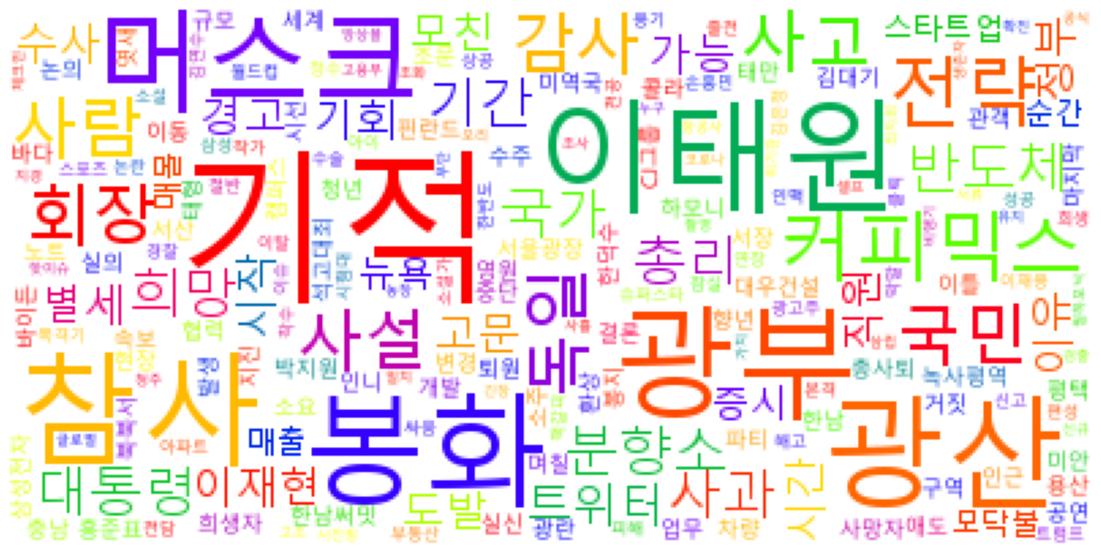

In [51]:
korean_title_word_cloud = WordCloud(
    font_path='malgun',
    background_color='white',
    max_font_size=60,
    colormap='prism'
).generate_from_frequencies(korean_title_counter)
plt.figure(figsize=(20, 10))
plt.imshow(korean_title_word_cloud)
plt.axis('off')

한국경제 내용 토큰화한 것 딕셔너리 형태로 만들기

In [53]:
korean_preprocessed_contents = []
for sentence in whole_korean_content_sentence_list:
    tokenized_word = extract_noun_from_kiwi_analyzed(sentence)
    for word in tokenized_word: 
        if len(word) > 2: 
            korean_preprocessed_contents.append(word) 
korean_content_counter = Counter(korean_preprocessed_contents)

(-0.5, 399.5, 199.5, -0.5)

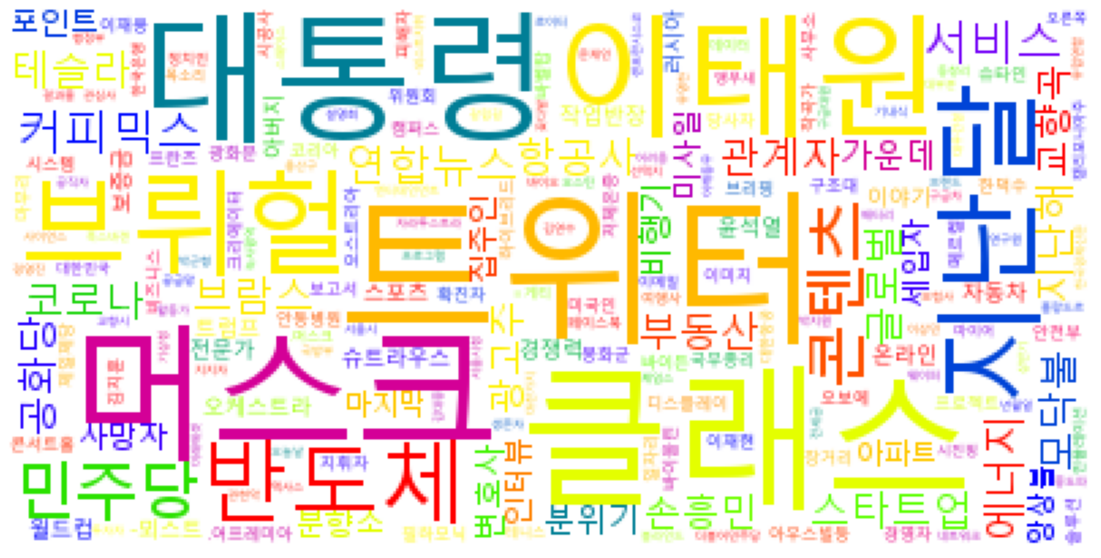

In [54]:
korean_content_cloud = WordCloud(
    font_path='malgun',
    background_color='white',
    max_font_size=60,
    colormap='prism'
).generate_from_frequencies(korean_content_counter)
plt.figure(figsize=(20, 10))
plt.imshow(korean_content_cloud)
plt.axis('off')

### 매일경제 데이터 유사성 구하기

매일경제 제목 추출하기

In [55]:
whole_mail_title_noun = []
for mail_title in mail_economy_database["title"]:
    kospacing_title_list = []
    list1 = str(mail_title).split('.')
    for i in list1:
        i_1= ''
        i_1+=i
        for i_2 in i_1.split(','):
            title = ''
            title+= i_2
        kospacing_title_list.append(title)
    for title in kospacing_title_list:
        for noun in extract_noun_from_kiwi_analyzed(title):
            if len(noun) < 3:
                continue
            else:
                whole_mail_title_noun.append(noun)

매일 경제 url를 추출하여 내용을 추출하기

In [66]:
whole_mail_content_sentence_list = []
for mail_url in tqdm(mail_economy_database["url"]):
    headers = {"User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36"}
    try:
        response_0 = requests.get(mail_url, headers=headers)
    except OSError:
        print("OS 연결에서 응답이 되지 않습니다.")
        whole_mail_content_sentence_list.append("None")     
    else:
        soup_0 = BeautifulSoup(response_0.text, 'html.parser')
        content_0_data = soup_0.find('div', {"id" : "dic_area"})
        try:
            content_0_data = content_0_data.get_text().strip()
        except AttributeError:
            whole_mail_content_sentence_list.append("None")
        else:
            content_0_data = content_0_data.replace('\n','').replace('\t','')
            new_content_0_data = content_0_data.replace(" ", '')
            kospacing_new_content_0_data = spacing(new_content_0_data) 
            words_data = twitter.morphs(kospacing_new_content_0_data)
            with open("korean_stopwords.txt", "r", encoding="UTF-8") as stopwords:
                stopwords_list = stopwords.read().split('\n')
            new_content_1 ='' 
            for i in korean_change_no_stop_words(words_data, stopwords_list):
                new_content_1 += i
            tokenizer3_content_1 = RegexpTokenizer('[A-Za-z0-9ㄱ-ㅎ/()]+', gaps=True)
            # tokenizer3_content_2 = RegexpTokenizer('')
            # print(tokenizer3_content_1.tokenize(new_content_1))
            regular_expression_sentence = ''
            for expression in tokenizer3_content_1.tokenize(new_content_1):
                regular_expression_sentence += expression
            whole_mail_content_sentence_list.append(regular_expression_sentence)

  1%|          | 1/89 [00:00<00:43,  2.04it/s]

1/1 [==============================] - 0s 57ms/step


  3%|▎         | 3/89 [00:01<00:51,  1.68it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 4/89 [00:02<01:00,  1.40it/s]

1/1 [==============================] - 0s 61ms/step


  6%|▌         | 5/89 [00:03<00:57,  1.47it/s]

1/1 [==============================] - 0s 69ms/step


  7%|▋         | 6/89 [00:05<01:26,  1.04s/it]

1/1 [==============================] - 0s 91ms/step


  8%|▊         | 7/89 [00:06<01:38,  1.21s/it]

1/1 [==============================] - 0s 60ms/step


  9%|▉         | 8/89 [00:08<01:46,  1.32s/it]

1/1 [==============================] - 0s 80ms/step


 10%|█         | 9/89 [00:09<01:47,  1.34s/it]

1/1 [==============================] - 0s 99ms/step


 13%|█▎        | 12/89 [00:11<01:05,  1.17it/s]

1/1 [==============================] - 0s 80ms/step


 15%|█▍        | 13/89 [00:12<01:02,  1.21it/s]

1/1 [==============================] - 0s 79ms/step


 16%|█▌        | 14/89 [00:14<01:17,  1.03s/it]

1/1 [==============================] - 0s 82ms/step


 17%|█▋        | 15/89 [00:16<01:35,  1.29s/it]

1/1 [==============================] - 0s 87ms/step


 18%|█▊        | 16/89 [00:16<01:23,  1.14s/it]

1/1 [==============================] - 0s 75ms/step


 19%|█▉        | 17/89 [00:17<01:20,  1.12s/it]

1/1 [==============================] - 0s 70ms/step


 20%|██        | 18/89 [00:20<01:39,  1.41s/it]

1/1 [==============================] - 0s 94ms/step


 21%|██▏       | 19/89 [00:21<01:30,  1.29s/it]

1/1 [==============================] - 0s 92ms/step


 22%|██▏       | 20/89 [00:22<01:31,  1.32s/it]

1/1 [==============================] - 0s 77ms/step


 24%|██▎       | 21/89 [00:23<01:23,  1.23s/it]

1/1 [==============================] - 0s 83ms/step


 25%|██▍       | 22/89 [00:24<01:13,  1.10s/it]

1/1 [==============================] - 0s 82ms/step


 26%|██▌       | 23/89 [00:25<01:07,  1.03s/it]

1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 24/89 [00:25<00:58,  1.10it/s]

1/1 [==============================] - 0s 73ms/step


 28%|██▊       | 25/89 [00:26<01:03,  1.00it/s]

1/1 [==============================] - 0s 80ms/step


 30%|███       | 27/89 [00:28<00:50,  1.22it/s]

1/1 [==============================] - 0s 75ms/step


 31%|███▏      | 28/89 [00:29<00:48,  1.26it/s]

1/1 [==============================] - 0s 78ms/step


 33%|███▎      | 29/89 [00:30<01:06,  1.11s/it]

1/1 [==============================] - 0s 77ms/step


 34%|███▎      | 30/89 [00:33<01:37,  1.65s/it]

1/1 [==============================] - 0s 112ms/step


 35%|███▍      | 31/89 [00:35<01:35,  1.64s/it]

1/1 [==============================] - 0s 68ms/step


 36%|███▌      | 32/89 [00:36<01:23,  1.46s/it]

1/1 [==============================] - 0s 76ms/step


 37%|███▋      | 33/89 [00:39<01:40,  1.80s/it]

1/1 [==============================] - 0s 70ms/step


 38%|███▊      | 34/89 [00:41<01:55,  2.10s/it]

1/1 [==============================] - 0s 65ms/step


 39%|███▉      | 35/89 [00:42<01:31,  1.70s/it]

1/1 [==============================] - 0s 77ms/step


 40%|████      | 36/89 [00:44<01:32,  1.75s/it]

1/1 [==============================] - 0s 66ms/step


 42%|████▏     | 37/89 [00:46<01:33,  1.79s/it]

1/1 [==============================] - 0s 73ms/step


 43%|████▎     | 38/89 [00:47<01:15,  1.49s/it]

1/1 [==============================] - 0s 67ms/step


 44%|████▍     | 39/89 [00:48<01:03,  1.28s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████▍     | 40/89 [00:49<01:10,  1.43s/it]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 42/89 [00:51<00:52,  1.11s/it]

1/1 [==============================] - 0s 65ms/step


 48%|████▊     | 43/89 [00:52<00:54,  1.19s/it]

1/1 [==============================] - 0s 84ms/step


 51%|█████     | 45/89 [00:54<00:38,  1.14it/s]

1/1 [==============================] - 0s 82ms/step


 52%|█████▏    | 46/89 [00:55<00:42,  1.02it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 47/89 [00:57<00:48,  1.16s/it]

1/1 [==============================] - 0s 71ms/step


 56%|█████▌    | 50/89 [00:58<00:26,  1.48it/s]

1/1 [==============================] - 0s 76ms/step


 58%|█████▊    | 52/89 [01:01<00:38,  1.03s/it]

1/1 [==============================] - 0s 64ms/step


 60%|█████▉    | 53/89 [01:03<00:48,  1.34s/it]

1/1 [==============================] - 0s 64ms/step


 62%|██████▏   | 55/89 [01:04<00:31,  1.08it/s]

1/1 [==============================] - 0s 89ms/step


 63%|██████▎   | 56/89 [01:05<00:28,  1.16it/s]

1/1 [==============================] - 0s 81ms/step


 64%|██████▍   | 57/89 [01:06<00:29,  1.09it/s]

1/1 [==============================] - 0s 80ms/step


 65%|██████▌   | 58/89 [01:07<00:30,  1.02it/s]

1/1 [==============================] - 0s 71ms/step


 66%|██████▋   | 59/89 [01:09<00:32,  1.10s/it]

1/1 [==============================] - 0s 69ms/step


 67%|██████▋   | 60/89 [01:12<00:55,  1.90s/it]

1/1 [==============================] - 0s 62ms/step


 69%|██████▊   | 61/89 [01:14<00:48,  1.74s/it]

1/1 [==============================] - 0s 66ms/step


 70%|██████▉   | 62/89 [01:15<00:46,  1.73s/it]

1/1 [==============================] - 0s 80ms/step


 71%|███████   | 63/89 [01:49<04:54, 11.34s/it]

1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 64/89 [02:08<05:41, 13.66s/it]

1/1 [==============================] - 0s 68ms/step


 75%|███████▌  | 67/89 [02:10<01:50,  5.02s/it]

1/1 [==============================] - 0s 61ms/step


 78%|███████▊  | 69/89 [02:17<01:29,  4.49s/it]

1/1 [==============================] - 0s 71ms/step


 81%|████████  | 72/89 [02:19<00:30,  1.81s/it]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 74/89 [02:20<00:17,  1.20s/it]

1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 75/89 [02:21<00:13,  1.02it/s]

1/1 [==============================] - 0s 74ms/step


 85%|████████▌ | 76/89 [02:22<00:15,  1.20s/it]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 80/89 [02:33<00:13,  1.51s/it]

1/1 [==============================] - 0s 65ms/step


 91%|█████████ | 81/89 [02:34<00:09,  1.20s/it]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 82/89 [02:44<00:27,  3.91s/it]

1/1 [==============================] - 0s 112ms/step


 93%|█████████▎| 83/89 [02:45<00:18,  3.02s/it]

1/1 [==============================] - 0s 75ms/step


 94%|█████████▍| 84/89 [02:47<00:13,  2.76s/it]

1/1 [==============================] - 0s 77ms/step


 96%|█████████▌| 85/89 [02:51<00:12,  3.14s/it]

1/1 [==============================] - 0s 71ms/step


 97%|█████████▋| 86/89 [02:54<00:09,  3.01s/it]

1/1 [==============================] - 0s 84ms/step


 98%|█████████▊| 87/89 [02:55<00:04,  2.37s/it]

1/1 [==============================] - 0s 115ms/step


 99%|█████████▉| 88/89 [02:56<00:01,  1.92s/it]

1/1 [==============================] - 0s 69ms/step


100%|██████████| 89/89 [02:57<00:00,  1.99s/it]


In [67]:
# 내용에 있는 단어요소 추출하기
whole_mail_content_noun = []
count = 1
for content in tqdm(whole_mail_content_sentence_list):
    if type(content) == float:
        continue
    else:
        noun_list = extract_noun_from_kiwi_analyzed(spacing(content))
        for noun in noun_list:
            if len(noun) < 2:
                continue
            else:
                whole_mail_content_noun.append(noun)

  0%|          | 0/89 [00:00<?, ?it/s]

1/1 [==============================] - 0s 90ms/step


  1%|          | 1/89 [00:00<00:17,  5.15it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 2/89 [00:17<15:16, 10.54s/it]

1/1 [==============================] - 0s 58ms/step


  3%|▎         | 3/89 [00:23<11:32,  8.05s/it]

1/1 [==============================] - 0s 70ms/step


  4%|▍         | 4/89 [00:24<07:37,  5.38s/it]

1/1 [==============================] - 0s 80ms/step


  6%|▌         | 5/89 [00:29<07:37,  5.45s/it]

1/1 [==============================] - 0s 77ms/step


  7%|▋         | 6/89 [00:36<07:53,  5.70s/it]

1/1 [==============================] - 0s 114ms/step


  8%|▊         | 7/89 [00:42<07:53,  5.77s/it]

1/1 [==============================] - 0s 89ms/step


  9%|▉         | 8/89 [00:47<07:52,  5.83s/it]

1/1 [==============================] - 0s 78ms/step


 10%|█         | 9/89 [00:49<05:48,  4.35s/it]

1/1 [==============================] - 0s 73ms/step


 11%|█         | 10/89 [00:54<06:19,  4.81s/it]

1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 11/89 [00:59<06:18,  4.85s/it]

1/1 [==============================] - 0s 81ms/step


 13%|█▎        | 12/89 [01:00<04:23,  3.43s/it]

1/1 [==============================] - 0s 111ms/step


 15%|█▍        | 13/89 [01:00<03:21,  2.65s/it]

1/1 [==============================] - 0s 81ms/step


 16%|█▌        | 14/89 [01:02<02:53,  2.32s/it]

1/1 [==============================] - 0s 131ms/step


 17%|█▋        | 15/89 [01:09<04:43,  3.83s/it]

1/1 [==============================] - 0s 81ms/step


 18%|█▊        | 16/89 [01:10<03:31,  2.89s/it]

1/1 [==============================] - 0s 85ms/step


 19%|█▉        | 17/89 [01:11<02:43,  2.26s/it]

1/1 [==============================] - 0s 154ms/step


 20%|██        | 18/89 [01:18<04:28,  3.77s/it]

1/1 [==============================] - 0s 64ms/step


 21%|██▏       | 19/89 [01:19<03:18,  2.83s/it]

1/1 [==============================] - 0s 71ms/step


 22%|██▏       | 20/89 [01:20<02:38,  2.30s/it]

1/1 [==============================] - 0s 67ms/step


 24%|██▎       | 21/89 [01:21<02:17,  2.03s/it]

1/1 [==============================] - 0s 62ms/step


 25%|██▍       | 22/89 [01:22<01:49,  1.64s/it]

1/1 [==============================] - 0s 79ms/step


 26%|██▌       | 23/89 [01:23<01:27,  1.33s/it]

1/1 [==============================] - 0s 70ms/step


 27%|██▋       | 24/89 [01:23<01:09,  1.07s/it]

1/1 [==============================] - 0s 89ms/step


 28%|██▊       | 25/89 [01:24<01:05,  1.03s/it]

1/1 [==============================] - 0s 94ms/step


 29%|██▉       | 26/89 [01:25<01:01,  1.02it/s]

1/1 [==============================] - 0s 109ms/step


 30%|███       | 27/89 [01:25<00:47,  1.31it/s]

1/1 [==============================] - 0s 83ms/step


 31%|███▏      | 28/89 [01:26<00:49,  1.23it/s]

1/1 [==============================] - 0s 62ms/step


 33%|███▎      | 29/89 [01:32<02:17,  2.30s/it]

1/1 [==============================] - 0s 45ms/step


 34%|███▎      | 30/89 [01:33<02:02,  2.08s/it]

1/1 [==============================] - 0s 55ms/step


 35%|███▍      | 31/89 [01:34<01:40,  1.74s/it]

1/1 [==============================] - 0s 83ms/step


 36%|███▌      | 32/89 [01:35<01:19,  1.39s/it]

1/1 [==============================] - 0s 67ms/step


 37%|███▋      | 33/89 [01:37<01:25,  1.53s/it]

1/1 [==============================] - 0s 74ms/step


 38%|███▊      | 34/89 [01:39<01:36,  1.76s/it]

1/1 [==============================] - 0s 58ms/step


 39%|███▉      | 35/89 [01:39<01:12,  1.34s/it]

1/1 [==============================] - 0s 69ms/step


 40%|████      | 36/89 [01:40<01:08,  1.28s/it]

1/1 [==============================] - 0s 74ms/step


 42%|████▏     | 37/89 [01:42<01:05,  1.26s/it]

1/1 [==============================] - 0s 98ms/step


 43%|████▎     | 38/89 [01:42<00:54,  1.07s/it]

1/1 [==============================] - 0s 95ms/step


 44%|████▍     | 39/89 [01:43<00:46,  1.07it/s]

1/1 [==============================] - 0s 89ms/step


 45%|████▍     | 40/89 [01:44<00:53,  1.09s/it]

1/1 [==============================] - 0s 93ms/step


 46%|████▌     | 41/89 [01:45<00:51,  1.06s/it]

1/1 [==============================] - 0s 90ms/step


 47%|████▋     | 42/89 [01:46<00:37,  1.25it/s]

1/1 [==============================] - 0s 72ms/step


 48%|████▊     | 43/89 [01:47<00:38,  1.18it/s]

1/1 [==============================] - 0s 82ms/step


 49%|████▉     | 44/89 [01:47<00:32,  1.40it/s]

1/1 [==============================] - 0s 77ms/step


 51%|█████     | 45/89 [01:47<00:24,  1.79it/s]

1/1 [==============================] - 0s 88ms/step


 52%|█████▏    | 46/89 [01:48<00:30,  1.43it/s]

1/1 [==============================] - 0s 114ms/step


 53%|█████▎    | 47/89 [01:49<00:34,  1.22it/s]

1/1 [==============================] - 0s 78ms/step


 54%|█████▍    | 48/89 [01:50<00:28,  1.43it/s]

1/1 [==============================] - 0s 74ms/step


 55%|█████▌    | 49/89 [01:50<00:21,  1.83it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████▌    | 50/89 [01:50<00:17,  2.24it/s]

1/1 [==============================] - 0s 88ms/step


 57%|█████▋    | 51/89 [01:52<00:37,  1.02it/s]

1/1 [==============================] - 0s 70ms/step


 58%|█████▊    | 52/89 [01:53<00:28,  1.31it/s]

1/1 [==============================] - 0s 56ms/step


 60%|█████▉    | 53/89 [01:55<00:42,  1.17s/it]

1/1 [==============================] - 0s 61ms/step


 61%|██████    | 54/89 [01:55<00:32,  1.08it/s]

1/1 [==============================] - 0s 77ms/step


 62%|██████▏   | 55/89 [01:55<00:24,  1.42it/s]

1/1 [==============================] - 0s 89ms/step


 63%|██████▎   | 56/89 [01:56<00:22,  1.46it/s]

1/1 [==============================] - 0s 69ms/step


 64%|██████▍   | 57/89 [01:57<00:23,  1.34it/s]

1/1 [==============================] - 0s 68ms/step


 65%|██████▌   | 58/89 [01:58<00:24,  1.26it/s]

1/1 [==============================] - 0s 94ms/step


 66%|██████▋   | 59/89 [01:59<00:27,  1.11it/s]

1/1 [==============================] - 0s 83ms/step


 67%|██████▋   | 60/89 [02:02<00:48,  1.66s/it]

1/1 [==============================] - 0s 74ms/step


 69%|██████▊   | 61/89 [02:03<00:40,  1.45s/it]

1/1 [==============================] - 0s 59ms/step


 70%|██████▉   | 62/89 [02:05<00:40,  1.50s/it]

1/1 [==============================] - 0s 70ms/step


 71%|███████   | 63/89 [02:10<01:04,  2.47s/it]

1/1 [==============================] - 0s 88ms/step


 72%|███████▏  | 64/89 [02:12<01:01,  2.44s/it]

1/1 [==============================] - 0s 65ms/step


 73%|███████▎  | 65/89 [02:18<01:22,  3.44s/it]

1/1 [==============================] - 0s 68ms/step


 74%|███████▍  | 66/89 [02:18<00:56,  2.46s/it]

1/1 [==============================] - 0s 68ms/step


 75%|███████▌  | 67/89 [02:18<00:39,  1.78s/it]

1/1 [==============================] - 0s 71ms/step


 76%|███████▋  | 68/89 [02:21<00:45,  2.18s/it]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 69/89 [02:21<00:31,  1.55s/it]

1/1 [==============================] - 0s 50ms/step


 79%|███████▊  | 70/89 [02:22<00:22,  1.19s/it]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 71/89 [02:22<00:16,  1.11it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 72/89 [02:22<00:11,  1.51it/s]

1/1 [==============================] - 0s 94ms/step


 82%|████████▏ | 73/89 [02:23<00:12,  1.32it/s]

1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 74/89 [02:23<00:08,  1.74it/s]

1/1 [==============================] - 0s 61ms/step


 84%|████████▍ | 75/89 [02:24<00:07,  1.87it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▌ | 76/89 [02:25<00:11,  1.11it/s]

1/1 [==============================] - 0s 73ms/step


 87%|████████▋ | 77/89 [02:26<00:10,  1.14it/s]

1/1 [==============================] - 0s 78ms/step


 88%|████████▊ | 78/89 [02:26<00:07,  1.49it/s]

1/1 [==============================] - 0s 69ms/step


 89%|████████▉ | 79/89 [02:26<00:05,  1.95it/s]

1/1 [==============================] - 0s 69ms/step


 90%|████████▉ | 80/89 [02:27<00:03,  2.47it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 81/89 [02:27<00:03,  2.39it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 82/89 [02:29<00:05,  1.32it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 83/89 [02:29<00:04,  1.42it/s]

1/1 [==============================] - 0s 99ms/step


 94%|█████████▍| 84/89 [02:31<00:05,  1.07s/it]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▌| 85/89 [03:06<00:44, 11.12s/it]

1/1 [==============================] - 0s 64ms/step


 97%|█████████▋| 86/89 [03:08<00:25,  8.48s/it]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 87/89 [03:08<00:12,  6.10s/it]

1/1 [==============================] - 0s 93ms/step


 99%|█████████▉| 88/89 [03:09<00:04,  4.44s/it]

1/1 [==============================] - 0s 64ms/step


100%|██████████| 89/89 [03:10<00:00,  2.14s/it]


In [68]:
mail_title_content_vocab = list(set(whole_mail_title_noun + whole_mail_content_noun))
mail_title_content_vocab.sort()

In [69]:
# 매일경제 제목 tfidf 결과 구하기
mail_title_tfidf_result = []

# 각 문서에 대해서 아래 연산을 반복
for i in range(len(mail_economy_database["title"])):
  mail_title_tfidf_result.append([])
  try:
    d = mail_economy_database["title"][i]
  except KeyError:
    for j in range(len(mail_title_content_vocab)):
      mail_title_tfidf_result[-1].append(0)
  else:
    for j in range(len(mail_title_content_vocab)):
      t = mail_title_content_vocab[j]
      mail_title_tfidf_result[-1].append(tfidf(t, d))

# len(result)
mail_title_tfidf_ = pd.DataFrame(mail_title_tfidf_result, columns=mail_title_content_vocab, index=mail_economy_database["title"])
mail_title_tfidf_

-랜서  -메뉴   .곳   .광   .구   .극  \
title                                                                        
홍석천, 독일 대통령 내외 만났다 “다름에 대한 깊은 대화”             0.0  0.0  0.0  0.0  0.0  0.0   
“501명 희생 ‘삼풍참사’ 때 뭘 배웠나”…이태원 참사 꼬집은 美언론       0.0  0.0  0.0  0.0  0.0  0.0   
B.A.P 출신 힘찬, 12월 추가 강제추행 혐의 공판                0.0  0.0  0.0  0.0  0.0  0.0   
[속보] ‘7900억’ 재개발 최대어 한남2구역 대우건설 품으로           0.0  0.0  0.0  0.0  0.0  0.0   
尹 대통령 “꽃다운 청년들 지켜주지 못해 미안한 마음”                0.0  0.0  0.0  0.0  0.0  0.0   
...                                           ...  ...  ...  ...  ...  ...   
해외 부동산 ‘차이나 머니’ 공습...시진핑 3기 더 거세지나[한중일 톺아보기]  0.0  0.0  0.0  0.0  0.0  0.0   
해외여행 ‘1순위’ 일본, 가을·겨울 추천여행지 4                  0.0  0.0  0.0  0.0  0.0  0.0   
“커피믹스를 밥처럼”…봉화 광산 매몰 2명, ‘희망 끈’ 놓지 않아         0.0  0.0  0.0  0.0  0.0  0.0   
봉화 광산 고립자 2명 생환에 尹 “기적 같은 일”                  0.0  0.0  0.0  0.0  0.0  0.0   
북한 외무성 “자주권 침해에 초강력 대응…미국은 경거망동 말라”           0.0  0.0  0.0  0.0  0.0  0.0   

                                               .낮  .내부   .년   .대  ...   흡수  \
title                                                             ...        
홍석천, 독일 대통령 내외 만났다 “다름에 대한 깊은 대화”             0.0  0.0  0.0  0.0  ...  0.0   
“501명 희생 ‘삼풍참사’ 때 뭘 배웠나”…이태원 참사 꼬집은 美언론       0.0  0.0  0.0  0.0  ...  0.0   
B.A.P 출신 힘찬, 12월 추가 강제추행 혐의 공판                0.0  0.0  0.0  0.0  ...  0.0   
[속보] ‘7900억’ 재개발 최대어 한남2구역 대우건설 품으로           0.0  0.0  0.0  0.0  ...  0.0   
尹 대통령 “꽃다운 청년들 지켜주지 못해 미안한 마음”                0.0  0.0  0.0  0.0  ...  0.0   
...                                           ...  ...  ...  ...  ...  ...   
해외 부동산 ‘차이나 머니’ 공습...시진핑 3기 더 거세지나[한중일 톺아보기]  0.0  0.0  0.0  0.0  ...  0.0   
해외여행 ‘1순위’ 일본, 가을·겨울 추천여행지 4                  0.0  0.0  0.0  0.0  ...  0.0   
“커피믹스를 밥처럼”…봉화 광산 매몰 2명, ‘희망 끈’ 놓지 않아         0.0  0.0  0.0  0.0  ...  0.0   
봉화 광산 고립자 2명 생환에 尹 “기적 같은 일”                  0.0  0.0  0.0  0.0  ...  0.0   
북한 외무성 “자주권 침해에 초강력 대응…미국은 경거망동 말라”           0.0  0.0  0.0  0.0  ...  0.0   

                                               흥미        희망        희생  희생자  \
title                                                                        
홍석천, 독일 대통령 내외 만났다 “다름에 대한 깊은 대화”             0.0  0.000000  0.000000  0.0   
“501명 희생 ‘삼풍참사’ 때 뭘 배웠나”…이태원 참사 꼬집은 美언론       0.0  0.000000  0.000000  0.0   
B.A.P 출신 힘찬, 12월 추가 강제추행 혐의 공판                0.0  0.000000  1.386294  0.0   
[속보] ‘7900억’ 재개발 최대어 한남2구역 대우건설 품으로           0.0  0.000000  0.000000  0.0   
尹 대통령 “꽃다운 청년들 지켜주지 못해 미안한 마음”                0.0  0.000000  0.000000  0.0   
...                                           ...       ...       ...  ...   
해외 부동산 ‘차이나 머니’ 공습...시진핑 3기 더 거세지나[한중일 톺아보기]  0.0  0.000000  0.000000  0.0   
해외여행 ‘1순위’ 일본, 가을·겨울 추천여행지 4                  0.0  0.000000  0.000000  0.0   
“커피믹스를 밥처럼”…봉화 광산 매몰 2명, ‘희망 끈’ 놓지 않아         0.0  0.000000  0.000000  0.0   
봉화 광산 고립자 2명 생환에 尹 “기적 같은 일”                  0.0  0.000000  0.000000  0.0   
북한 외무성 “자주권 침해에 초강력 대응…미국은 경거망동 말라”           0.0  1.386294  0.000000  0.0   

                                               흰색  히가시야마  히스토리   힐튼  힘전봉민  
title                                                                      
홍석천, 독일 대통령 내외 만났다 “다름에 대한 깊은 대화”             0.0    0.0   0.0  0.0   0.0  
“501명 희생 ‘삼풍참사’ 때 뭘 배웠나”…이태원 참사 꼬집은 美언론       0.0    0.0   0.0  0.0   0.0  
B.A.P 출신 힘찬, 12월 추가 강제추행 혐의 공판                0.0    0.0   0.0  0.0   0.0  
[속보] ‘7900억’ 재개발 최대어 한남2구역 대우건설 품으로           0.0    0.0   0.0  0.0   0.0  
尹 대통령 “꽃다운 청년들 지켜주지 못해 미안한 마음”                0.0    0.0   0.0  0.0   0.0  
...                                           ...    ...   ...  ...   ...  
해외 부동산 ‘차이나 머니’ 공습...시진핑 3기 더 거세지나[한중일 톺아보기]  0.0    0.0   0.0  0.0   0.0  
해외여행 ‘1순위’ 일본, 가을·겨울 추천여행지 4                  0.0    0.0   0.0  0.0   0.0  
“커피믹스를 밥처럼”…봉화 광산 매몰 2명, ‘희망 끈’ 놓지 않아         0.0    0.0   0.0  0.0   0.0  
봉화 광산 고립자 2명 생환에 尹 “기적 같은 일”                  0.0    0.0   0.0  0.0   0.0  
북한 외무성 “자주권 침해에 초강력 대응…미국은 경거망동 말라”           0.0    0.0   0.0  0.0   0.0  

[89 rows x 4

In [70]:
mail_content_tfidf_result = []

# 각 문서에 대해서 아래 연산을 반복
for i in range(len(whole_mail_content_sentence_list)):
  mail_content_tfidf_result.append([])
  try:
    d = whole_mail_content_sentence_list[i]
  except KeyError:
    for j in range(len(mail_title_content_vocab)):
      mail_content_tfidf_result[-1].append(0)
  else:
    for j in range(len(mail_title_content_vocab)):
      t = mail_title_content_vocab[j]
      mail_content_tfidf_result[-1].append(tfidf(t, d))

# len(result)
mail_content_tfidf_ = pd.DataFrame(mail_content_tfidf_result, columns=mail_title_content_vocab, index=mail_economy_database["content"])
mail_content_tfidf_

-랜서  -메뉴   .곳   .광   .구  \
content                                                                       
방송인 홍석천이 독일 대통령 내외를 만났다. 홍석천은 5일 자신의 SNS에 “어젯밤 ...  0.0  0.0  0.0  0.0  0.0   
삼풍 때와 이태원 참사 비슷 한 상황 한국 매력 있지만 이에 걸 맞는 책임감 부족 미...  0.0  0.0  0.0  0.0  0.0   
그룹 B.A.P 출신 힘찬의 구설은 언제쯤 끝날까. 힘찬의 추가 강제추행 혐의 재판일...  0.0  0.0  0.0  0.0  0.0   
대우건설이 올 하반기 재개발 최대어로 손꼽히는 한남2구역 시공권을 손에 넣었다. 한남...  0.0  0.0  0.0  0.0  0.0   
한국교회 이태원 참사 위로예배 참석 윤석열 대통령은 5일 이태원 참사와 관련해 “마음...  0.0  0.0  0.0  0.0  0.0   
...                                                 ...  ...  ...  ...  ...   
#베이징 출신으로 일본에 거주하고 있는 중국인 왕씨. 그는 건물을 매입해 호텔 등 숙...  0.0  0.0  0.0  0.0  0.0   
코로나 엔데믹, 그러니까 주기적 유행으로 접어들면서 해외여행에 대한 관심과 수요가 부...  0.0  0.0  0.0  0.0  0.0   
경북 봉화군 아연 광산 매물사고로 고립됐다 9일만에 구조된 노동자 2명은 가지고 있던...  0.0  0.0  0.0  0.0  0.0   
사고 발생 221시간만에 갱도 탈출 윤석열 대통령이 경북 봉화군 광산 매몰사고로 고립...  0.0  0.0  0.0  0.0  0.0   
북한이 4일 한미 연합공중훈련 ‘비질런트 스톰’(Vigilant Storm)이 연장된...  0.0  0.0  0.0  0.0  0.0   

                                                     .극   .낮  .내부        .년  \
content                                                                       
방송인 홍석천이 독일 대통령 내외를 만났다. 홍석천은 5일 자신의 SNS에 “어젯밤 ...  0.0  0.0  0.0  0.000000   
삼풍 때와 이태원 참사 비슷 한 상황 한국 매력 있지만 이에 걸 맞는 책임감 부족 미...  0.0  0.0  0.0  0.000000   
그룹 B.A.P 출신 힘찬의 구설은 언제쯤 끝날까. 힘찬의 추가 강제추행 혐의 재판일...  0.0  0.0  0.0  0.000000   
대우건설이 올 하반기 재개발 최대어로 손꼽히는 한남2구역 시공권을 손에 넣었다. 한남...  0.0  0.0  0.0  0.000000   
한국교회 이태원 참사 위로예배 참석 윤석열 대통령은 5일 이태원 참사와 관련해 “마음...  0.0  0.0  0.0  0.000000   
...                                                 ...  ...  ...       ...   
#베이징 출신으로 일본에 거주하고 있는 중국인 왕씨. 그는 건물을 매입해 호텔 등 숙...  0.0  0.0  0.0  5.545177   
코로나 엔데믹, 그러니까 주기적 유행으로 접어들면서 해외여행에 대한 관심과 수요가 부...  0.0  0.0  0.0  0.000000   
경북 봉화군 아연 광산 매물사고로 고립됐다 9일만에 구조된 노동자 2명은 가지고 있던...  0.0  0.0  0.0  0.000000   
사고 발생 221시간만에 갱도 탈출 윤석열 대통령이 경북 봉화군 광산 매몰사고로 고립...  0.0  0.0  0.0  0.000000   
북한이 4일 한미 연합공중훈련 ‘비질런트 스톰’(Vigilant Storm)이 연장된...  0.0  0.0  0.0  0.000000   

                                                          .대  ...   흡수   흥미  \
content                                                       ...             
방송인 홍석천이 독일 대통령 내외를 만났다. 홍석천은 5일 자신의 SNS에 “어젯밤 ...  0.000000  ...  0.0  0.0   
삼풍 때와 이태원 참사 비슷 한 상황 한국 매력 있지만 이에 걸 맞는 책임감 부족 미...  1.386294  ...  0.0  0.0   
그룹 B.A.P 출신 힘찬의 구설은 언제쯤 끝날까. 힘찬의 추가 강제추행 혐의 재판일...  0.000000  ...  0.0  0.0   
대우건설이 올 하반기 재개발 최대어로 손꼽히는 한남2구역 시공권을 손에 넣었다. 한남...  4.158883  ...  0.0  0.0   
한국교회 이태원 참사 위로예배 참석 윤석열 대통령은 5일 이태원 참사와 관련해 “마음...  0.000000  ...  0.0  0.0   
...                                                      ...  ...  ...  ...   
#베이징 출신으로 일본에 거주하고 있는 중국인 왕씨. 그는 건물을 매입해 호텔 등 숙...  2.772589  ...  0.0  0.0   
코로나 엔데믹, 그러니까 주기적 유행으로 접어들면서 해외여행에 대한 관심과 수요가 부...  1.386294  ...  0.0  0.0   
경북 봉화군 아연 광산 매물사고로 고립됐다 9일만에 구조된 노동자 2명은 가지고 있던...  0.000000  ...  0.0  0.0   
사고 발생 221시간만에 갱도 탈출 윤석열 대통령이 경북 봉화군 광산 매몰사고로 고립...  0.000000  ...  0.0  0.0   
북한이 4일 한미 연합공중훈련 ‘비질런트 스톰’(Vigilant Storm)이 연장된...  0.000000  ...  0.0  0.0   

                                                          희망        희생  희생자  \
content                                                                       
방송인 홍석천이 독일 대통령 내외를 만났다. 홍석천은 5일 자신의 SNS에 “어젯밤 ...  0.000000  0.000000  0.0   
삼풍 때와 이태원 참사 비슷 한 상황 한국 매력 있지만 이에 걸 맞는 책임감 부족 미...  0.000000  2.772589  0.0   
그룹 B.A.P 출신 힘찬의 구설은 언제쯤 끝날까. 힘찬의 추가 강제추행 혐의 재판일...  0.000000  0.000000  0.0   
대우건설이 올 하반기 재개발 최대어로 손꼽히는 한남2구역 시공권을 손에 넣었다. 한남...  0.000000  0.000000  0.0   
한국교회 이태원 참사 위로예배 참석 윤석열 대통령은 5일 이태원 참사와 관련해 “마음...  0.000000  1.386294  0.0   
...                                                      ...       ...  ...   
#베이징 출신으로 일본에 거주하고 있는 중국인 왕씨. 그는 건물을 매입해 호텔 등 숙...  0.000000  0.000000  0.0   
코로나 엔데믹, 그러니까 주기적 유행으로 접어들면서 해외여행에 대한 관심과 수요가 부...  0.000000  0.000000  0.0   
경북 봉화군 아연 광산 매물사고로 고립됐다 9일만에 구조된 노동자 2명은 가지고 있던...  1.386294  0.000000  0.0   
사고 발생 221시간만에 갱도 탈출 윤석열 대통령이 경북 봉화군 광산 매몰사고로 고립...  0.000000  0.000000  0.0   
북한이 4일 한미 연합공중훈련 ‘비질

매일경제 cos_sim 유사성 구하기

In [71]:
mail_cos_sim_tfidf_ =pd.DataFrame(cosine_similar(mail_title_tfidf_.values, mail_content_tfidf_.values), index = mail_economy_database["title"])
mail_cos_sim_tfidf_

0
title                                                 
홍석천, 독일 대통령 내외 만났다 “다름에 대한 깊은 대화”             0.000000
“501명 희생 ‘삼풍참사’ 때 뭘 배웠나”…이태원 참사 꼬집은 美언론       0.029123
B.A.P 출신 힘찬, 12월 추가 강제추행 혐의 공판                0.000000
[속보] ‘7900억’ 재개발 최대어 한남2구역 대우건설 품으로           0.014871
尹 대통령 “꽃다운 청년들 지켜주지 못해 미안한 마음”                0.029897
...                                                ...
해외 부동산 ‘차이나 머니’ 공습...시진핑 3기 더 거세지나[한중일 톺아보기]  0.036559
해외여행 ‘1순위’ 일본, 가을·겨울 추천여행지 4                  0.025529
“커피믹스를 밥처럼”…봉화 광산 매몰 2명, ‘희망 끈’ 놓지 않아         0.009914
봉화 광산 고립자 2명 생환에 尹 “기적 같은 일”                  0.013880
북한 외무성 “자주권 침해에 초강력 대응…미국은 경거망동 말라”           0.007188

[89 rows x 1 columns]

In [72]:
mail_whole_title_sentence = []
for mail_title in mail_economy_database["title"]:
    kospacing_title_list = []
    list1 = str(mail_title).split('.')
    title = ''
    for i in list1:
        title+=i
    mail_whole_title_sentence.append(title)

매일경제 제목을 토큰화하여 딕셔너리 형태로 바꾸기, 그리고 이를 시각화하기

In [73]:
mail_preprocessed_titles = []
for sentence in mail_whole_title_sentence:
    # 제목에 있는 단어 토큰화
    tokenized_word = extract_noun_from_kiwi_analyzed(sentence)
    for word in tokenized_word: 
        if len(word) >= 2: 
            mail_preprocessed_titles.append(word)
mail_title_counter = Counter(mail_preprocessed_titles)

(-0.5, 399.5, 199.5, -0.5)

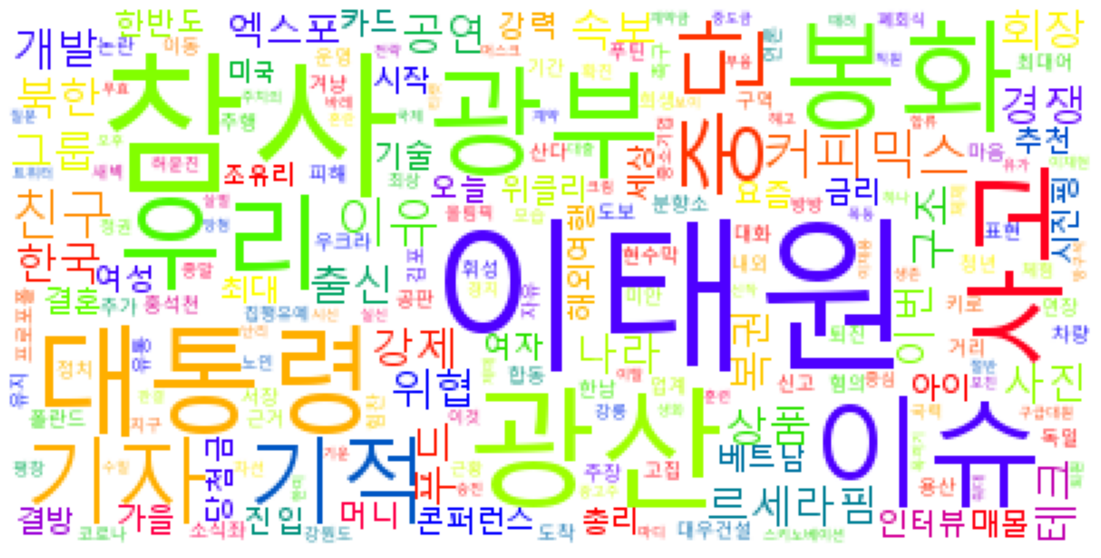

In [74]:
mail_title_word_cloud = WordCloud(
    font_path='malgun',
    background_color='white',
    max_font_size=60,
    colormap='prism'
).generate_from_frequencies(mail_title_counter)
plt.figure(figsize=(20, 10))
plt.imshow(mail_title_word_cloud)
plt.axis('off')

매일경제 내용을 토큰화하여 딕셔너리형태로 만들기

In [77]:
mail_preprocessed_contents = []
for sentence in whole_mail_content_sentence_list:
    tokenized_word = extract_noun_from_kiwi_analyzed(sentence)
    for word in tokenized_word: 
        if len(word) >= 2: 
            mail_preprocessed_contents.append(word) 
mail_content_counter = Counter(mail_preprocessed_contents)

(-0.5, 399.5, 199.5, -0.5)

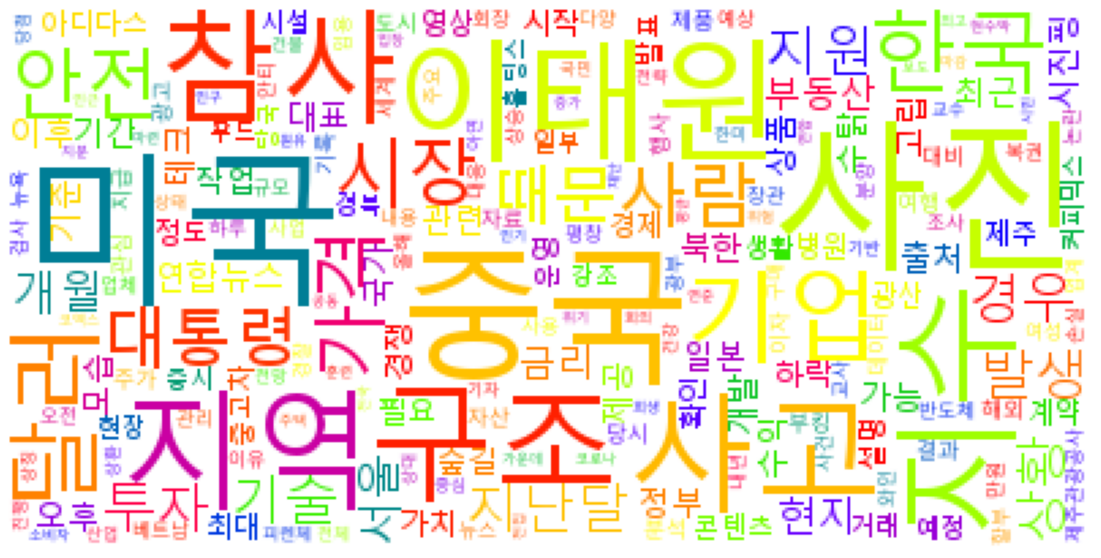

In [78]:
mail_content_cloud = WordCloud(
    font_path='malgun',
    background_color='white',
    max_font_size=60,
    colormap='prism'
).generate_from_frequencies(mail_content_counter)
plt.figure(figsize=(20, 10))
plt.imshow(mail_content_cloud)
plt.axis('off')

### 중앙일보의 데이터 유사성 구하기

중앙일보 제목 추출하기

In [79]:
whole_middle_title_noun = []
for middle_title in midlle_eilbo_database["title"]:
    kospacing_title_list = []
    list1 = str(middle_title).split('.')
    for i in list1:
        i_1= ''
        i_1+=i
        for i_2 in i_1.split(','):
            title = ''
            title+= i_2
        kospacing_title_list.append(title)
    for title in kospacing_title_list:
        for noun in extract_noun_from_kiwi_analyzed(title):
            if len(noun) < 3:
                continue
            else:
                whole_middle_title_noun.append(noun)

url 데이터를 이용하여서 내용 추출하기

In [81]:
whole_middle_content_sentence_list = []
for middle_url in tqdm(middle_eilbo_database["url"]):
    headers = {"User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36"}
    try:
        response_0 = requests.get(middle_url, headers=headers)
    except OSError:
        print("OS 연결에서 응답이 되지 않습니다.")
        whole_mail_content_sentence_list.append("None")     
    else:
        soup_0 = BeautifulSoup(response_0.text, 'html.parser')
        content_0_data = soup_0.find('div', {"id" : "dic_area"})
        try:
            content_0_data = content_0_data.get_text().strip()
        except AttributeError:
            whole_middle_content_sentence_list.append("None")
        else:
            content_0_data = content_0_data.replace('\n','').replace('\t','')
            new_content_0_data = content_0_data.replace(" ", '')
            kospacing_new_content_0_data = spacing(new_content_0_data) 
            words_data = twitter.morphs(kospacing_new_content_0_data)
            with open("korean_stopwords.txt", "r", encoding="UTF-8") as stopwords:
                stopwords_list = stopwords.read().split('\n')
            new_content_1 ='' 
            for i in korean_change_no_stop_words(words_data, stopwords_list):
                new_content_1 += i
            tokenizer3_content_1 = RegexpTokenizer('[A-Za-z0-9ㄱ-ㅎ/()]+', gaps=True)
            # tokenizer3_content_2 = RegexpTokenizer('')
            # print(tokenizer3_content_1.tokenize(new_content_1))
            regular_expression_sentence = ''
            for expression in tokenizer3_content_1.tokenize(new_content_1):
                regular_expression_sentence += expression
            whole_middle_content_sentence_list.append(regular_expression_sentence)

  0%|          | 0/51 [00:00<?, ?it/s]

1/1 [==============================] - 0s 82ms/step


  2%|▏         | 1/51 [00:06<05:39,  6.78s/it]

1/1 [==============================] - 0s 105ms/step


  4%|▍         | 2/51 [00:07<02:50,  3.47s/it]

1/1 [==============================] - 0s 109ms/step


  6%|▌         | 3/51 [00:09<02:01,  2.53s/it]

1/1 [==============================] - 0s 83ms/step


  8%|▊         | 4/51 [00:10<01:27,  1.87s/it]

1/1 [==============================] - 0s 90ms/step


 10%|▉         | 5/51 [00:11<01:21,  1.78s/it]

1/1 [==============================] - 0s 84ms/step


 12%|█▏        | 6/51 [00:14<01:33,  2.09s/it]

1/1 [==============================] - 0s 128ms/step


 14%|█▎        | 7/51 [00:23<03:10,  4.33s/it]

1/1 [==============================] - 0s 187ms/step


 16%|█▌        | 8/51 [00:35<04:57,  6.91s/it]

1/1 [==============================] - 0s 135ms/step


 18%|█▊        | 9/51 [00:38<03:54,  5.58s/it]

1/1 [==============================] - 0s 106ms/step


 20%|█▉        | 10/51 [00:45<04:00,  5.87s/it]

1/1 [==============================] - 0s 81ms/step


 22%|██▏       | 11/51 [00:46<03:01,  4.55s/it]

1/1 [==============================] - 0s 64ms/step


 24%|██▎       | 12/51 [00:48<02:20,  3.59s/it]

1/1 [==============================] - 0s 70ms/step


 25%|██▌       | 13/51 [00:49<01:48,  2.87s/it]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 14/51 [00:50<01:28,  2.38s/it]

1/1 [==============================] - 0s 58ms/step


 29%|██▉       | 15/51 [00:53<01:28,  2.45s/it]

1/1 [==============================] - 0s 54ms/step


 31%|███▏      | 16/51 [00:54<01:12,  2.07s/it]

1/1 [==============================] - 0s 68ms/step


 33%|███▎      | 17/51 [00:55<01:02,  1.84s/it]

1/1 [==============================] - 0s 351ms/step


 35%|███▌      | 18/51 [01:00<01:35,  2.89s/it]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 19/51 [01:02<01:16,  2.39s/it]

1/1 [==============================] - 0s 75ms/step


 39%|███▉      | 20/51 [01:03<01:03,  2.05s/it]

1/1 [==============================] - 0s 72ms/step


 41%|████      | 21/51 [01:05<01:02,  2.08s/it]

1/1 [==============================] - 0s 74ms/step


 43%|████▎     | 22/51 [01:06<00:51,  1.79s/it]

1/1 [==============================] - 0s 49ms/step


 45%|████▌     | 23/51 [01:09<00:55,  1.98s/it]

1/1 [==============================] - 0s 77ms/step


 47%|████▋     | 24/51 [01:10<00:52,  1.95s/it]

1/1 [==============================] - 0s 110ms/step


 49%|████▉     | 25/51 [01:12<00:48,  1.86s/it]

1/1 [==============================] - 0s 116ms/step


 51%|█████     | 26/51 [01:14<00:43,  1.75s/it]

1/1 [==============================] - 0s 73ms/step


 53%|█████▎    | 27/51 [01:16<00:43,  1.80s/it]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 28/51 [01:20<01:01,  2.67s/it]

1/1 [==============================] - 0s 62ms/step


 57%|█████▋    | 29/51 [01:25<01:13,  3.34s/it]

1/1 [==============================] - 0s 54ms/step


 59%|█████▉    | 30/51 [01:27<01:03,  3.00s/it]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 31/51 [01:29<00:50,  2.50s/it]

1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 32/51 [01:32<00:55,  2.90s/it]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 33/51 [01:37<00:59,  3.33s/it]

1/1 [==============================] - 0s 65ms/step


 67%|██████▋   | 34/51 [01:38<00:47,  2.82s/it]

1/1 [==============================] - 0s 74ms/step


 69%|██████▊   | 35/51 [01:40<00:40,  2.50s/it]

1/1 [==============================] - 0s 67ms/step


 71%|███████   | 36/51 [01:43<00:36,  2.45s/it]

1/1 [==============================] - 0s 82ms/step


 73%|███████▎  | 37/51 [01:45<00:34,  2.46s/it]

1/1 [==============================] - 0s 55ms/step


 75%|███████▍  | 38/51 [01:50<00:40,  3.09s/it]

1/1 [==============================] - 0s 58ms/step


 76%|███████▋  | 39/51 [01:56<00:47,  3.99s/it]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 40/51 [01:59<00:40,  3.68s/it]

1/1 [==============================] - 0s 80ms/step


 80%|████████  | 41/51 [02:02<00:35,  3.59s/it]

1/1 [==============================] - 0s 106ms/step


 82%|████████▏ | 42/51 [02:04<00:28,  3.15s/it]

1/1 [==============================] - 0s 71ms/step


 84%|████████▍ | 43/51 [02:06<00:23,  2.89s/it]

1/1 [==============================] - 0s 72ms/step


 86%|████████▋ | 44/51 [02:09<00:18,  2.70s/it]

1/1 [==============================] - 0s 84ms/step


 88%|████████▊ | 45/51 [02:11<00:16,  2.67s/it]

1/1 [==============================] - 0s 83ms/step


 90%|█████████ | 46/51 [02:12<00:10,  2.15s/it]

1/1 [==============================] - 0s 114ms/step


 92%|█████████▏| 47/51 [02:14<00:08,  2.14s/it]

1/1 [==============================] - 0s 97ms/step


 94%|█████████▍| 48/51 [02:15<00:05,  1.77s/it]

1/1 [==============================] - 0s 66ms/step


 96%|█████████▌| 49/51 [02:19<00:04,  2.27s/it]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 50/51 [02:19<00:01,  1.83s/it]

1/1 [==============================] - 0s 65ms/step


100%|██████████| 51/51 [04:29<00:00,  5.29s/it]


In [82]:
whole_middle_content_noun = []
count = 1
for content in tqdm(whole_middle_content_sentence_list):
    if type(content) == float:
        continue
    else:
        noun_list = extract_noun_from_kiwi_analyzed(spacing(content))
        for noun in noun_list:
            if len(noun) < 3:
                continue
            else:
                whole_middle_content_noun.append(noun)

  0%|          | 0/51 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 1/51 [00:15<12:47, 15.34s/it]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 2/51 [00:22<08:25, 10.32s/it]

1/1 [==============================] - 0s 45ms/step


  6%|▌         | 3/51 [00:22<04:39,  5.82s/it]

1/1 [==============================] - 0s 76ms/step


  8%|▊         | 4/51 [00:23<02:59,  3.81s/it]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 5/51 [00:24<02:03,  2.69s/it]

1/1 [==============================] - 0s 66ms/step


 12%|█▏        | 6/51 [00:26<01:55,  2.56s/it]

1/1 [==============================] - 0s 46ms/step


 14%|█▎        | 7/51 [00:27<01:39,  2.25s/it]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 8/51 [00:34<02:41,  3.76s/it]

1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 9/51 [00:35<02:02,  2.91s/it]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 10/51 [00:38<01:54,  2.79s/it]

1/1 [==============================] - 0s 61ms/step


 22%|██▏       | 11/51 [00:39<01:23,  2.10s/it]

1/1 [==============================] - 0s 59ms/step


 24%|██▎       | 12/51 [00:40<01:11,  1.82s/it]

1/1 [==============================] - 0s 55ms/step


 25%|██▌       | 13/51 [00:41<00:58,  1.54s/it]

1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 14/51 [00:42<00:52,  1.42s/it]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 15/51 [00:43<00:49,  1.37s/it]

1/1 [==============================] - 0s 54ms/step


 31%|███▏      | 16/51 [00:44<00:41,  1.19s/it]

1/1 [==============================] - 0s 70ms/step


 33%|███▎      | 17/51 [00:44<00:33,  1.01it/s]

1/1 [==============================] - 0s 72ms/step


 35%|███▌      | 18/51 [00:46<00:42,  1.29s/it]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 19/51 [00:47<00:37,  1.16s/it]

1/1 [==============================] - 0s 64ms/step


 39%|███▉      | 20/51 [00:48<00:29,  1.04it/s]

1/1 [==============================] - 0s 74ms/step


 41%|████      | 21/51 [00:49<00:29,  1.02it/s]

1/1 [==============================] - 0s 78ms/step


 43%|████▎     | 22/51 [00:49<00:23,  1.23it/s]

1/1 [==============================] - 0s 98ms/step


 45%|████▌     | 23/51 [00:50<00:24,  1.14it/s]

1/1 [==============================] - 0s 69ms/step


 47%|████▋     | 24/51 [00:51<00:23,  1.13it/s]

1/1 [==============================] - 0s 59ms/step


 49%|████▉     | 25/51 [00:52<00:20,  1.28it/s]

1/1 [==============================] - 0s 91ms/step


 51%|█████     | 26/51 [00:52<00:18,  1.32it/s]

1/1 [==============================] - 0s 75ms/step


 53%|█████▎    | 27/51 [00:53<00:19,  1.23it/s]

1/1 [==============================] - 0s 83ms/step


 55%|█████▍    | 28/51 [01:00<00:57,  2.50s/it]

1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 29/51 [01:01<00:48,  2.22s/it]

1/1 [==============================] - 0s 65ms/step


 59%|█████▉    | 30/51 [01:02<00:36,  1.74s/it]

1/1 [==============================] - 0s 64ms/step


 61%|██████    | 31/51 [01:03<00:29,  1.46s/it]

1/1 [==============================] - 0s 64ms/step


 63%|██████▎   | 32/51 [01:04<00:26,  1.38s/it]

1/1 [==============================] - 0s 82ms/step


 65%|██████▍   | 33/51 [01:06<00:26,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████▋   | 34/51 [01:07<00:23,  1.38s/it]

1/1 [==============================] - 0s 66ms/step


 69%|██████▊   | 35/51 [01:08<00:20,  1.30s/it]

1/1 [==============================] - 0s 74ms/step


 71%|███████   | 36/51 [01:09<00:19,  1.32s/it]

1/1 [==============================] - 0s 68ms/step


 73%|███████▎  | 37/51 [01:11<00:18,  1.32s/it]

1/1 [==============================] - 0s 58ms/step


 75%|███████▍  | 38/51 [01:13<00:23,  1.81s/it]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 39/51 [01:16<00:23,  1.96s/it]

1/1 [==============================] - 0s 63ms/step


 78%|███████▊  | 40/51 [01:17<00:19,  1.78s/it]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 41/51 [01:20<00:20,  2.00s/it]

1/1 [==============================] - 0s 75ms/step


 82%|████████▏ | 42/51 [01:21<00:17,  1.91s/it]

1/1 [==============================] - 0s 79ms/step


 84%|████████▍ | 43/51 [01:23<00:14,  1.83s/it]

1/1 [==============================] - 0s 70ms/step


 86%|████████▋ | 44/51 [01:25<00:12,  1.73s/it]

1/1 [==============================] - 0s 90ms/step


 88%|████████▊ | 45/51 [01:26<00:10,  1.81s/it]

1/1 [==============================] - 0s 66ms/step


 90%|█████████ | 46/51 [01:27<00:07,  1.41s/it]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 47/51 [01:28<00:05,  1.36s/it]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 48/51 [01:29<00:03,  1.09s/it]

1/1 [==============================] - 0s 83ms/step


 96%|█████████▌| 49/51 [01:31<00:02,  1.47s/it]

1/1 [==============================] - 0s 71ms/step


 98%|█████████▊| 50/51 [01:31<00:01,  1.15s/it]

1/1 [==============================] - 0s 76ms/step


100%|██████████| 51/51 [01:33<00:00,  1.84s/it]


In [83]:
middle_title_content_vocab = list(set(whole_middle_title_noun + whole_middle_content_noun))
middle_title_content_vocab.sort()

In [85]:
# tfidf를 이용하여 제목을 행렬 벡터화하기
middle_title_tfidf_result = []

# 각 문서에 대해서 아래 연산을 반복
for i in range(len(middle_eilbo_database["title"])):
  middle_title_tfidf_result.append([])
  try:
    d = middle_eilbo_database["title"][i]
  except KeyError:
    for j in range(len(middle_title_content_vocab)):
      middle_title_tfidf_result[-1].append(0)
  else:
    for j in range(len(middle_title_content_vocab)):
      t = middle_title_content_vocab[j]
      try:
        middle_title_tfidf_result[-1].append(tfidf(t, d))
      except AttributeError:
        middle_title_tfidf_result[-1].append(0)
# len(result)
middle_title_tfidf_ = pd.DataFrame(middle_title_tfidf_result, columns=middle_title_content_vocab, index=middle_eilbo_database["title"])
middle_title_tfidf_

.나릿골  .대뇌      CJ그룹  가로수  \
title                                                                          
빈 필, 예정 없던 이태원 참사 추모곡 "음악으로 위안과 희망을"                 0.0  0.0  0.000000  0.0   
서울 북한산 산불 주불 진화 완료 “인명피해 없어”                         0.0  0.0  0.000000  0.0   
尹대통령, 이태원 참사 위로 예배 “청년들 지키지 못해…영원히 미안한 마음”           0.0  0.0  0.000000  0.0   
서울 북한산 산불 진화 작업 중…“등산객 화재 지역 접근 자제”                  0.0  0.0  0.000000  0.0   
용산서장, 차로 이태원 현장 가려다 50분 걸려...당일 동선 공개                0.0  0.0  0.000000  0.0   
매몰된 광부들 곁엔 '이 것' 꼭 있었다...'기적의 생환' 법칙                 0.0  0.0  0.000000  0.0   
"일상을 살다 참사를 당한 겁니다" 상담치료 공유하는 생존자                    0.0  0.0  0.000000  0.0   
'게이들의 디즈니랜드' 만든 재미교포 앤드류 안 감독의 꿈                     0.0  0.0  0.000000  0.0   
네 발로 엉금엉금...깜깜한 새벽, 운전자 경악케한 노인의 행동                  0.0  0.0  0.000000  0.0   
221시간 믹스커피로 버틴 광부 "가장 먹고 싶은건 미역국"                    0.0  0.0  0.000000  0.0   
이재현 CJ그룹 회장 모친 손복남 고문 별세…향년 89세                      0.0  0.0  0.000000  0.0   
민주 "외장하드는 정진상 아들 것, 비번 안 숨겼다…검찰의 꼼수"                 0.0  0.0  0.000000  0.0   
밤10시15분 첫 119신고라더니…이태원 신고 이전에도 있었다                   0.0  0.0  0.000000  0.0   
美 전략폭격기 B-1B 한미 공중훈련 합류…北 도발에 경고                     0.0  0.0  1.386294  0.0   
'이태원 참사 희생자'로 문구 바꾼 서울시…尹, 엿새째 조문                    0.0  0.0  0.000000  0.0   
"평소 챙겨 다니던 소화기로"…길거리 화재 진압한 가수 정체                    0.0  0.0  0.000000  0.0   
지옥철 막는다…수도권 전철 15군데 혼잡역 긴급 현장점검                      0.0  0.0  0.000000  0.0   
구조 순간, 동료들 부둥켜 안고 오열…무사생환 결정적 이유                     0.0  0.0  0.000000  0.0   
[속보] 경북경찰청 "봉화 광산매몰 사고 수사 착수"                        0.0  0.0  0.000000  0.0   
한총리 “이태원 사고 원인 규명해 국민께 소상히 설명”                       0.0  0.0  0.000000  0.0   
"면목 없고 죄송"…참사 그날 목 터져라 외친 경찰관의 눈물                    0.0  0.0  0.000000  0.0   
또 인천대교...갓길에 차량 세우고 바다로 투신한 30대 사망                   0.0  0.0  0.000000  0.0   
"손흥민 안와골절 수술 성공적"...24일 월드컵 첫 경기 뛰나                  0.0  0.0  0.000000  0.0   
"CPR하다 갈비뼈 부러뜨리면…" 의인 멈칫하게한 잠자는 국회                   0.0  0.0  0.000000  0.0   
이번엔 노동부 감독 서류 빼돌리다 적발...SPC삼립 "깊이 사과"                0.0  0.0  0.000000  0.0   
"모친이 이재용 회장과 식사하는 꿈"…복권1등 두번 당첨 사연                   0.0  0.0  0.000000  0.0   
커피믹스와 갱도물로 221시간 버텼다…봉화 구조자들 상태는                     0.0  0.0  0.000000  0.0   
"붙박이 상인에 보행 통제권한을" 이태원에 놀란 지자체 대책                    0.0  0.0  0.000000  0.0   
[퍼즐] 한옥은 좁고 수납공간 없다는 편견 깨는 곳…계동 선유당                  0.0  0.0  0.000000  0.0   
"한국계 추정 34세 전직 美장교, 우크라 전쟁서 전투중 숨져"                  0.0  0.0  0.000000  0.0   
'음주운전' 김새론 충격 근황…"생활고로 카페 아르바이트"                     0.0  0.0  0.000000  0.0   
'15.55g' 은화 절반에도 폭발…영남 알프스 9봉 완등 줄섰다                 0.0  0.0  0.000000  0.0   
[포토버스]만추(晩秋), 가을의 끝자락을 거닐며 갖는 치유의 시간                 0.0  0.0  0.000000  0.0   
한국 맞아? 드론까지 띄웠다…7300대 1 뚫은 제주 풍경, 어디                 0.0  0.0  0.000000  0.0   
이태원 참사에 '페스티벌' 지웠다…이커머스도 '조용한 11월'                   0.0  0.0  0.000000  0.0   
김용 침묵해도 신경 안쓴다? 정진상 조준하는 檢 자신감, 왜                    0.0  0.0  0.000000  0.0   
은하철도999?…'KTX 007, SRT 333' 고속열차 '번호'의 비밀 [강갑생의...   0.0  0.0  0.000000  0.0   
"Lee가 이재명입니까" "네"…대장동 재판서 또 거명된 이재명 [法ON]            0.0  0.0  0.000000  0.0   
제 몸보다 큰 소·말도 사냥…제주 중간산 들개 2000마리 공포 [e즐펀한토크]         0.0  0.0  0.000000  0.0   
"尹 때리는 유승민이 부럽다"…'소신발언'에 속내 복잡한 野                    0.0  0.0  0.000000  0.0   
'이스라엘 왕'의 부활…'부패' 네타냐후, 극우 업고 돌아온 이유 [후후월드]          0.0  0.0  0.000000  0.0   
희망퇴직이 복지제도?...사측 "강제성 없어" 직원 "신청 압박"                 0.0  0.0  0.000000  0.0   
"주최측 없는 매뉴얼은 없다"…존재이유 망각한 경찰의 항변 [현장에서]              0.0  0.0  0.000000  0.0   
"집 가는 그 골목 못지나가 매일 외박"…일상이 버거운 이태원                   0.0  0.0  0.000000  0.0   
월소득 200만원 직장인, 국민연금 30년 부으면 매달 얼마 받나                 0.0  0.0  0.000000  0.0   
"커피믹스 밥처럼 먹으며 버텨…발파 소리에 희망 놓지 않았다"                   0.0  0.0  0.000000  0.0   
"아빠 조금만 더" 하늘에 닿은 염원…아내는 감격의 눈물 흘렸다                  0.0  0.0  0.000000  0.0   
이재명, 봉화광산 구조에 "염원이 만든 기적"…野 "가족 품 돌아와 감사"            0.0  0.0  0.000000  0.0   
고환 없애니 재범률 10분의 1…성범죄 본능 어디까지 조절될까                  

In [86]:
middle_content_tfidf_result = []

# 각 문서에 대해서 아래 연산을 반복
for i in range(len(whole_middle_content_sentence_list)):
  middle_content_tfidf_result.append([])
  try:
    d = whole_middle_content_sentence_list[i]
  except KeyError:
    for j in range(len(middle_title_content_vocab)):
        middle_content_tfidf_result[-1].append(0)
  else:
    for j in range(len(middle_title_content_vocab)):
      t = middle_title_content_vocab[j]
      middle_content_tfidf_result[-1].append(tfidf(t, d))

# len(result)
middle_content_tfidf_ = pd.DataFrame(middle_content_tfidf_result, columns=middle_title_content_vocab, index=middle_eilbo_database["content"])
middle_content_tfidf_

.나릿골       .대뇌  CJ그룹  \
content                                                                        
빈 필하모닉(이하 빈 필)은 클래식 음악계에서 ‘전통’이 뭔지를 잘 말해주는 오케스트...  0.000000  0.000000   0.0   
5일 오후 2시 38분 서울 은평구 북한산에서 발생한 산불 주불이 1시간 40분 만에...  0.000000  0.000000   0.0   
윤석열 대통령은 5일 이태원 참사와 관련해 “마음이 무겁다. 참으로 가슴이 아프다”며...  0.000000  0.000000   0.0   
5일 서울 은평구 북한산에서 산불이 발생해 소방당국이 진화작업을 벌이고 있다. 산림청...  0.000000  0.000000   0.0   
이태원 참사 당일 사고 발생 50분 뒤에야 현장에 도착한 용산경찰서장의 구체적인 동선...  0.000000  0.000000   0.0   
'갱도 물' '계획성 있는 섭취' '생존 의지' 경북 봉화군 아연 광산 매몰사고 발생...  0.000000  0.000000   0.0   
“선생님 아무래도 가지 말았어야 했어요.” “아니에요. 가지 말았어야하는 것이 아니라...  0.000000  0.000000   0.0   
영국 작가 제인 오스틴(1775~1817)의 고전 소설 『오만과 편견』을 현대판 게이...  0.000000  0.000000   0.0   
어두운 새벽 편도 3차로 도로에서 네발로 기어서 무단횡단하는 노인의 영상이 공개됐다....  0.000000  0.000000   0.0   
“가장 먹고 싶은 것은 미역국과 콜라, 가장 가고 싶은 곳은 바다입니다.” 무너진 광...  0.000000  0.000000   0.0   
이재현 CJ그룹 회장의 모친 손복남 고문이 5일 오전 숙환으로 별세했다. 향년 89세...  0.000000  0.000000   0.0   
더불어민주당은 5일 검찰 수사를 받는 이재명 대표의 최측근 정진상 대표실 정무조정실장...  0.000000  0.000000   0.0   
소방청이 이태원 참사 당일 밤 10시 15분 첫 119 신고가 있었다고 밝혀왔는데 실...  0.000000  0.000000   0.0   
미국 전략자산으로 꼽히는 B-1B 전략폭격기가 한반도로 전개해 도발 수위를 높여가는 ...  0.000000  0.000000   0.0   
윤석열 대통령은 이태원 참사 희생자들을 위한 국가애도기간 마지막 날인 5일에도 합동분...  0.000000  0.000000   0.0   
밴드 9001의 보컬 조곤(25·본명 조장관)이 휴대하고 있던 소화기로 도로에서 발생...  0.000000  0.000000   0.0   
한국철도공사(코레일)는 오는 7일부터 수도권 전철 구로역, 신도림역, 금정역 등 15...  0.000000  0.000000   0.0   
“수고했다! 고생했다!” 지난 4일 오후 11시3분 경북 봉화군 소천면 아연광산 갱도...  0.000000  0.000000   0.0   
경찰이 5일 경북 봉화군 아연광산 매몰사고에 대한 수사에 착수했다. 경북경찰청은 전담...  0.000000  0.000000   0.0   
한덕수 국무총리는 5일 이태원 사고 원인 조사와 관련해 “결과에 따라 조치를 엄중히 ...  0.000000  0.000000   0.0   
‘이태원 참사’ 당일 시민들을 향해 소리치며 통행 정리에 고군분투한 경찰관이 BBC와...  0.000000  0.000000   0.0   
인천대교에서 갓길에 차량을 세운 뒤 다리 아래로 떨어진 30대 남성이 해상에서 구조됐...  0.000000  0.000000   0.0   
한국 축구대표팀 주장 손흥민(30·토트넘)의 수술이 성공적으로 끝났으며, 카타르월드컵...  0.000000  0.000000   0.0   
이태원 핼러윈 참사 후 이른바 ‘착한 사마리아인법’에 대한 사회적 관심이 높아지고 있...  0.000000  0.000000   0.0   
20대 근로자 끼임 사망, 근로자 손가락 절단 등 잇따른 산업재해 사고로 물의를 빚고...  0.000000  0.000000   0.0   
즉석식 복권 스피또1000 복권 1등에 당첨되는 행운을 거머쥔 당첨자가 과거 전자복권...  0.000000  0.000000   0.0   
경북 봉화군 아연 광산 매몰사고로 고립됐다가 221시간 만에 극적으로 구조된 작업자 ...  0.000000  0.000000   0.0   
“아무도 나서지 않으면 대형 참사” 통제위원 위촉 전북도는 서울 이태원 참사를 계기로...  0.000000  0.000000   0.0   
박나니의 한옥 이야기(6) 젊은 세대를 중심으로 한옥에 대한 관심이 새롭게 일고 있다...  0.000000  0.000000   0.0   
한국계로 추정되는 전직 미군 장교가 우크라이나 전쟁에 자원병으로 참전했다가 전투 중 ...  0.000000  0.000000   0.0   
음주운전 사고 후 활동을 중단한 배우 김새론(22)씨가 생활고로 카페 아르바이트를 했...  0.000000  0.000000   0.0   
해발 1000m가 넘는 봉우리 9개를 모두 오르면 기념 은화를 주는 ‘영남알프스 완등...  0.000000  0.000000   0.0   
아침 출근길이 제법 서늘한 요즘, 오가며 바라보는 풍경 속에 어느덧 가을이 절정임을 ...  0.000000  0.000000   0.0   
제주도 쇠소깍의 아침 풍경이 올해 최고 관광 사진에 올랐다. 국내 최고의 관광 사진을...  1.386294  0.000000   0.0   
이태원 참사 이후 유통 업계가 애도를 이어가며 ‘조용한 11월’을 보내고 있다. 대규...  0.000000  0.000000   0.0   
이재명 더불어민주당 대표의 불법 대선자금 수수 의혹을 수사 중인 검찰이 김용(56·구...  0.000000  0.000000   0.0   
'KTX 101' → 'KTX 001'. 고속열차는 물론 일반열차와 화물열차, 전철 ...  0.000000  0.000000   0.0   
요즘 서울중앙지법 523호 법정에서는 이재명 더불어민주당 대표의 이름이 자주 등장합니...  0.000000  0.000000   0.0   
들판에 울려 퍼진 들개의 울부짖음 ‘으르렁~웡웡워웡’ 지난달 25일 오전 9시 30분...  0.000000  0.000000   0.0   
요즘 더불어민주당 의원들 사이에서는 비윤(비윤석열)계 국민의힘 당권 주자인 유승민 전...  0.000000  0.000000   0.0   
「 용어사전 > 후후월드 ※[후후월드]는 세계적 이슈가 되는 사건에서 주목해야 할 인...  0.000000  0.000000   0.0   
오비맥주에 이어 하이트진로가 직원 대상으로 희망퇴직 신청을 받기 시작했다. 과거 신청...  0.000000  0.000000   0.0   
“국민의 생명과 재산을 지키는 경찰은 당장의 눈앞에 보이지는 않지만 행사에 내재되는 ...  0.000000  0.000000   0.0   
이태원 참사 발생 7일째인 4일 오전 10시, 서울 용산구 이태원파출소 직원들은 한 ...  0.000000  0.000000   0.0   
“국민연금은 기본적으로 안전하다고 생각한다. 국가가 연금 지급을 책임질 거다.” 지난...  0.000000  0.000000   0.0   
경북 봉화군 아연 광산 매몰사고 발생 후 221시간만인 4일 오후 11시 3분에 극적...  0.000000  0.000000   0.0   
조금만 더 견뎌달라는 가족들의 애타던 염원이 하늘에 닿은걸까. 경북 봉화군 아연 채굴...  0.000000  0.000000   0.0   
이재명 더불어민주당 대표는 4일 경북 봉화 광산 매몰자 구조 소식에 "모두의 염원과 ...  0.000000  0.000000   0.0   
러브에이징 인간의 의지는 원초적 본능을 어디까지 조절할 수 있는 걸까. 생존과 번식을...  0.00

중앙일보 제목과 내용의 cos_sim 유사성 구하기 

In [88]:
middle_cos_sim_tfidf_ =pd.DataFrame(cosine_similar(middle_title_tfidf_.values, middle_content_tfidf_.values), index = middle_eilbo_database["title"])
middle_cos_sim_tfidf_

0
title                                                       
빈 필, 예정 없던 이태원 참사 추모곡 "음악으로 위안과 희망을"                0.045305
서울 북한산 산불 주불 진화 완료 “인명피해 없어”                        0.009061
尹대통령, 이태원 참사 위로 예배 “청년들 지키지 못해…영원히 미안한 마음”          0.055373
서울 북한산 산불 진화 작업 중…“등산객 화재 지역 접근 자제”                 0.009061
용산서장, 차로 이태원 현장 가려다 50분 걸려...당일 동선 공개               0.039265
매몰된 광부들 곁엔 '이 것' 꼭 있었다...'기적의 생환' 법칙                0.007047
"일상을 살다 참사를 당한 겁니다" 상담치료 공유하는 생존자                   0.094638
'게이들의 디즈니랜드' 만든 재미교포 앤드류 안 감독의 꿈                    0.015102
네 발로 엉금엉금...깜깜한 새벽, 운전자 경악케한 노인의 행동                 0.006041
221시간 믹스커피로 버틴 광부 "가장 먹고 싶은건 미역국"                   0.006041
이재현 CJ그룹 회장 모친 손복남 고문 별세…향년 89세                     0.004027
민주 "외장하드는 정진상 아들 것, 비번 안 숨겼다…검찰의 꼼수"                0.005034
밤10시15분 첫 119신고라더니…이태원 신고 이전에도 있었다                  0.036244
美 전략폭격기 B-1B 한미 공중훈련 합류…北 도발에 경고                    0.006041
'이태원 참사 희생자'로 문구 바꾼 서울시…尹, 엿새째 조문                   0.063427
"평소 챙겨 다니던 소화기로"…길거리 화재 진압한 가수 정체                   0.005034
지옥철 막는다…수도권 전철 15군데 혼잡역 긴급 현장점검                     0.001007
구조 순간, 동료들 부둥켜 안고 오열…무사생환 결정적 이유                    0.011075
[속보] 경북경찰청 "봉화 광산매몰 사고 수사 착수"                       0.002014
한총리 “이태원 사고 원인 규명해 국민께 소상히 설명”                      0.036244
"면목 없고 죄송"…참사 그날 목 터져라 외친 경찰관의 눈물                   0.071482
또 인천대교...갓길에 차량 세우고 바다로 투신한 30대 사망                  0.005034
"손흥민 안와골절 수술 성공적"...24일 월드컵 첫 경기 뛰나                 0.023156
"CPR하다 갈비뼈 부러뜨리면…" 의인 멈칫하게한 잠자는 국회                  0.047319
이번엔 노동부 감독 서류 빼돌리다 적발...SPC삼립 "깊이 사과"               0.003020
"모친이 이재용 회장과 식사하는 꿈"…복권1등 두번 당첨 사연                  0.001007
커피믹스와 갱도물로 221시간 버텼다…봉화 구조자들 상태는                    0.002014
"붙박이 상인에 보행 통제권한을" 이태원에 놀란 지자체 대책                   0.079536
[퍼즐] 한옥은 좁고 수납공간 없다는 편견 깨는 곳…계동 선유당                 0.004027
"한국계 추정 34세 전직 美장교, 우크라 전쟁서 전투중 숨져"                 0.007047
'음주운전' 김새론 충격 근황…"생활고로 카페 아르바이트"                    0.012081
'15.55g' 은화 절반에도 폭발…영남 알프스 9봉 완등 줄섰다                0.014095
[포토버스]만추(晩秋), 가을의 끝자락을 거닐며 갖는 치유의 시간                0.014095
한국 맞아? 드론까지 띄웠다…7300대 1 뚫은 제주 풍경, 어디                0.001007
이태원 참사에 '페스티벌' 지웠다…이커머스도 '조용한 11월'                  0.044299
김용 침묵해도 신경 안쓴다? 정진상 조준하는 檢 자신감, 왜                   0.024163
은하철도999?…'KTX 007, SRT 333' 고속열차 '번호'의 비밀 [강갑생의...  0.000000
"Lee가 이재명입니까" "네"…대장동 재판서 또 거명된 이재명 [法ON]           0.033224
제 몸보다 큰 소·말도 사냥…제주 중간산 들개 2000마리 공포 [e즐펀한토크]        0.000000
"尹 때리는 유승민이 부럽다"…'소신발언'에 속내 복잡한 野                   0.030204
'이스라엘 왕'의 부활…'부패' 네타냐후, 극우 업고 돌아온 이유 [후후월드]         0.086583
희망퇴직이 복지제도?...사측 "강제성 없어" 직원 "신청 압박"                0.022149
"주최측 없는 매뉴얼은 없다"…존재이유 망각한 경찰의 항변 [현장에서]             0.060407
"집 가는 그 골목 못지나가 매일 외박"…일상이 버거운 이태원                  0.166119
월소득 200만원 직장인, 국민연금 30년 부으면 매달 얼마 받나                0.020136
"커피믹스 밥처럼 먹으며 버텨…발파 소리에 희망 놓지 않았다"                  0.004027
"아빠 조금만 더" 하늘에 닿은 염원…아내는 감격의 눈물 흘렸다                 0.000000
이재명, 봉화광산 구조에 "염원이 만든 기적"…野 "가족 품 돌아와 감사"           0.004027
고환 없애니 재범률 10분의 1…성범죄 본능 어디까지 조절될까                  0.001007
尹대통령, 봉화광산 2명 구조에 "감사하고 또 감사합니다"                    0.003020
나는 암환자 보는 한의사…"남은 삶 존엄한 여정을 함께한다" [김은혜의 살아내다]       0.000000

In [89]:
middle_whole_title_sentence = []
for middle_title in middle_eilbo_database["title"]:
    kospacing_title_list = []
    list1 = str(middle_title).split('.')
    title = ''
    for i in list1:
        title+=i
    middle_whole_title_sentence.append(title)

중앙일보 제목 토큰화한 것 딕셔너리 형태로 만들기

In [90]:
middle_preprocessed_titles = []
for sentence in middle_whole_title_sentence:
    # 단어 토큰화
    tokenized_word = extract_noun_from_kiwi_analyzed(sentence)
    for word in tokenized_word: 
        if len(word) >= 2: 
            middle_preprocessed_titles.append(word)
middle_title_counter = Counter(middle_preprocessed_titles)

(-0.5, 399.5, 199.5, -0.5)

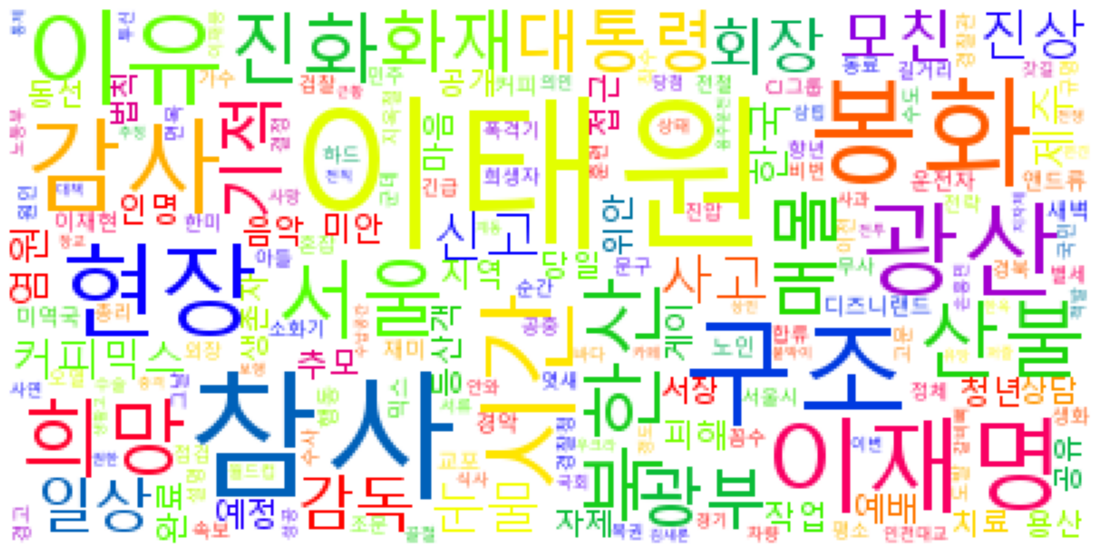

In [91]:
middle_title_word_cloud = WordCloud(
    font_path='malgun',
    background_color='white',
    max_font_size=60,
    colormap='prism'
).generate_from_frequencies(middle_title_counter)
plt.figure(figsize=(20, 10))
plt.imshow(middle_title_word_cloud)
plt.axis('off')

중앙일보 내용 토큰화한 것 딕셔너리로 만들기

In [92]:
middle_preprocessed_contents = []
for sentence in whole_middle_content_sentence_list:
    tokenized_word = extract_noun_from_kiwi_analyzed(sentence)
    for word in tokenized_word: 
        if len(word) > 2: 
            middle_preprocessed_contents.append(word) 
middle_content_counter = Counter(middle_preprocessed_contents)

(-0.5, 399.5, 199.5, -0.5)

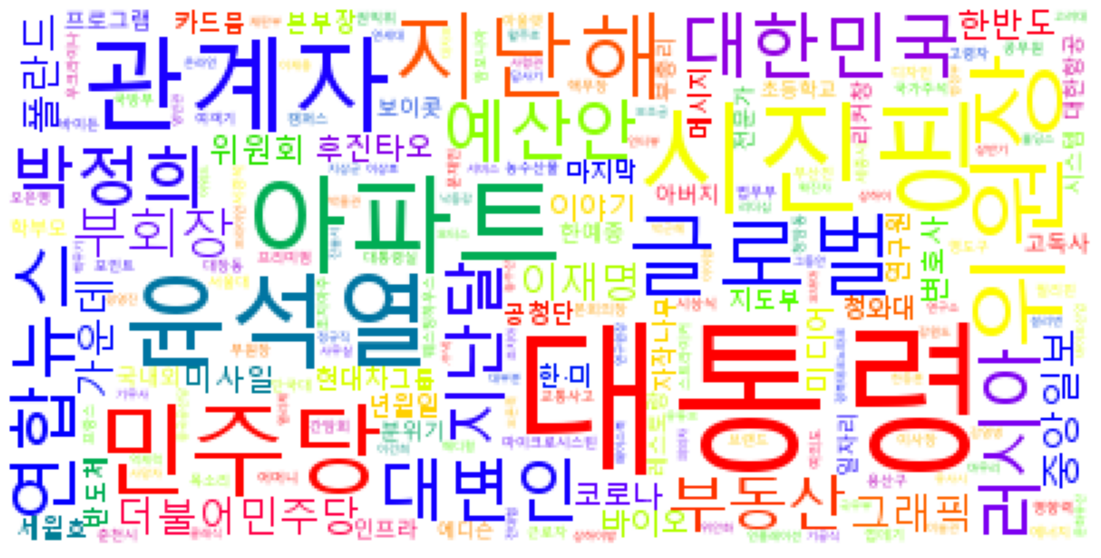

In [140]:
middle_content_cloud = WordCloud(
    font_path='malgun',
    background_color='white',
    max_font_size=60,
    colormap='prism'
).generate_from_frequencies(middle_content_counter)
plt.figure(figsize=(20, 10))
plt.imshow(middle_content_cloud)
plt.axis('off')

### 머니투데이 데이터 유사성 구하기

머니투데이 신문 제목 추출하기

In [93]:
whole_money_title_noun = []
for money_title in money_today_database["title"]:
    kospacing_title_list = []
    list1 = str(money_title).split('.')
    for i in list1:
        i_1= ''
        i_1+=i
        for i_2 in i_1.split(','):
            title = ''
            title+= i_2
        kospacing_title_list.append(title)
    for title in kospacing_title_list:
        for noun in extract_noun_from_kiwi_analyzed(title):
            if len(noun) < 3:
                continue
            else:
                whole_money_title_noun.append(noun)

머니 투데이 URL 추출하기

In [94]:
whole_money_content_sentence_list = []
for money_url in tqdm(money_today_database["url"]):
    headers = {"User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36"}
    try:
        response_0 = requests.get(money_url, headers=headers)
    except OSError:
        print("OS 연결에서 응답이 되지 않습니다.")
        whole_money_content_sentence_list.append("None")     
    else:
        soup_0 = BeautifulSoup(response_0.text, 'html.parser')
        content_0_data = soup_0.find('div', {"id" : "dic_area"})
        try:
            content_0_data = content_0_data.get_text().strip()
        except AttributeError:
            whole_money_content_sentence_list.append("None")
        else:
            content_0_data = content_0_data.replace('\n','').replace('\t','')
            new_content_0_data = content_0_data.replace(" ", '')
            kospacing_new_content_0_data = spacing(new_content_0_data) 
            words_data = twitter.morphs(kospacing_new_content_0_data)
            with open("korean_stopwords.txt", "r", encoding="UTF-8") as stopwords:
                stopwords_list = stopwords.read().split('\n')
            new_content_1 ='' 
            for i in korean_change_no_stop_words(words_data, stopwords_list):
                new_content_1 += i
            tokenizer3_content_1 = RegexpTokenizer('[A-Za-z0-9ㄱ-ㅎ/()]+', gaps=True)
            # tokenizer3_content_2 = RegexpTokenizer('')
            # print(tokenizer3_content_1.tokenize(new_content_1))
            regular_expression_sentence = ''
            for expression in tokenizer3_content_1.tokenize(new_content_1):
                regular_expression_sentence += expression
            whole_money_content_sentence_list.append(regular_expression_sentence)

  0%|          | 0/86 [00:00<?, ?it/s]

1/1 [==============================] - 0s 66ms/step


  1%|          | 1/86 [00:02<02:56,  2.07s/it]

1/1 [==============================] - 0s 81ms/step


  3%|▎         | 3/86 [00:03<01:29,  1.08s/it]

1/1 [==============================] - 0s 67ms/step


  6%|▌         | 5/86 [00:05<01:05,  1.23it/s]

1/1 [==============================] - 0s 78ms/step


  7%|▋         | 6/86 [00:06<01:10,  1.14it/s]

1/1 [==============================] - 0s 81ms/step


  8%|▊         | 7/86 [00:07<01:11,  1.11it/s]

1/1 [==============================] - 0s 73ms/step


  9%|▉         | 8/86 [00:08<01:29,  1.15s/it]

1/1 [==============================] - 0s 69ms/step


 10%|█         | 9/86 [00:10<01:32,  1.20s/it]

1/1 [==============================] - 0s 91ms/step


 12%|█▏        | 10/86 [00:12<01:48,  1.43s/it]

1/1 [==============================] - 0s 111ms/step


 14%|█▍        | 12/86 [00:14<01:29,  1.20s/it]

1/1 [==============================] - 0s 115ms/step


 15%|█▌        | 13/86 [00:15<01:29,  1.23s/it]

1/1 [==============================] - 0s 83ms/step


 16%|█▋        | 14/86 [00:17<01:31,  1.27s/it]

1/1 [==============================] - 0s 81ms/step


 17%|█▋        | 15/86 [00:18<01:23,  1.18s/it]

1/1 [==============================] - 0s 62ms/step


 19%|█▊        | 16/86 [00:18<01:07,  1.03it/s]

1/1 [==============================] - 0s 82ms/step


 21%|██        | 18/86 [00:19<00:54,  1.25it/s]

1/1 [==============================] - 0s 78ms/step


 22%|██▏       | 19/86 [00:21<01:03,  1.06it/s]

1/1 [==============================] - 0s 62ms/step


 23%|██▎       | 20/86 [00:22<01:17,  1.17s/it]

1/1 [==============================] - 0s 91ms/step


 24%|██▍       | 21/86 [00:25<01:41,  1.56s/it]

1/1 [==============================] - 0s 85ms/step


 26%|██▌       | 22/86 [00:26<01:32,  1.44s/it]

1/1 [==============================] - 0s 74ms/step


 27%|██▋       | 23/86 [00:28<01:50,  1.76s/it]

1/1 [==============================] - 0s 76ms/step


 28%|██▊       | 24/86 [00:32<02:15,  2.19s/it]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 25/86 [00:35<02:41,  2.64s/it]

1/1 [==============================] - 0s 47ms/step


 30%|███       | 26/86 [00:37<02:18,  2.31s/it]

1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 27/86 [00:40<02:37,  2.66s/it]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 28/86 [00:41<02:05,  2.16s/it]

1/1 [==============================] - 0s 81ms/step


 34%|███▎      | 29/86 [00:43<01:50,  1.94s/it]

1/1 [==============================] - 0s 113ms/step


 35%|███▍      | 30/86 [00:43<01:25,  1.53s/it]

1/1 [==============================] - 0s 71ms/step


 36%|███▌      | 31/86 [00:45<01:29,  1.63s/it]

1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 32/86 [00:46<01:17,  1.44s/it]

1/1 [==============================] - 0s 137ms/step


 38%|███▊      | 33/86 [00:48<01:24,  1.60s/it]

1/1 [==============================] - 0s 75ms/step


 40%|███▉      | 34/86 [00:49<01:04,  1.24s/it]

1/1 [==============================] - 0s 64ms/step


 41%|████      | 35/86 [00:50<01:12,  1.43s/it]

1/1 [==============================] - 0s 75ms/step


 42%|████▏     | 36/86 [00:53<01:21,  1.64s/it]

1/1 [==============================] - 0s 62ms/step


 43%|████▎     | 37/86 [00:54<01:15,  1.54s/it]

1/1 [==============================] - 0s 79ms/step


 44%|████▍     | 38/86 [00:56<01:17,  1.61s/it]

1/1 [==============================] - 0s 65ms/step


 45%|████▌     | 39/86 [00:58<01:30,  1.92s/it]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 40/86 [01:01<01:38,  2.14s/it]

1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 41/86 [01:02<01:23,  1.87s/it]

1/1 [==============================] - 0s 95ms/step


 49%|████▉     | 42/86 [01:03<01:09,  1.58s/it]

1/1 [==============================] - 0s 93ms/step


 50%|█████     | 43/86 [01:05<01:07,  1.56s/it]

1/1 [==============================] - 0s 62ms/step


 51%|█████     | 44/86 [01:05<00:56,  1.34s/it]

1/1 [==============================] - 0s 69ms/step


 53%|█████▎    | 46/86 [01:10<01:08,  1.72s/it]

1/1 [==============================] - 0s 76ms/step


 55%|█████▍    | 47/86 [01:13<01:15,  1.95s/it]

1/1 [==============================] - 0s 68ms/step


 56%|█████▌    | 48/86 [01:14<01:10,  1.86s/it]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 49/86 [01:18<01:23,  2.25s/it]

1/1 [==============================] - 0s 65ms/step


 58%|█████▊    | 50/86 [01:19<01:13,  2.03s/it]

1/1 [==============================] - 0s 77ms/step


 60%|██████    | 52/86 [01:20<00:44,  1.31s/it]

1/1 [==============================] - 0s 76ms/step


 62%|██████▏   | 53/86 [01:22<00:45,  1.37s/it]

1/1 [==============================] - 0s 62ms/step


 63%|██████▎   | 54/86 [01:24<00:50,  1.56s/it]

1/1 [==============================] - 0s 76ms/step


 64%|██████▍   | 55/86 [01:26<00:49,  1.60s/it]

1/1 [==============================] - 0s 63ms/step


 65%|██████▌   | 56/86 [01:28<00:55,  1.86s/it]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 58/86 [01:30<00:38,  1.38s/it]

1/1 [==============================] - 0s 98ms/step


 69%|██████▊   | 59/86 [01:33<00:47,  1.77s/it]

1/1 [==============================] - 0s 74ms/step


 71%|███████   | 61/86 [01:35<00:34,  1.39s/it]

1/1 [==============================] - 0s 68ms/step


 72%|███████▏  | 62/86 [01:37<00:33,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


 73%|███████▎  | 63/86 [01:38<00:32,  1.43s/it]

1/1 [==============================] - 0s 73ms/step


 74%|███████▍  | 64/86 [01:40<00:31,  1.44s/it]

1/1 [==============================] - 0s 78ms/step


 76%|███████▌  | 65/86 [01:42<00:34,  1.64s/it]

1/1 [==============================] - 0s 90ms/step


 77%|███████▋  | 66/86 [01:44<00:36,  1.83s/it]

1/1 [==============================] - 0s 86ms/step


 78%|███████▊  | 67/86 [01:46<00:38,  2.01s/it]

1/1 [==============================] - 0s 96ms/step


 79%|███████▉  | 68/86 [01:48<00:32,  1.80s/it]

1/1 [==============================] - 0s 89ms/step


 80%|████████  | 69/86 [01:52<00:44,  2.65s/it]

1/1 [==============================] - 0s 83ms/step


 81%|████████▏ | 70/86 [01:54<00:38,  2.40s/it]

1/1 [==============================] - 0s 68ms/step


 83%|████████▎ | 71/86 [01:56<00:34,  2.32s/it]

1/1 [==============================] - 0s 89ms/step


 84%|████████▎ | 72/86 [01:58<00:29,  2.12s/it]

1/1 [==============================] - 0s 89ms/step


 85%|████████▍ | 73/86 [02:00<00:25,  1.99s/it]

1/1 [==============================] - 0s 68ms/step


 86%|████████▌ | 74/86 [02:02<00:23,  1.95s/it]

1/1 [==============================] - 0s 104ms/step


 88%|████████▊ | 76/86 [02:04<00:14,  1.46s/it]

1/1 [==============================] - 0s 76ms/step


 90%|████████▉ | 77/86 [02:05<00:12,  1.41s/it]

1/1 [==============================] - 0s 71ms/step


 91%|█████████ | 78/86 [02:08<00:13,  1.71s/it]

1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 79/86 [03:37<03:16, 28.07s/it]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 81/86 [03:52<01:24, 16.95s/it]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 82/86 [03:53<00:48, 12.19s/it]

1/1 [==============================] - 0s 67ms/step


 97%|█████████▋| 83/86 [03:55<00:27,  9.01s/it]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 84/86 [03:56<00:13,  6.64s/it]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 85/86 [03:59<00:05,  5.56s/it]

1/1 [==============================] - 0s 36ms/step


100%|██████████| 86/86 [04:00<00:00,  2.80s/it]


In [95]:
whole_money_content_noun = []
count = 1
for content in tqdm(whole_money_content_sentence_list):
    if type(content) == float:
        continue
    else:
        noun_list = extract_noun_from_kiwi_analyzed(spacing(content))
        for noun in noun_list:
            if len(noun) < 3:
                continue
            else:
                whole_money_content_noun.append(noun)

  0%|          | 0/86 [00:00<?, ?it/s]

1/1 [==============================] - 0s 119ms/step


  1%|          | 1/86 [00:00<01:22,  1.03it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 2/86 [00:03<02:42,  1.94s/it]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 3/86 [00:04<01:43,  1.25s/it]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 4/86 [00:05<01:40,  1.23s/it]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 5/86 [00:05<01:16,  1.06it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 6/86 [00:07<01:43,  1.29s/it]

1/1 [==============================] - 0s 67ms/step


  8%|▊         | 7/86 [00:08<01:31,  1.16s/it]

1/1 [==============================] - 0s 60ms/step


  9%|▉         | 8/86 [00:09<01:32,  1.19s/it]

1/1 [==============================] - 0s 59ms/step


 10%|█         | 9/86 [00:10<01:31,  1.19s/it]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 10/86 [00:13<01:54,  1.51s/it]

1/1 [==============================] - 0s 65ms/step


 13%|█▎        | 11/86 [00:14<01:38,  1.31s/it]

1/1 [==============================] - 0s 65ms/step


 14%|█▍        | 12/86 [00:14<01:10,  1.05it/s]

1/1 [==============================] - 0s 54ms/step


 15%|█▌        | 13/86 [00:15<01:09,  1.05it/s]

1/1 [==============================] - 0s 65ms/step


 16%|█▋        | 14/86 [00:16<01:08,  1.04it/s]

1/1 [==============================] - 0s 78ms/step


 17%|█▋        | 15/86 [00:17<01:08,  1.03it/s]

1/1 [==============================] - 0s 43ms/step


 19%|█▊        | 16/86 [00:17<00:54,  1.29it/s]

1/1 [==============================] - 0s 43ms/step


 20%|█▉        | 17/86 [00:18<00:49,  1.39it/s]

1/1 [==============================] - 0s 59ms/step


 21%|██        | 18/86 [00:18<00:38,  1.78it/s]

1/1 [==============================] - 0s 70ms/step


 22%|██▏       | 19/86 [00:18<00:33,  1.99it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 20/86 [00:19<00:41,  1.60it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 21/86 [00:20<00:54,  1.20it/s]

1/1 [==============================] - 0s 57ms/step


 26%|██▌       | 22/86 [00:21<00:50,  1.26it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 23/86 [00:23<01:08,  1.09s/it]

1/1 [==============================] - 0s 59ms/step


 28%|██▊       | 24/86 [00:24<01:12,  1.16s/it]

1/1 [==============================] - 0s 56ms/step


 29%|██▉       | 25/86 [00:25<01:12,  1.20s/it]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 26/86 [00:27<01:28,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


 31%|███▏      | 27/86 [00:29<01:23,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 28/86 [00:30<01:17,  1.33s/it]

1/1 [==============================] - 0s 46ms/step


 34%|███▎      | 29/86 [00:31<01:03,  1.12s/it]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 30/86 [00:31<00:48,  1.15it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 31/86 [00:32<01:00,  1.10s/it]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 32/86 [00:33<00:55,  1.03s/it]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 33/86 [00:35<00:57,  1.09s/it]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 34/86 [00:35<00:43,  1.21it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 35/86 [00:36<00:47,  1.07it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 36/86 [00:43<02:14,  2.68s/it]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 37/86 [00:44<01:44,  2.13s/it]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 38/86 [00:49<02:27,  3.07s/it]

1/1 [==============================] - 0s 63ms/step


 45%|████▌     | 39/86 [00:51<02:12,  2.83s/it]

1/1 [==============================] - 0s 79ms/step


 47%|████▋     | 40/86 [00:57<02:58,  3.88s/it]

1/1 [==============================] - 0s 71ms/step


 48%|████▊     | 41/86 [00:58<02:07,  2.83s/it]

1/1 [==============================] - 0s 80ms/step


 49%|████▉     | 42/86 [00:58<01:31,  2.09s/it]

1/1 [==============================] - 0s 77ms/step


 50%|█████     | 43/86 [00:59<01:13,  1.71s/it]

1/1 [==============================] - 0s 60ms/step


 51%|█████     | 44/86 [00:59<00:55,  1.33s/it]

1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 45/86 [01:18<04:24,  6.45s/it]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 46/86 [01:18<03:06,  4.65s/it]

1/1 [==============================] - 0s 72ms/step


 55%|█████▍    | 47/86 [01:19<02:16,  3.50s/it]

1/1 [==============================] - 0s 76ms/step


 56%|█████▌    | 48/86 [01:21<01:49,  2.88s/it]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 49/86 [01:24<01:48,  2.93s/it]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 50/86 [01:26<01:41,  2.82s/it]

1/1 [==============================] - 0s 261ms/step


 59%|█████▉    | 51/86 [01:28<01:27,  2.50s/it]

1/1 [==============================] - 0s 61ms/step


 60%|██████    | 52/86 [01:28<01:01,  1.80s/it]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 53/86 [01:30<01:00,  1.84s/it]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 54/86 [01:32<01:00,  1.88s/it]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 55/86 [01:33<00:54,  1.75s/it]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 56/86 [01:36<01:02,  2.09s/it]

1/1 [==============================] - 0s 47ms/step


 66%|██████▋   | 57/86 [01:38<00:57,  1.98s/it]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 58/86 [01:43<01:20,  2.88s/it]

1/1 [==============================] - 0s 55ms/step


 69%|██████▊   | 59/86 [01:45<01:08,  2.52s/it]

1/1 [==============================] - 0s 63ms/step


 70%|██████▉   | 60/86 [01:47<01:01,  2.36s/it]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 61/86 [01:47<00:44,  1.80s/it]

1/1 [==============================] - 0s 68ms/step


 72%|███████▏  | 62/86 [01:48<00:39,  1.63s/it]

1/1 [==============================] - 0s 54ms/step


 73%|███████▎  | 63/86 [01:54<01:08,  2.96s/it]

1/1 [==============================] - 0s 56ms/step


 74%|███████▍  | 64/86 [01:56<00:52,  2.40s/it]

1/1 [==============================] - 0s 61ms/step


 76%|███████▌  | 65/86 [01:58<00:51,  2.47s/it]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 66/86 [02:10<01:42,  5.12s/it]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 67/86 [02:23<02:25,  7.65s/it]

1/1 [==============================] - 0s 60ms/step


 79%|███████▉  | 68/86 [02:25<01:45,  5.84s/it]

1/1 [==============================] - 0s 61ms/step


 80%|████████  | 69/86 [02:32<01:44,  6.17s/it]

1/1 [==============================] - 0s 79ms/step


 81%|████████▏ | 70/86 [02:33<01:15,  4.73s/it]

1/1 [==============================] - 0s 66ms/step


 83%|████████▎ | 71/86 [02:34<00:55,  3.73s/it]

1/1 [==============================] - 0s 64ms/step


 84%|████████▎ | 72/86 [02:36<00:42,  3.02s/it]

1/1 [==============================] - 0s 64ms/step


 85%|████████▍ | 73/86 [02:43<00:54,  4.16s/it]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 74/86 [02:45<00:44,  3.71s/it]

1/1 [==============================] - 1s 671ms/step


 87%|████████▋ | 75/86 [02:50<00:43,  3.97s/it]

1/1 [==============================] - 0s 67ms/step


 88%|████████▊ | 76/86 [02:50<00:28,  2.88s/it]

1/1 [==============================] - 0s 56ms/step


 90%|████████▉ | 77/86 [02:51<00:20,  2.32s/it]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 78/86 [02:52<00:16,  2.01s/it]

1/1 [==============================] - 0s 94ms/step


 92%|█████████▏| 79/86 [02:55<00:15,  2.18s/it]

1/1 [==============================] - 0s 79ms/step


 93%|█████████▎| 80/86 [02:56<00:11,  1.85s/it]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 81/86 [03:02<00:14,  2.97s/it]

1/1 [==============================] - 0s 74ms/step


 95%|█████████▌| 82/86 [03:02<00:08,  2.24s/it]

1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 83/86 [03:19<00:19,  6.55s/it]

1/1 [==============================] - 0s 83ms/step


 98%|█████████▊| 84/86 [03:19<00:09,  4.71s/it]

1/1 [==============================] - 0s 84ms/step


 99%|█████████▉| 85/86 [03:20<00:03,  3.58s/it]

1/1 [==============================] - 0s 76ms/step


100%|██████████| 86/86 [03:21<00:00,  2.34s/it]


In [96]:
money_title_content_vocab = list(set(whole_money_title_noun + whole_money_content_noun))
money_title_content_vocab.sort()

In [97]:
money_title_tfidf_result = []

# 각 문서에 대해서 아래 연산을 반복
for i in range(len(money_today_database["title"])):
  money_title_tfidf_result.append([])
  try:
    d = money_today_database["title"][i]
  except KeyError:
    for j in range(len(money_title_content_vocab)):
      money_title_tfidf_result[-1].append(0)
  else:
    for j in range(len(money_title_content_vocab)):
      t = money_title_content_vocab[j]
      try:
        money_title_tfidf_result[-1].append(tfidf(t, d))
      except AttributeError:
        money_title_tfidf_result[-1].append(0)

# len(result)
money_title_tfidf_ = pd.DataFrame(money_title_tfidf_result, columns=money_title_content_vocab, index=money_today_database["title"])
money_title_tfidf_

"봉화  "젠고유  '홍김  -칩스  -칩스법  -통계량  .구리  \
title                                                                          
북한산 족두리봉 '원인미상' 산불…"등산객 대피·접근 자제"       0.0   0.0  0.0  0.0   0.0   0.0  0.0   
검찰 "정진상 외장하드 암호 해제 중…'아들 노트북'은 압수 안해"   0.0   0.0  0.0  0.0   0.0   0.0  0.0   
서서 대변 보는 아이…놀란 오은영 "'이것' 떨어져" 충격 진단     0.0   0.0  0.0  0.0   0.0   0.0  0.0   
택배기사로 위장…어머니 흉기 협박해 금고 털어간 아들           0.0   0.0  0.0  0.0   0.0   0.0  0.0   
식당 불났는데 "설렁탕 먹자"…'긍정' 형제에 오은영 반전 분석     0.0   0.0  0.0  0.0   0.0   0.0  0.0   
...                                     ...   ...  ...  ...   ...   ...  ...   
"꿈에서 모친이 이재용 회장과 식사" 복권 1등 2번째 당첨 男     0.0   0.0  0.0  0.0   0.0   0.0  0.0   
[더영상]"CPR 가능한 분" 절박한 외침…손 '덜덜' 용산소방서장   0.0   0.0  0.0  0.0   0.0   0.0  0.0   
[오늘 날씨] 아침 최처 '-5도' 초겨울 추위…바람 강해 체감온도↓  0.0   0.0  0.0  0.0   0.0   0.0  0.0   
연준 '초강력 긴축'에도...美노동시장 "예상보다 강했다"        0.0   0.0  0.0  0.0   0.0   0.0  0.0   
모닥불로 10일 버텼다…봉화 광산 매몰 광부 2명 '기적의 생환'    0.0   0.0  0.0  0.0   0.0   0.0  0.0   

                                        .렌딧  .매체  .보드래  ...  후원금  후쿠오카  휴가철  \
title                                                   ...                   
북한산 족두리봉 '원인미상' 산불…"등산객 대피·접근 자제"       0.0  0.0   0.0  ...  0.0   0.0  0.0   
검찰 "정진상 외장하드 암호 해제 중…'아들 노트북'은 압수 안해"   0.0  0.0   0.0  ...  0.0   0.0  0.0   
서서 대변 보는 아이…놀란 오은영 "'이것' 떨어져" 충격 진단     0.0  0.0   0.0  ...  0.0   0.0  0.0   
택배기사로 위장…어머니 흉기 협박해 금고 털어간 아들           0.0  0.0   0.0  ...  0.0   0.0  0.0   
식당 불났는데 "설렁탕 먹자"…'긍정' 형제에 오은영 반전 분석     0.0  0.0   0.0  ...  0.0   0.0  0.0   
...                                     ...  ...   ...  ...  ...   ...  ...   
"꿈에서 모친이 이재용 회장과 식사" 복권 1등 2번째 당첨 男     0.0  0.0   0.0  ...  0.0   0.0  0.0   
[더영상]"CPR 가능한 분" 절박한 외침…손 '덜덜' 용산소방서장   0.0  0.0   0.0  ...  0.0   0.0  0.0   
[오늘 날씨] 아침 최처 '-5도' 초겨울 추위…바람 강해 체감온도↓  0.0  0.0   0.0  ...  0.0   0.0  0.0   
연준 '초강력 긴축'에도...美노동시장 "예상보다 강했다"        0.0  0.0   0.0  ...  0.0   0.0  0.0   
모닥불로 10일 버텼다…봉화 광산 매몰 광부 2명 '기적의 생환'    0.0  0.0   0.0  ...  0.0   0.0  0.0   

                                        휴대폰  흑석동  흙더미  흥국생명  희망퇴직  희생자  히틀러  
title                                                                        
북한산 족두리봉 '원인미상' 산불…"등산객 대피·접근 자제"       0.0  0.0  0.0   0.0   0.0  0.0  0.0  
검찰 "정진상 외장하드 암호 해제 중…'아들 노트북'은 압수 안해"   0.0  0.0  0.0   0.0   0.0  0.0  0.0  
서서 대변 보는 아이…놀란 오은영 "'이것' 떨어져" 충격 진단     0.0  0.0  0.0   0.0   0.0  0.0  0.0  
택배기사로 위장…어머니 흉기 협박해 금고 털어간 아들           0.0  0.0  0.0   0.0   0.0  0.0  0.0  
식당 불났는데 "설렁탕 먹자"…'긍정' 형제에 오은영 반전 분석     0.0  0.0  0.0   0.0   0.0  0.0  0.0  
...                                     ...  ...  ...   ...   ...  ...  ...  
"꿈에서 모친이 이재용 회장과 식사" 복권 1등 2번째 당첨 男     0.0  0.0  0.0   0.0   0.0  0.0  0.0  
[더영상]"CPR 가능한 분" 절박한 외침…손 '덜덜' 용산소방서장   0.0  0.0  0.0   0.0   0.0  0.0  0.0  
[오늘 날씨] 아침 최처 '-5도' 초겨울 추위…바람 강해 체감온도↓  0.0  0.0  0.0   0.0   0.0  0.0  0.0  
연준 '초강력 긴축'에도...美노동시장 "예상보다 강했다"        0.0  0.0  0.0   0.0   0.0  0.0  0.0  
모닥불로 10일 버텼다…봉화 광산 매몰 광부 2명 '기적의 생환'    0.0  0.0  0.0   0.0   0.0  0.0  0.0  

[86 rows x 1308 columns]

In [98]:
money_content_tfidf_result = []

# tfidf를 이용하여 머니투데이 내용을 행렬벡터화하기
for i in range(len(whole_money_content_sentence_list)):
  money_content_tfidf_result.append([])
  try:
    d = whole_money_content_sentence_list[i]
  except KeyError:
    for j in range(len(money_title_content_vocab)):
      money_content_tfidf_result[-1].append(0)
  else:
    for j in range(len(money_title_content_vocab)):
      t = money_title_content_vocab[j]
      money_content_tfidf_result[-1].append(tfidf(t, d))

money_content_tfidf_ = pd.DataFrame(money_content_tfidf_result, columns=money_title_content_vocab, index=money_today_database["content"])
money_content_tfidf_

"봉화  "젠고유  '홍김  -칩스  -칩스법  \
content                                                                         
서울 은평구 북한산 족두리봉에서 원인을 알 수 없는 산불이 발생했다. 5일 뉴스1에 ...  0.0   0.0  0.0  0.0   0.0   
검찰이 '성남FC 후원금 의혹'과 관련해 정진상 더불어민주당 대표실 정무조정실장의 자...  0.0   0.0  0.0  0.0   0.0   
대변을 서서 보는 등 이상행동을 보이는 금쪽이의 사연이 전파를 탄다. 11일 방송되는...  0.0   0.0  0.0  0.0   0.0   
어머니를 흉기로 위협해 금고에 있던 현금 1500만원 등을 훔쳐 달아난 20대 남성이...  0.0   0.0  0.0  0.0   0.0   
중화요리의 대가 여경래, 여경옥 형제가 '금쪽상담소'를 찾는다. 오는 11일 방송되는...  0.0   0.0  0.0  0.0   0.0   
...                                                 ...   ...  ...  ...   ...   
스피또1000 복권 1등에 당첨되는 행운을 거머쥔 당첨자가 과거 전자복권 1등에도 당...  0.0   0.0  0.0  0.0   0.0   
이번주 [더영상] 첫번째는 이태원 참사 현장에서 CPR(심폐소생술)을 도와달라고 외치...  0.0   0.0  0.0  0.0   0.0   
토요일인 오늘(5일)은 아침 최저기온이 영하 5도까지 떨어지면서 영하권 추위가 이어질...  0.0   0.0  0.0  0.0   0.0   
미 연방준비제도(연준·Fed)의 공격적 금리 인상에도 불구하고 미국 노동시장은 예상보...  0.0   0.0  0.0  0.0   0.0   
경북 봉화군 아연 광산 매몰사고로 갱도에 고립됐던 작업자가 10일만에 무사히 생환했다...  0.0   0.0  0.0  0.0   0.0   

                                                    -통계량  .구리  .렌딧  .매체  .보드래  \
content                                                                         
서울 은평구 북한산 족두리봉에서 원인을 알 수 없는 산불이 발생했다. 5일 뉴스1에 ...   0.0  0.0  0.0  0.0   0.0   
검찰이 '성남FC 후원금 의혹'과 관련해 정진상 더불어민주당 대표실 정무조정실장의 자...   0.0  0.0  0.0  0.0   0.0   
대변을 서서 보는 등 이상행동을 보이는 금쪽이의 사연이 전파를 탄다. 11일 방송되는...   0.0  0.0  0.0  0.0   0.0   
어머니를 흉기로 위협해 금고에 있던 현금 1500만원 등을 훔쳐 달아난 20대 남성이...   0.0  0.0  0.0  0.0   0.0   
중화요리의 대가 여경래, 여경옥 형제가 '금쪽상담소'를 찾는다. 오는 11일 방송되는...   0.0  0.0  0.0  0.0   0.0   
...                                                  ...  ...  ...  ...   ...   
스피또1000 복권 1등에 당첨되는 행운을 거머쥔 당첨자가 과거 전자복권 1등에도 당...   0.0  0.0  0.0  0.0   0.0   
이번주 [더영상] 첫번째는 이태원 참사 현장에서 CPR(심폐소생술)을 도와달라고 외치...   0.0  0.0  0.0  0.0   0.0   
토요일인 오늘(5일)은 아침 최저기온이 영하 5도까지 떨어지면서 영하권 추위가 이어질...   0.0  0.0  0.0  0.0   0.0   
미 연방준비제도(연준·Fed)의 공격적 금리 인상에도 불구하고 미국 노동시장은 예상보...   0.0  0.0  0.0  0.0   0.0   
경북 봉화군 아연 광산 매몰사고로 갱도에 고립됐던 작업자가 10일만에 무사히 생환했다...   0.0  0.0  0.0  0.0   0.0   

                                                    ...       후원금  후쿠오카  휴가철  \
content                                             ...                        
서울 은평구 북한산 족두리봉에서 원인을 알 수 없는 산불이 발생했다. 5일 뉴스1에 ...  ...  0.000000   0.0  0.0   
검찰이 '성남FC 후원금 의혹'과 관련해 정진상 더불어민주당 대표실 정무조정실장의 자...  ...  4.158883   0.0  0.0   
대변을 서서 보는 등 이상행동을 보이는 금쪽이의 사연이 전파를 탄다. 11일 방송되는...  ...  0.000000   0.0  0.0   
어머니를 흉기로 위협해 금고에 있던 현금 1500만원 등을 훔쳐 달아난 20대 남성이...  ...  0.000000   0.0  0.0   
중화요리의 대가 여경래, 여경옥 형제가 '금쪽상담소'를 찾는다. 오는 11일 방송되는...  ...  0.000000   0.0  0.0   
...                                                 ...       ...   ...  ...   
스피또1000 복권 1등에 당첨되는 행운을 거머쥔 당첨자가 과거 전자복권 1등에도 당...  ...  0.000000   0.0  0.0   
이번주 [더영상] 첫번째는 이태원 참사 현장에서 CPR(심폐소생술)을 도와달라고 외치...  ...  0.000000   0.0  0.0   
토요일인 오늘(5일)은 아침 최저기온이 영하 5도까지 떨어지면서 영하권 추위가 이어질...  ...  0.000000   0.0  0.0   
미 연방준비제도(연준·Fed)의 공격적 금리 인상에도 불구하고 미국 노동시장은 예상보...  ...  0.000000   0.0  0.0   
경북 봉화군 아연 광산 매몰사고로 갱도에 고립됐던 작업자가 10일만에 무사히 생환했다...  ...  0.000000   0.0  0.0   

                                                         휴대폰  흑석동  흙더미  흥국생명  \
content                                                                        
서울 은평구 북한산 족두리봉에서 원인을 알 수 없는 산불이 발생했다. 5일 뉴스1에 ...  0.000000  0.0  0.0   0.0   
검찰이 '성남FC 후원금 의혹'과 관련해 정진상 더불어민주당 대표실 정무조정실장의 자...  0.000000  0.0  0.0   0.0   
대변을 서서 보는 등 이상행동을 보이는 금쪽이의 사연이 전파를 탄다. 11일 방송되는...  0.000000  0.0  0.0   0.0   
어머니를 흉기로 위협해 금고에 있던 현금 1500만원 등을 훔쳐 달아난 20대 남성이...  1.386294  0.0  0.0   0.0   
중화요리의 대가 여경래, 여경옥 형제가 '금쪽상담소'를 찾는다. 오는 11일 방송되는...  0.000000  0.0  0.0   0.0   
...                                                      ...  ...  ...   ...   
스피또1000 복권 1등에 당첨되는 행운을 거머쥔 당첨자가 과거 전자복권 1등에도 당...  0.000000  0.0  0.0   0.0   
이번주 [더영상] 첫번째는 이태원 참사 현장에서 CPR(심폐소생술)을 도와달라고 외치...  0.000000  0.0  0.0   0.0   
토요일인 오늘(5일)은 아침 최저기온이 영하 5도까지 떨어지면서 영하권 추위가 이어질...  0.000000  0.0  0.0   0.0   
미 연방준비제도(연준·Fed)의 공격적 금

머니투데이 제목과 내용의 cos_sim 유사성 구하기

In [100]:
money_cos_sim_tfidf_ =pd.DataFrame(cosine_similar(money_title_tfidf_.values, money_content_tfidf_.values), index=money_today_database["title"])
money_cos_sim_tfidf_

0
title                                           
북한산 족두리봉 '원인미상' 산불…"등산객 대피·접근 자제"       0.008323
검찰 "정진상 외장하드 암호 해제 중…'아들 노트북'은 압수 안해"   0.001387
서서 대변 보는 아이…놀란 오은영 "'이것' 떨어져" 충격 진단     0.000000
택배기사로 위장…어머니 흉기 협박해 금고 털어간 아들           0.001387
식당 불났는데 "설렁탕 먹자"…'긍정' 형제에 오은영 반전 분석     0.000000
...                                          ...
"꿈에서 모친이 이재용 회장과 식사" 복권 1등 2번째 당첨 男     0.001387
[더영상]"CPR 가능한 분" 절박한 외침…손 '덜덜' 용산소방서장   0.036066
[오늘 날씨] 아침 최처 '-5도' 초겨울 추위…바람 강해 체감온도↓  0.000000
연준 '초강력 긴축'에도...美노동시장 "예상보다 강했다"        0.000000
모닥불로 10일 버텼다…봉화 광산 매몰 광부 2명 '기적의 생환'    0.000694

[86 rows x 1 columns]

In [101]:
money_whole_title_sentence = []
for money_title in money_today_database["title"]:
    kospacing_title_list = []
    list1 = str(money_title).split('.')
    title = ''
    for i in list1:
        title+=i
    money_whole_title_sentence.append(title)

머니투데이 제목 토큰화한 것 딕셔너리 형태로 만들기

In [102]:
money_title_vocab = {}
money_preprocessed_titles = []
for sentence in money_whole_title_sentence:
    # 단어 토큰화
    tokenized_word = extract_noun_from_kiwi_analyzed(sentence)
    for word in tokenized_word: 
        if len(word) > 2:
            money_preprocessed_titles.append(word)
money_title_counter = Counter(money_preprocessed_titles)

(-0.5, 399.5, 199.5, -0.5)

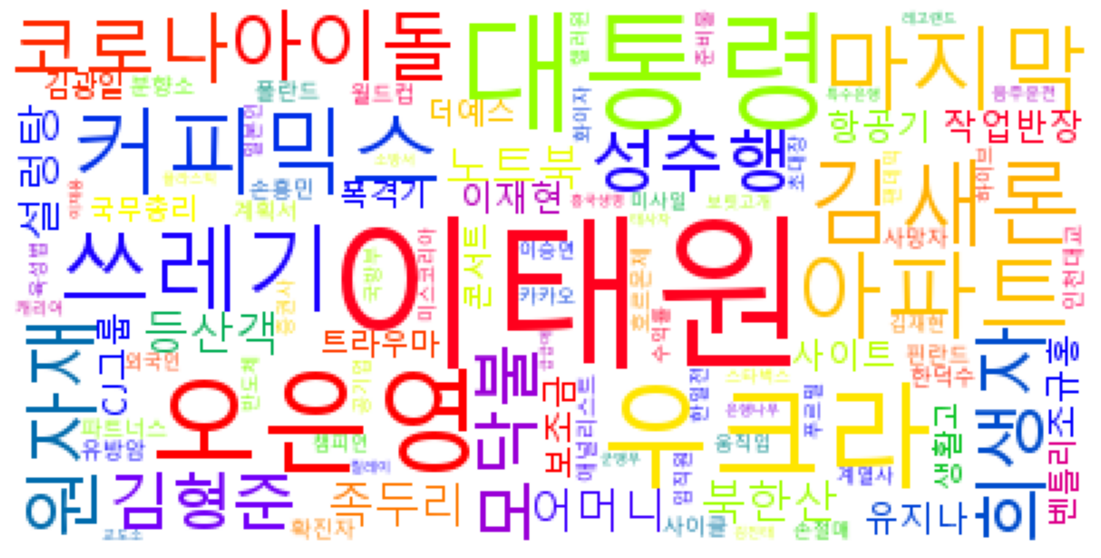

In [103]:
money_title_word_cloud = WordCloud(
    font_path='malgun',
    background_color='white',
    max_font_size=60,
    colormap='prism'
).generate_from_frequencies(money_title_counter)
plt.figure(figsize=(20, 10))
plt.imshow(money_title_word_cloud)
plt.axis('off')

머니투데이 내용 토큰화한 것 딕셔너리 형태로 만들기

In [104]:
money_preprocessed_contents = []
for sentence in whole_money_content_sentence_list:
    tokenized_word = extract_noun_from_kiwi_analyzed(sentence)
    for word in tokenized_word: 
        if len(word) > 2:
            money_preprocessed_contents.append(word) 
money_content_counter = Counter(money_preprocessed_contents)

(-0.5, 399.5, 199.5, -0.5)

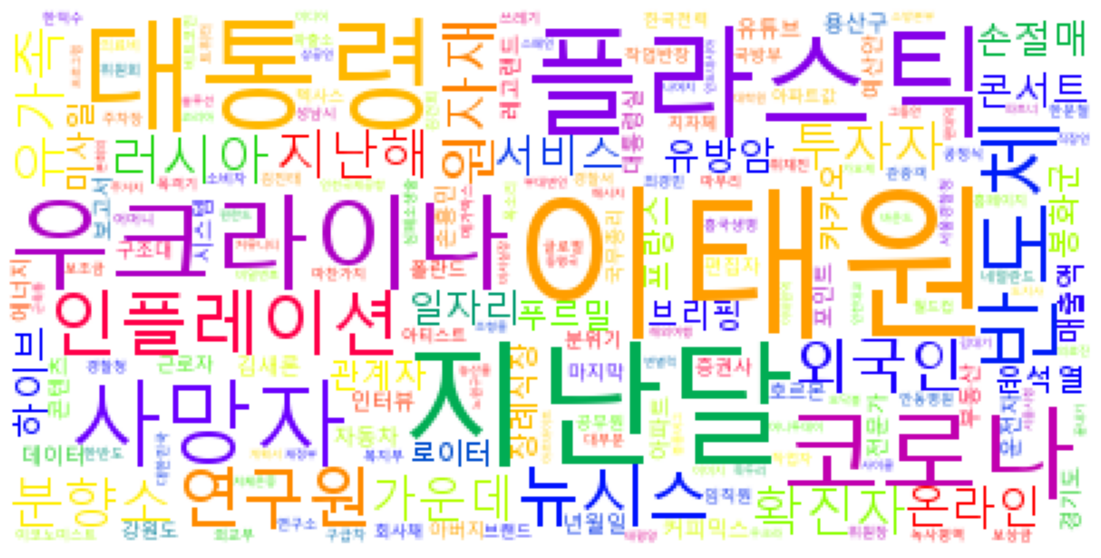

In [105]:
money_content_cloud = WordCloud(
    font_path='malgun',
    background_color='white',
    max_font_size=60,
    colormap='prism'
).generate_from_frequencies(money_content_counter)
plt.figure(figsize=(20, 10))
plt.imshow(money_content_cloud)
plt.axis('off')

### COS-SIMILARITY의 데이터프레임 만들기

In [113]:
cos_similarity_content_ = pd.DataFrame()
cos_similarity_content_["chosun_eilbo"] = chosun_cos_sim_tfidf_.values.flatten()
cos_similarity_content_["korean_economy"] = pd.Series(korean_cos_sim_tfidf_.values.flatten())
cos_similarity_content_["mail_economy"] = pd.Series(mail_cos_sim_tfidf_.values.flatten())
cos_similarity_content_["middle_eilbo"] = pd.Series(middle_cos_sim_tfidf_.values.flatten())
cos_similarity_content_["money_today"] = pd.Series(money_cos_sim_tfidf_.values.flatten())
cos_similarity_content = cos_similarity_content_.dropna()
cos_similarity_content

chosun_eilbo  korean_economy  mail_economy  middle_eilbo  money_today
0       0.047120        0.020863      0.000000      0.045305     0.008323
1       0.000000        0.009186      0.029123      0.009061     0.001387
2       0.026178        0.012922      0.000000      0.055373     0.000000
3       0.000000        0.012455      0.014871      0.009061     0.001387
4       0.000000        0.019617      0.029897      0.039265     0.000000
5       0.062827        0.017905      0.045729      0.007047     0.018033
6       0.005236        0.017126      0.056387      0.094638     0.000000
7       0.005236        0.015336      0.018093      0.015102     0.024969
8       0.000000        0.029893      0.008551      0.006041     0.006242
9       0.052356        0.009964      0.029743      0.006041     0.013178
10      0.005236        0.028258      0.000000      0.004027     0.045082
11      0.015707        0.017749      0.000000      0.005034     0.000000
12      0.005236        0.008174      0.005329      0.036244     0.003468
13      0.015707        0.014168      0.011401      0.006041     0.003468
14      0.010471        0.009809      0.016111      0.063427     0.001387
15      0.000000        0.011521      0.004833      0.005034     0.000000
16      0.020942        0.002647      0.013756      0.001007     0.002081
17      0.005236        0.029893      0.015863      0.011075     0.000000
18      0.010471        0.008563      0.010162      0.002014     0.032598
19      0.000000        0.014012      0.011030      0.036244     0.004161
20      0.020942        0.027713      0.013384      0.071482     0.110971
21      0.005236        0.008719      0.015367      0.005034     0.006242
22      0.000000        0.016503      0.010658      0.023156     0.000000
23      0.005236        0.010276      0.005453      0.047319     0.013178
24      0.052356        0.017282      0.019085      0.003020     0.042308
25      0.047120        0.032851      0.019209      0.001007     0.024275
26      0.083770        0.007629      0.000000      0.002014     0.070051
27      0.005236        0.055037      0.003718      0.079536     0.029130
28      0.020942        0.026935      0.017102      0.004027     0.015259
29      0.005236        0.012611      0.024909      0.007047     0.002081
30      0.057592        0.006072      0.013136      0.012081     0.034678
31      0.010471        0.008563      0.011153      0.014095     0.002774
32      0.000000        0.024755      0.082660      0.014095     0.012484
33      0.005236        0.031450      0.033708      0.001007     0.003468
34      0.015707        0.006928      0.006816      0.044299     0.049243
35      0.000000        0.031605      0.017969      0.024163     0.024969
36      0.005236        0.009653      0.019209      0.000000     0.004161
37      0.036649        0.010743      0.019704      0.033224     0.004161
38      0.010471        0.006850      0.021687      0.000000     0.043001
39      0.000000        0.014168      0.009790      0.030204     0.010404
40      0.000000        0.024132      0.035598      0.086583     0.003468
41      0.005236        0.003270      0.000000      0.022149     0.009016
42      0.000000        0.027090      0.026520      0.060407     0.024969
43      0.010471        0.013389      0.004833      0.166119     0.009710
44      0.005236        0.083606      0.000000      0.020136     0.018033
45      0.005236        0.047797      0.007962      0.004027     0.000000
46      0.000000        0.037055      0.012393      0.000000     0.037453
47      0.015707        0.040947      0.003346      0.004027     0.015952
48      0.047120        0.020240      0.000000      0.001007     0.011791
49      0.005236        0.035653      0.000000      0.003020     0.000000
50      0.000000        0.021174      0.019085      0.000000     0.000694

이 5개의 언론사들의 서로 상관, 연관분석 시각화하기

<AxesSubplot:>

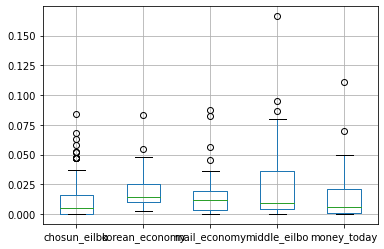

In [116]:
cos_similarity_content_.boxplot()

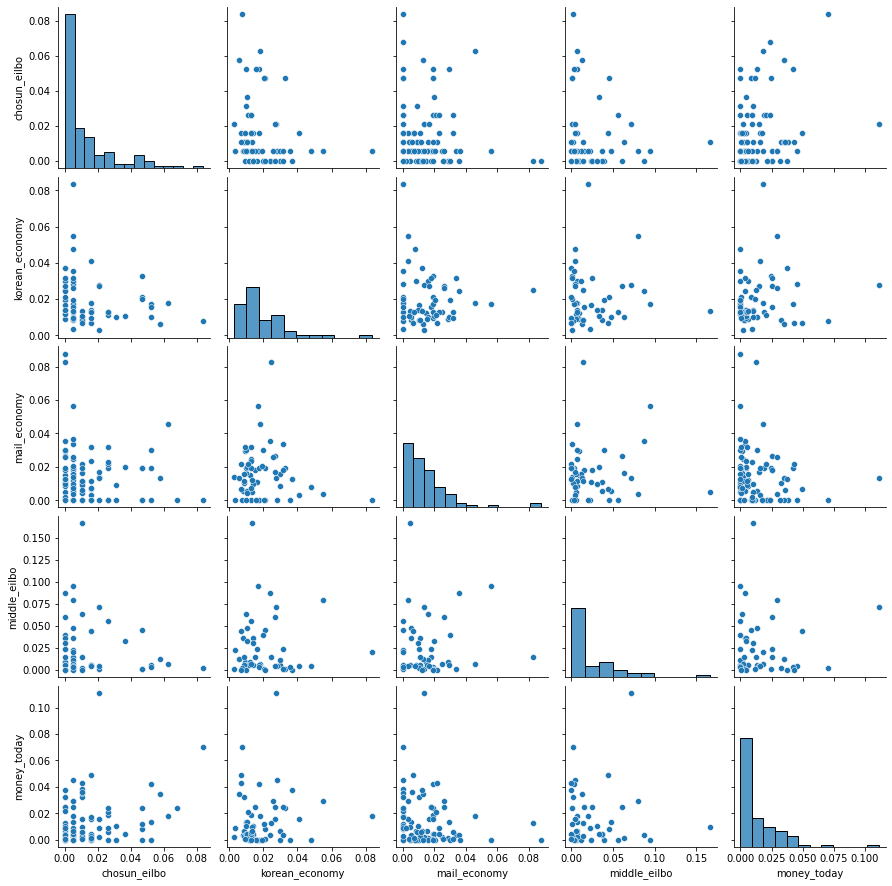

In [117]:
sns.pairplot(cos_similarity_content_)

In [118]:
cos_similarity_content_.corr()

chosun_eilbo  korean_economy  mail_economy  middle_eilbo  \
chosun_eilbo        1.000000       -0.203855     -0.121471     -0.158291   
korean_economy     -0.203855        1.000000     -0.073244      0.003022   
mail_economy       -0.121471       -0.073244      1.000000      0.047506   
middle_eilbo       -0.158291        0.003022      0.047506      1.000000   
money_today         0.262587        0.113140     -0.164374      0.041423   

                money_today  
chosun_eilbo       0.262587  
korean_economy     0.113140  
mail_economy      -0.164374  
middle_eilbo       0.041423  
money_today        1.000000

## 결론

이를 통해서 5개의 신문사들의 제목 -내용 유사도를 분석한 결과 0보다 큰 비율은 나타냈지만, 거의 약 0.001이상의 비율로 유사도가 측정된 것을 확인할 수 있었습니다. 그리고, 워드클라우드와 산포도 시각화 분석한 결과 비율로도 겹치는 분야도 있지만, 제목에 없는 내용의 요소들이 가득있으면서, 이를 통해 TF-IDF는 원래 단어 요소들의 개수를 파악하는 기법이기 땜에 그에 대해서 영향을 미치면서 0.001이상의 비율로 측정되었다는 것을 알게 되었습니다. 제목과 내용의 유사성의 동일은 0.001이상이 되어야지 거의 유사한 것을 확인할 수 있어서.. 참 내용 처리를 하는데 완벽하게 비슷한 용어들을 다 같은 용어로 취급 처리하기가 어렵다는 한계점이 도달한다는 것을 알 수 있습니다. 그리고, 지금 이 분석도 표본적으로 추출한 데이터들을 매개로 한 것이기 때문에.. 10000개의 데이터들을 분석하는데에 있어 너무 코드 부팅 시간이 한 언론사를 하는데 하루가 넘어갈 정도의 양들을 진행되면서 오류가 나기 시작하면서 분석 오류가 나게되어서 예외처리를 하였지만, 이도 막지 못했다는 오류적 한계도 있었다는 것을 확인 할 수 있었습니다. 제목 - 내용 신뢰도의 분석을 하면서 여러 용어들을 많이 쓰는 내용들의 단어 요소들과 제목의 요소들이 비슷하게 쓰이는 것도 있지만, 더 추가되거나 다르게 쓰이는 단어들도 많이 있어서 여러 사람들의 쓰이는 단어들이 다양하다라는 것을 확실히 알아볼 수 있습니다.

## 아쉬운점

프로그래밍을 하는데 제목 내용의 유사도를 구하는데 10000개 이상의 url 데이터들을 한꺼번에 추출하는데 하루 넘게 부팅 중이어서 추출하는데 어려움이 있었고, 결국 100개의 표본을 추출해야지 url에서 나온 내용들을 추출할 수가 있었습니다. 그리고, 제목과 내용의 유사도를 구하는데, 한글의 단어가 그만큼 뜻과 동의어, 반의어의 요소들이 복잡하다는 것을 느끼게 되어서 유사도의 비율이 가설만큼 안나온 결과가 나오게 되었다는 점이었다고 생각합니다. 그리고, 한글을 추출하는데, 한글 제목이 있는데, 영어로 된 내용으로 분석이 되어 있어서 이를 고려하지 못한 채 데이터들을 tf-idf하는 과정에서 유사도가 0이 나온 경우도 결과가 나오게 되었습니다. 그래서, 전체적으로 데이터를 추출을 못하고, 표본적으로 소수의 데이터만 추출하는 과정을 코드로 했다는 점이 아쉬웠습니다.

## References

데이터들을 분석하는 데에 있어서 단어 전처리를 하는 자연어 처리를 할 수 있는 오픈소스를 매개로 추출하였습니다. Github을 이용해서 소스 파일들을 모듈화하고, 이를 활용하여서 뉴스 데이터의 분석에 쓰게 되었습니다.
(오픈소스 출처: https://github.com/ukairia777/tensorflow-nlp-tutorial)